# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor

from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import xgboost as xgb
from xgboost import XGBRegressor

from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import sys
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
train_data = pd.read_csv('../Datasets/train_V2.csv')

# Data Fields
DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Data Analysis, Cleansing, Engineering, Pre-Processing

### View the dataset

In [60]:
train_data

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0               0.00      0              0      0         60  ...        0   
1              91.47      0              0      0         57  ...        0   
2              68.00      0              0      0         47  ...        0   
3              32.90      0              0      0         75  ...        0   
4             100.00      0              0      0         45  ...        0   
...              ...    ...            ...    ...        ...  ...      ...   
4446961         0.00      0              0      0         74  ...        0   
4446962        44.15      0              0      0         69  ...        0   
4446963        59.06      0              0      0         66  ...        0   
4446964       180.40      1              1      2         11  ...        2   
4446965       268.00      0              0      1         18  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0              0.0000          0         0.000          0               0   
1              0.0045          0        11.040          0               0   
2              0.0000          0         0.000          0               0   
3              0.0000          0         0.000          0               0   
4              0.0000          0         0.000          0               0   
...               ...        ...           ...        ...             ...   
4446961     1292.0000          0         0.000          0               0   
4446962        0.0000          0         0.000          0               0   
4446963        0.0000          0         2.184          0               0   
4446964        0.0000          0         0.000          0               0   
4446965     1369.0000          0         0.000          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0              244.80                1       1466        0.4444  
1             1434.00                5          0        0.6400  
2              161.80                2          0        0.7755  
3              202.70                3          0        0.1667  
4               49.75                2          0        0.1875  
...               ...              ...        ...           ...  
4446961       1019.00                3       1507        0.1786  
4446962         81.70                6          0        0.2935  
4446963        788.70                4          0        0.4815  
4446964       2748.00                8          0        0.8000  
4446965       1244.00                5          0        0.5464  

[4446966 rows x 29 columns]

### Check column names, data types

In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Check missing values

In [62]:
is_NaN = train_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train_data[row_has_NaN]
rows_with_NaN

Id         groupId         matchId  assists  boosts  \
2744604  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2744604          0.0      0              0      0          1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
2744604           0.0          0           0.0          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
2744604           0.0                0          0           NaN  

[1 rows x 29 columns]

#### Data Cleansing 1
Delete Missing Value, Ids

In [3]:
def delete_useless_data(train_data):
    
    #Maintain the original data
    train_data_ = train_data.copy()
    
    #Delete Ids
    train_data_ = train_data_.drop(["Id","groupId","matchId"],axis=1)
    
    #Drop the missing value
    train_data_ = train_data_.drop(2744604)
    
    #Reset the index
    train_data_ = train_data_.reset_index(drop=True)
    
    #Get y
    y_train = train_data_["winPlacePerc"]
    
    #Get X
    X_train = train_data_.drop(["winPlacePerc"],axis=1)
    
    return X_train,y_train,train_data_

In [4]:
X_train,y_train,train = delete_useless_data(train_data)

### Feature Plotting 

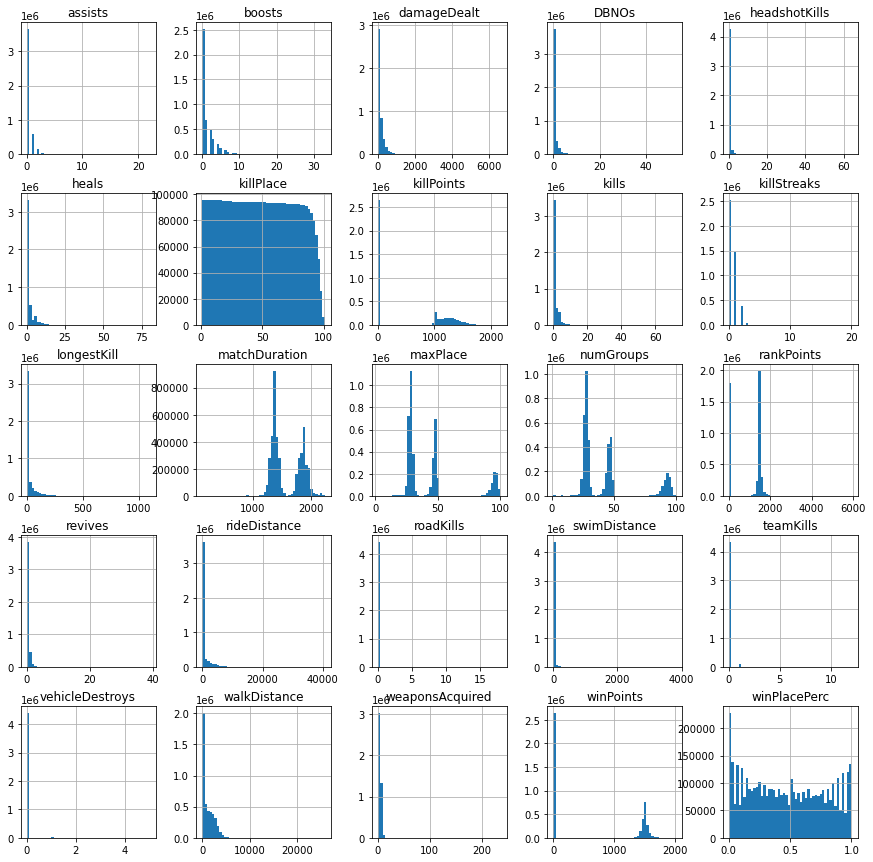

In [9]:
train.hist(bins=50, layout=(5,5),figsize=(15, 15))
plt.show()

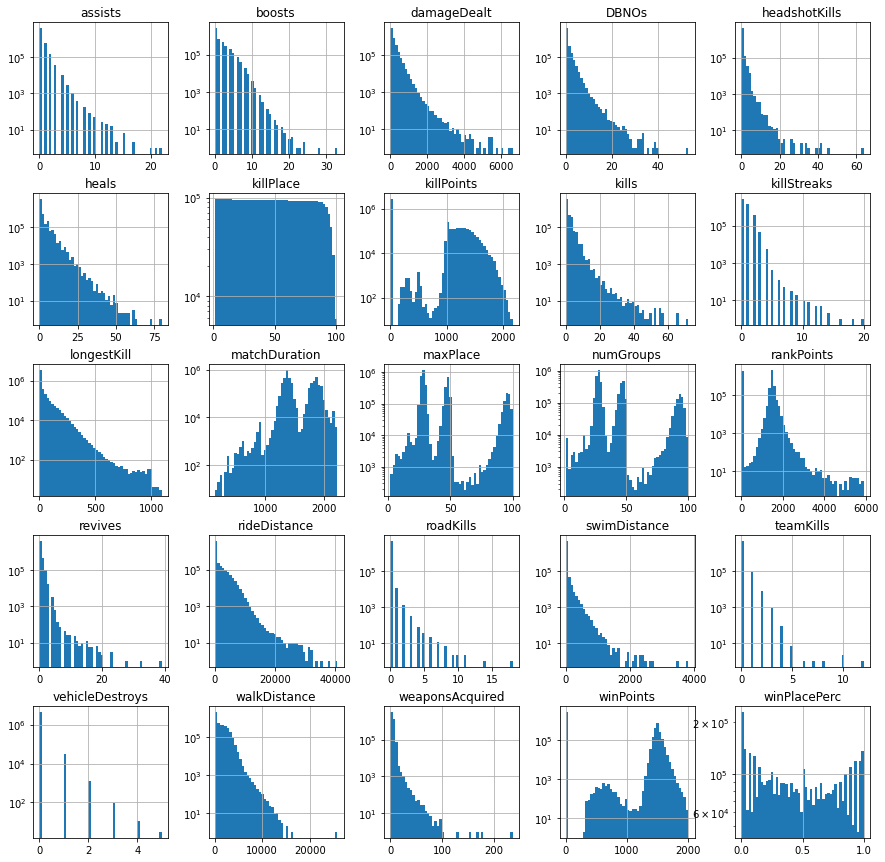

In [8]:
#Log scale
train.hist(bins=50, layout=(5,5),figsize=(15, 15),log=True)
plt.show()

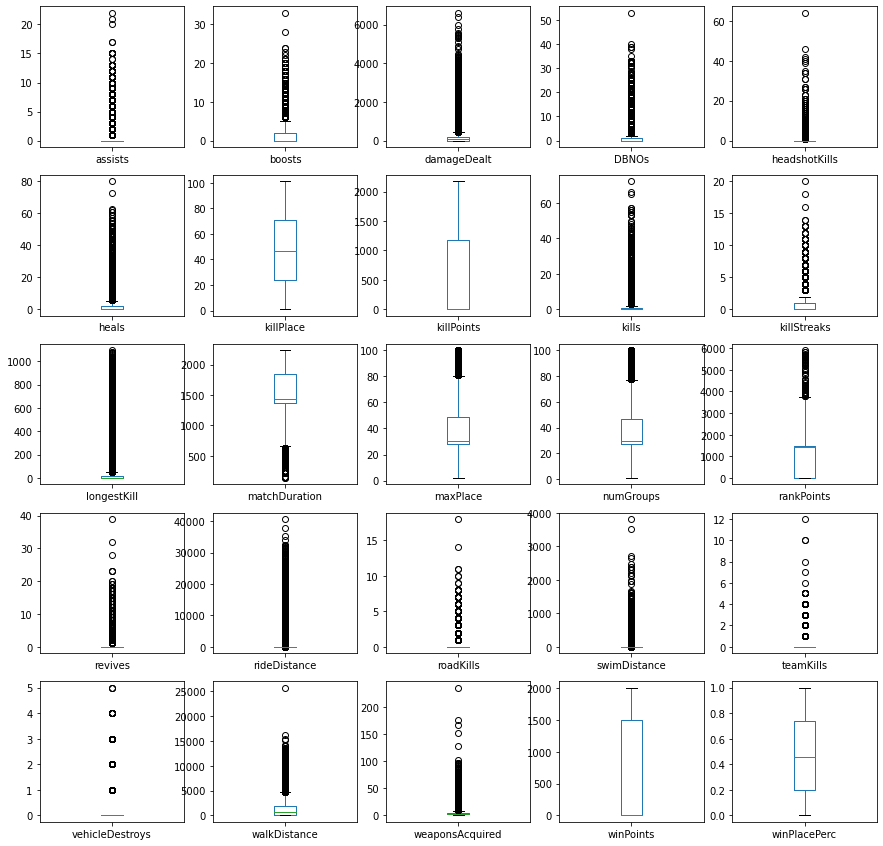

In [66]:
train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(15, 15))
plt.show()

### Data Normalization 
Min-Max Normalization

In [5]:
def normalize_data(dataset):
    
    #Maintain the original data
    dataset_ = dataset.copy()
    
    #Get data other than categorical data
    dataset_quantitative = dataset_.loc[:, dataset_.columns != 'matchType']
    
    #Do Min-Max normalization in each row
    for feature in dataset_quantitative:
        dataset_[feature]=(dataset_[feature]-dataset_[feature].min())/(dataset_[feature].max()-dataset_[feature].min())
        
    return dataset_

In [6]:
#Normalize the cleaned X
X_train = normalize_data(X_train)

#Get the new total training set with normalized X
train = pd.concat([X_train,y_train],axis=1)

### Cluster Analysis

In [7]:
def getAverageWPP(y,n_clusters):
    
    #Initialize a list for storing the means with n_clusters 0s
    means = [0]*n_clusters
    
    #Get the mean in each cluster
    for i in range(n_clusters):
        means[i] = y[y["cluster"] == i]["winPlacePerc"].mean()
        
    return means

In [8]:
#One hot encoding for matchType in order to do clustering
X_train_temp = pd.get_dummies(data = X_train, columns = ["matchType"])

#Turn numpy array into pandas dataframe
y_train_temp = pd.DataFrame({"winPlacePerc": y_train})

### Kmeans: random_state and n_init

By answering your last week's comment "*I don't understand what this(random_state=200) means. I assume KMeans.n_init is the number of initialisations… what is done 200 times?*":

Yes, **KMeans.n_init** is the number of initialisations. 

**KMeans.random_state** is a seed that determines random number generation for the initialisations. 

***If set to None***

Use the global random state instance from numpy.random. Calling the function multiple times will reuse the same instance, and will produce different results.

***If set to An Integer***

Use a new random number generator seeded by the given integer. Using an int will produce the same results across different calls. However, it may be worthwhile checking that your results are stable across a number of different distinct random seeds. Popular integer random seeds are 0 and 42.

*I'm using integer random_states because "using an int will produce the same results across different calls". Thus it will be easy if I'd like to reproduce the results.*

In [9]:
#Initialize kmeans with different n_init and different seed
kmeans_1 = KMeans(random_state=10,n_init = 10)
kmeans_2 = KMeans(random_state=20,n_init = 10)
kmeans_3 = KMeans(random_state=30,n_init = 50)
kmeans_4 = KMeans(random_state=40,n_init = 50)

### Metrics for clustering
By checking the documents again, https://scikit-learn.org/stable/modules/clustering.html, 3 metrics are suggested for this case by scikit-learn:

**Silhouette Coefficient:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

**Calinski-Harabasz Index:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score

**Davies-Bouldin Index:**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score

They may give different scores, I'm not sure which one is best in this case, this may need to be discussed.

#### First run with n_init = 10

In [64]:
#Used to do score VS n_clustet plotting
scores_1 = []
Xs_1 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_1.n_clusters = i
    
    #Train the model
    kmeans_1.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_1.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_1.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_1.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_1.append(i)
    
    #Append the score
    scores_1.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.46476373800952725, 0.47808063248598254]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.47341106429063695, 0.46476373800952725, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.0346284197 ,Average WPP:  [0.46085048894348124, 0.4910966126356347, 0.46476373800952725, 0.4858014244133839]
n_clusters:  5 ,Score:  2021932.1459346504 ,Average WPP:  [0.46611904131544957, 0.4858014244133839, 0.491079314620436, 0.4519082068421742, 0.46766057480638734]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.46451542322577083, 0.4858014244133839, 0.4519017153072053, 0.48277683575102587, 0.4635614043987694, 0.49108748830633536]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.4644975414396983, 0.4858014244133839, 0.4918353663921188, 0.46601951453185064, 0.47381422643355325, 0.4519082068421742, 0.48277683575102587]
n_clusters:  8 ,Score:  3014196.1926779295 ,Average WPP:  [0.4644951595079917, 0.485309021027

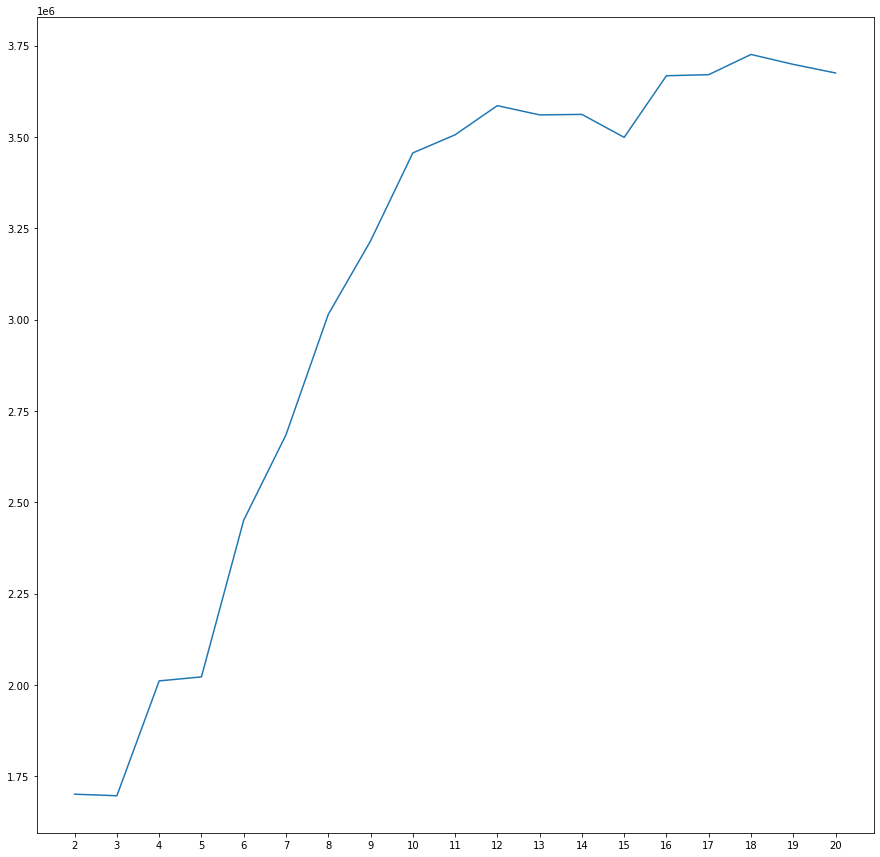

In [65]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_1,scores_1)
plt.xticks(Xs_1)
plt.savefig("Kmeans_1.png")
plt.show()

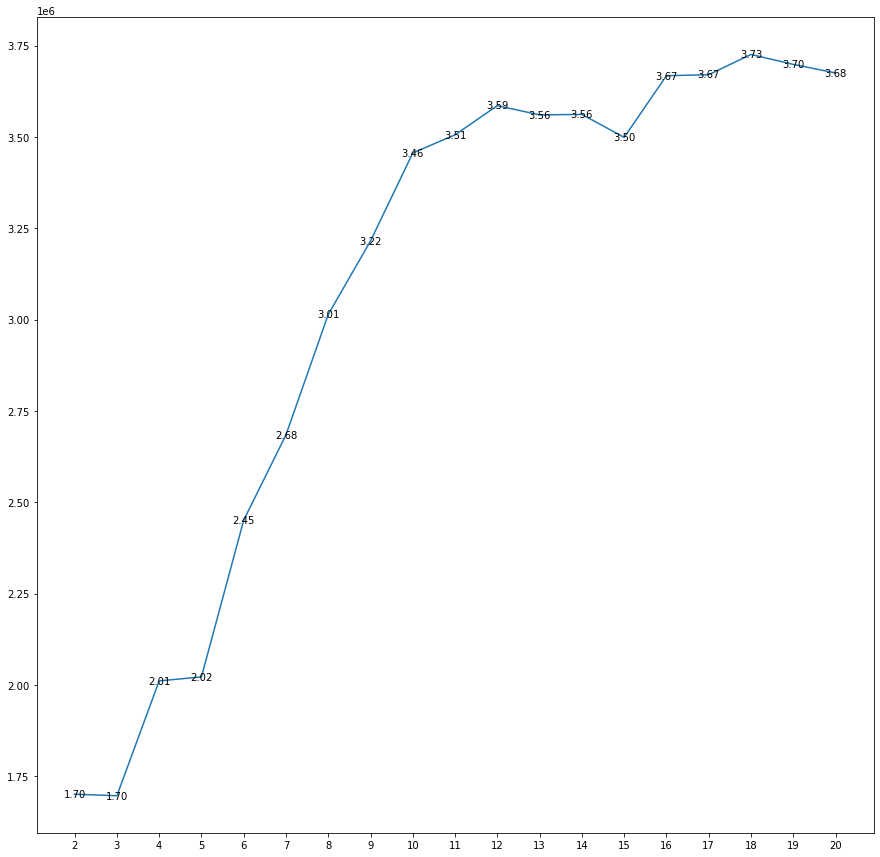

In [66]:
#With value - (looks mess)
plt.figure(figsize=(15,15))
for x,y in zip(Xs_1,scores_1):
    plt.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
plt.plot(Xs_1,scores_1)
plt.xticks(Xs_1)
plt.savefig("Kmeans_1_value.png")
plt.show()

#### Second run with n_init = 10

In [67]:
#Used to do score VS n_clustet plotting
scores_2 = []
Xs_2 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_2.n_clusters = i
    
    #Train the model
    kmeans_2.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_2.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_2.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_2.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_2.append(i)
    
    #Append the score
    scores_2.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.47808063248598254, 0.46476373800952725]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.47341106429063695, 0.46476373800952725, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.0346683238 ,Average WPP:  [0.4858014244133839, 0.46476373800952725, 0.46085079226274056, 0.4910962779976895]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.4858014244133839, 0.46381573014471816, 0.4608496501576607, 0.4910966126356347, 0.4654673331482458]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.46451542322577083, 0.4635614043987694, 0.4858014244133839, 0.4519017153072053, 0.49108748830633536, 0.48277683575102587]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.4858014244133839, 0.46601951453185064, 0.4918353663921188, 0.47381422643355325, 0.4519082068421742, 0.4644975414396983, 0.48277683575102587]
n_clusters:  8 ,Score:  3014196.1926779295 ,Average WPP:  [0.4644951595079917, 0.4659552511629

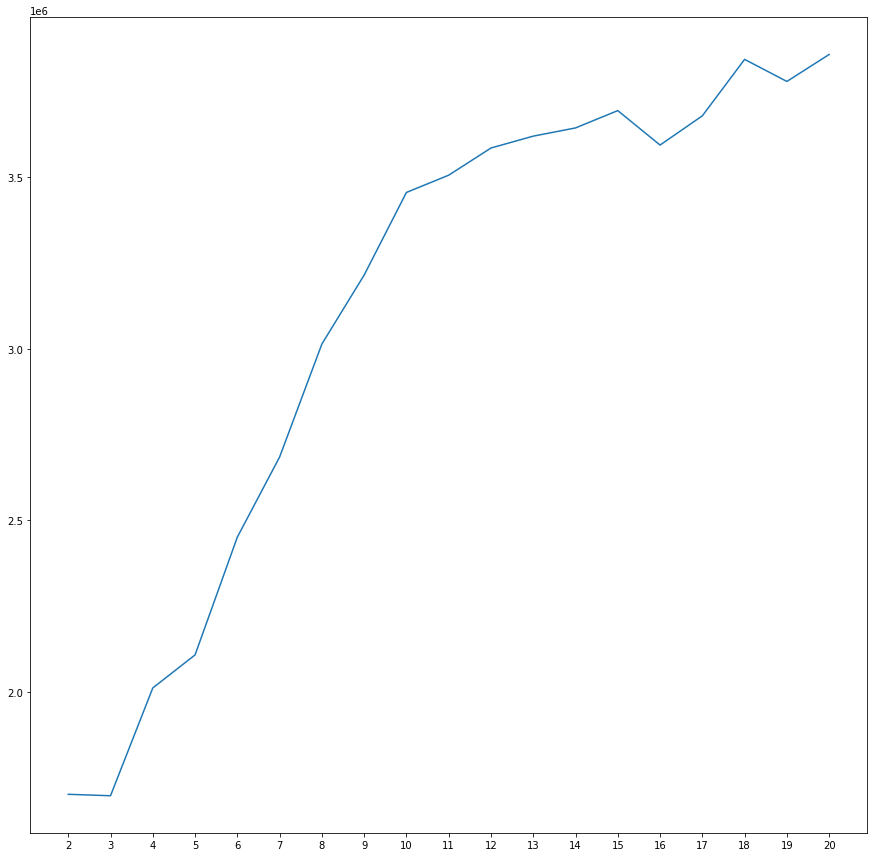

In [68]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_2,scores_2)
plt.xticks(Xs_2)
plt.savefig("Kmeans_2.png")
plt.show()

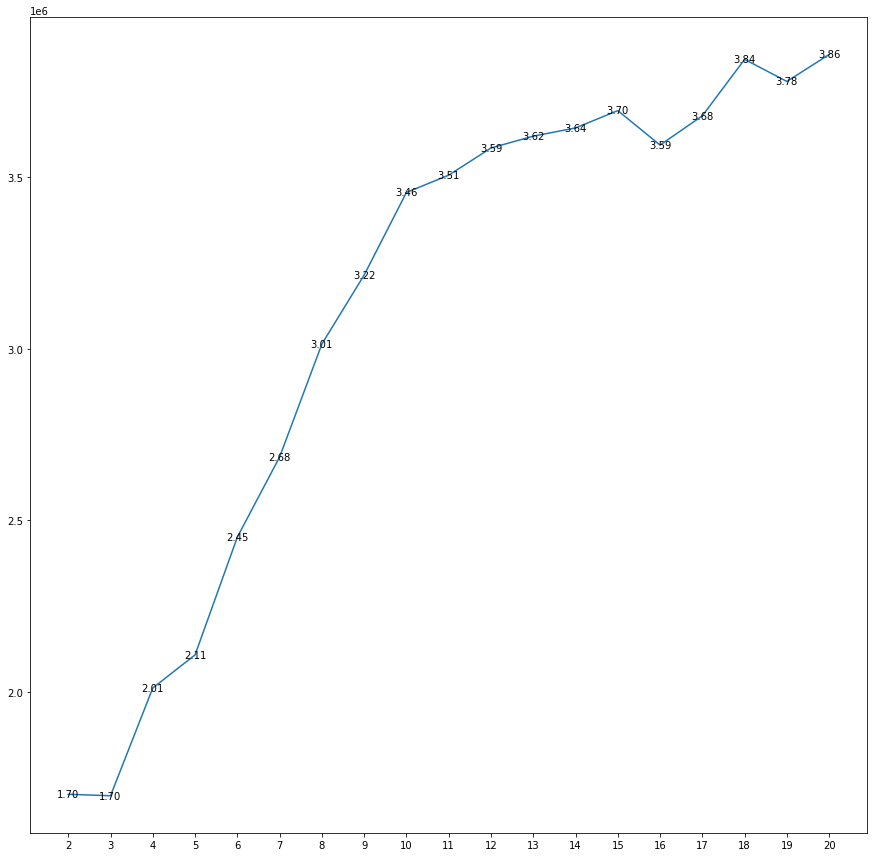

In [69]:
#With value
plt.figure(figsize=(15,15))
for x,y in zip(Xs_2,scores_2):
    plt.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
plt.plot(Xs_2,scores_2)
plt.xticks(Xs_2)
plt.savefig("Kmeans_2_value.png")
plt.show()

#### First run with n_init = 50

In [70]:
#Used to do score VS n_clustet plotting
scores_3 = []
Xs_3 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_3.n_clusters = i
    
    #Train the model
    kmeans_3.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_3.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_3.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_3.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_3.append(i)
    
    #Append the score
    scores_3.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.46476373800952725, 0.47808063248598254]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.46476373800952725, 0.47341106429063695, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.0347069318 ,Average WPP:  [0.46476373800952725, 0.4858014244133839, 0.49109623423955856, 0.4608507931278518]
n_clusters:  5 ,Score:  2107413.4192282236 ,Average WPP:  [0.4638150129938914, 0.4858014244133839, 0.4910961247498727, 0.4654673331482458, 0.4608506431968369]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.46451542322577083, 0.49108748830633536, 0.4858014244133839, 0.4519017153072053, 0.48277683575102587, 0.4635614043987694]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.4644975414396983, 0.4858014244133839, 0.4918353663921188, 0.46601951453185064, 0.48277683575102587, 0.4519082068421742, 0.47381422643355325]
n_clusters:  8 ,Score:  3014196.19267793 ,Average WPP:  [0.48530902102785783, 0.46449515950799

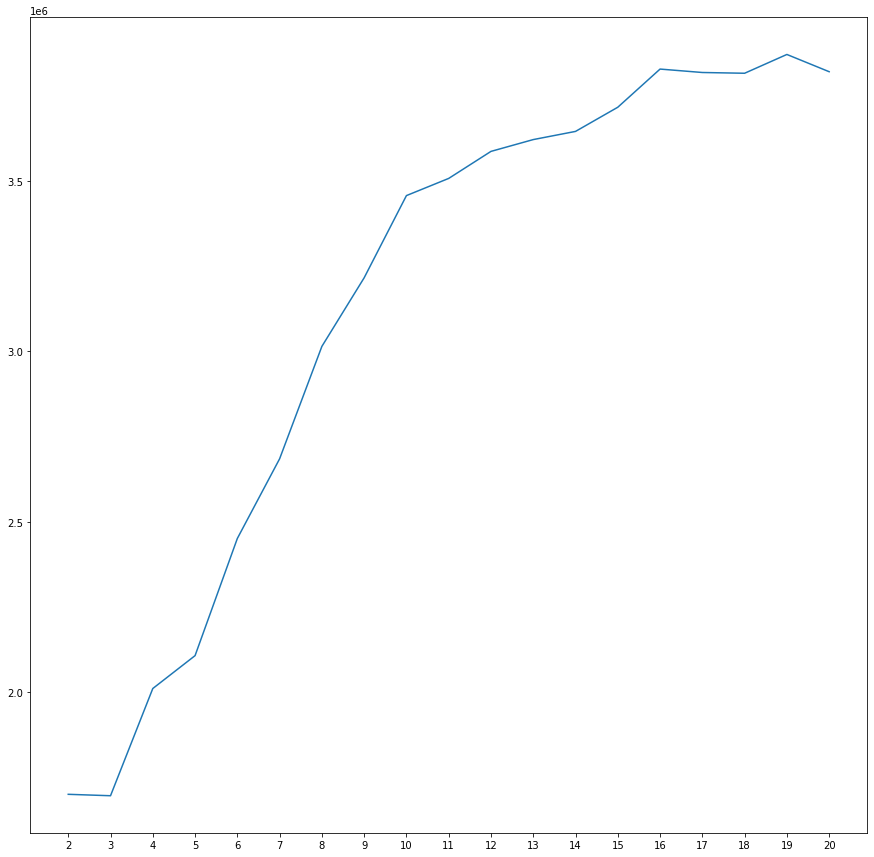

In [71]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_3,scores_3)
plt.xticks(Xs_3)
plt.savefig("Kmeans_3.png")
plt.show()

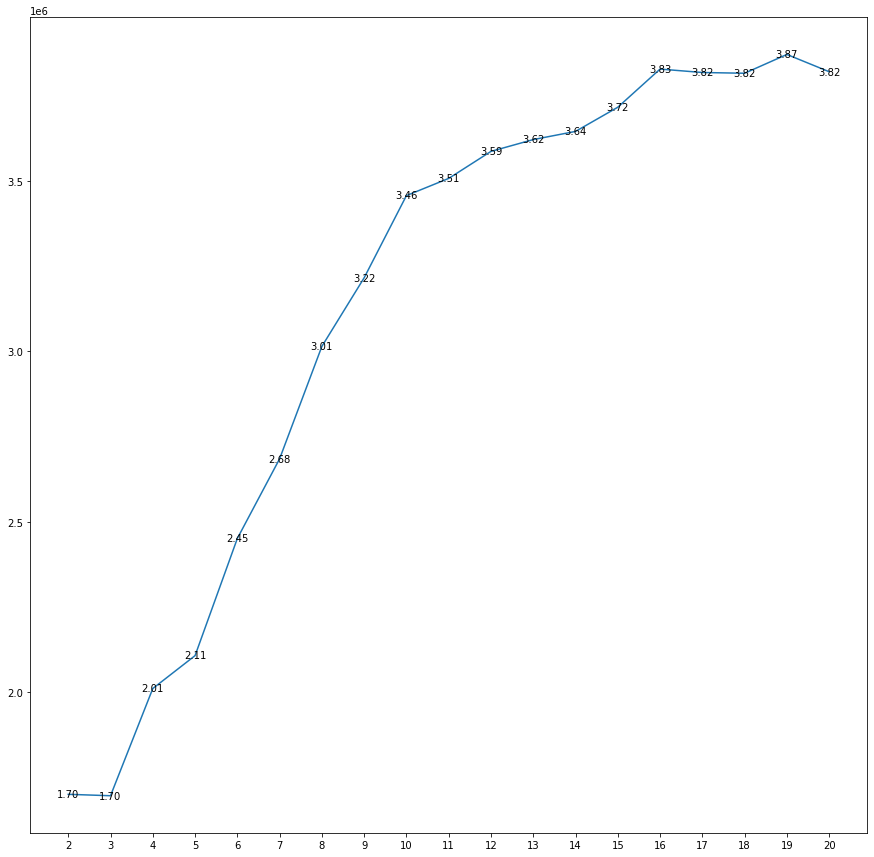

In [72]:
#With value
plt.figure(figsize=(15,15))
for x,y in zip(Xs_3,scores_3):
    plt.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
plt.plot(Xs_3,scores_3)
plt.xticks(Xs_3)
plt.savefig("Kmeans_3_value.png")
plt.show()

#### Second run with n_init = 50

In [73]:
#Used to do score VS n_clustet plotting
scores_4 = []
Xs_4 = []

#Used to store best number of clusters, best score and best average WPP
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0

for i in range(2,21):   
    
    #Assign number of clusters
    kmeans_4.n_clusters = i
    
    #Train the model
    kmeans_4.fit(X_train_temp)
    
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans_4.labels_)
    
    #Add a cluster column to store labels
    X_train_temp["cluster"] = kmeans_4.labels_
    
    #Add a cluster column to store labels
    y_train_temp["cluster"] = kmeans_4.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,i)
    
    #If the score for current n_cluster is higher, then replace the best values
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    
    #Print the values
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    
    #Append the n_cluster
    Xs_4.append(i)
    
    #Append the score
    scores_4.append(score)
    
    #Delete the cluster column
    X_train_temp = X_train_temp.drop(["cluster"],axis=1) 
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 

#Print the best values
print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.46476373800952725, 0.47808063248598254]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.46476373800952725, 0.47341106429063695, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.034706931 ,Average WPP:  [0.4858014244133839, 0.46476373800952725, 0.4608507931278518, 0.49109623423955856]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.4858014244133839, 0.4654673331482458, 0.4910966126356347, 0.46381573014471816, 0.4608496501576607]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.48277683575102587, 0.4635614043987694, 0.4519017153072053, 0.49108748830633536, 0.4858014244133839, 0.46451542322577083]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.4644975414396983, 0.4519082068421742, 0.4918353663921188, 0.4858014244133839, 0.46601951453185064, 0.47381422643355325, 0.48277683575102587]
n_clusters:  8 ,Score:  3014196.1926779295 ,Average WPP:  [0.486435562761271, 0.465955251162931

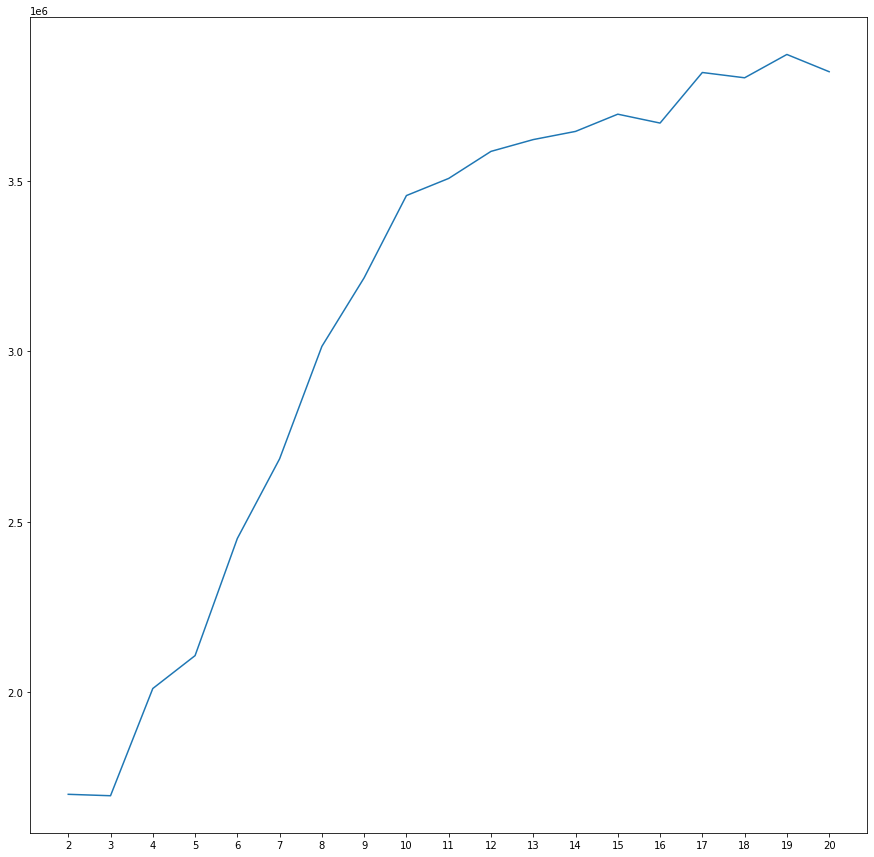

In [74]:
#Plot the line
plt.figure(figsize=(15,15))
plt.plot(Xs_4,scores_4)
plt.xticks(Xs_4)
plt.savefig("Kmeans_4.png")
plt.show()

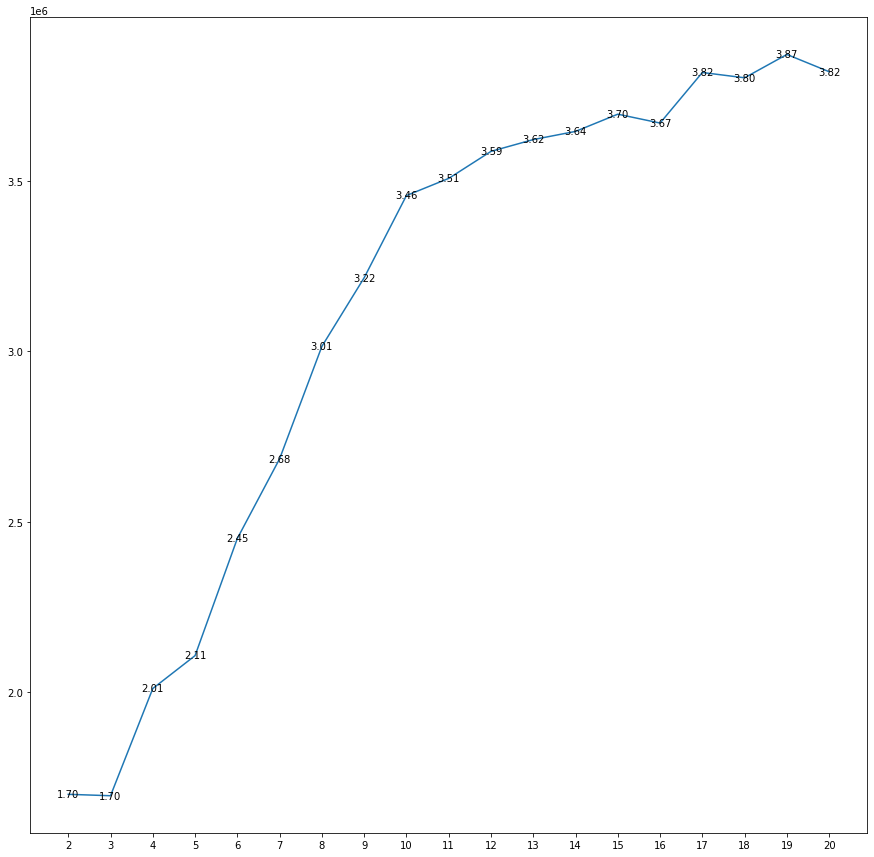

In [75]:
#With value - (looks mess)
plt.figure(figsize=(15,15))
for x,y in zip(Xs_4,scores_4):
    plt.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
plt.plot(Xs_4,scores_4)
plt.xticks(Xs_4)
plt.savefig("Kmeans_4_value.png")
plt.show()

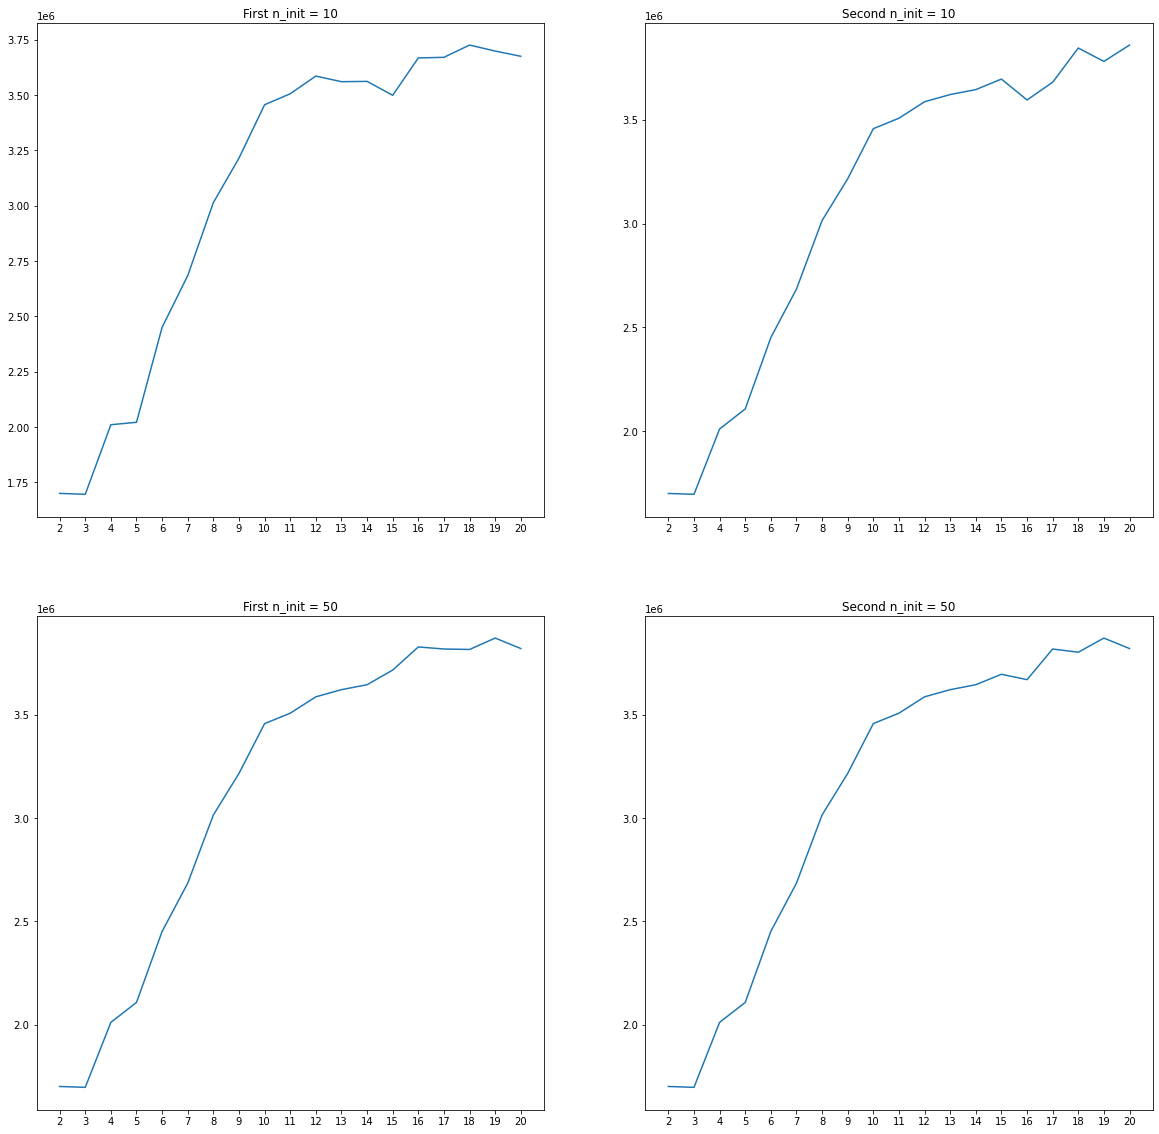

In [97]:
plt.figure(figsize = (20,20))
ax = plt.subplot(2,2,1)
ax.plot(Xs_1,scores_1)
ax.set_title("First n_init = 10")
plt.xticks(Xs_1)
ax = plt.subplot(2,2,2)
ax.plot(Xs_2,scores_2)
ax.set_title("Second n_init = 10")
plt.xticks(Xs_1)
ax = plt.subplot(2,2,3)
ax.plot(Xs_3,scores_3)
ax.set_title("First n_init = 50")
plt.xticks(Xs_1)
ax = plt.subplot(2,2,4)
ax.plot(Xs_4,scores_4)
ax.set_title("Second n_init = 50")
plt.xticks(Xs_1)
plt.savefig("combined.png")
plt.show()

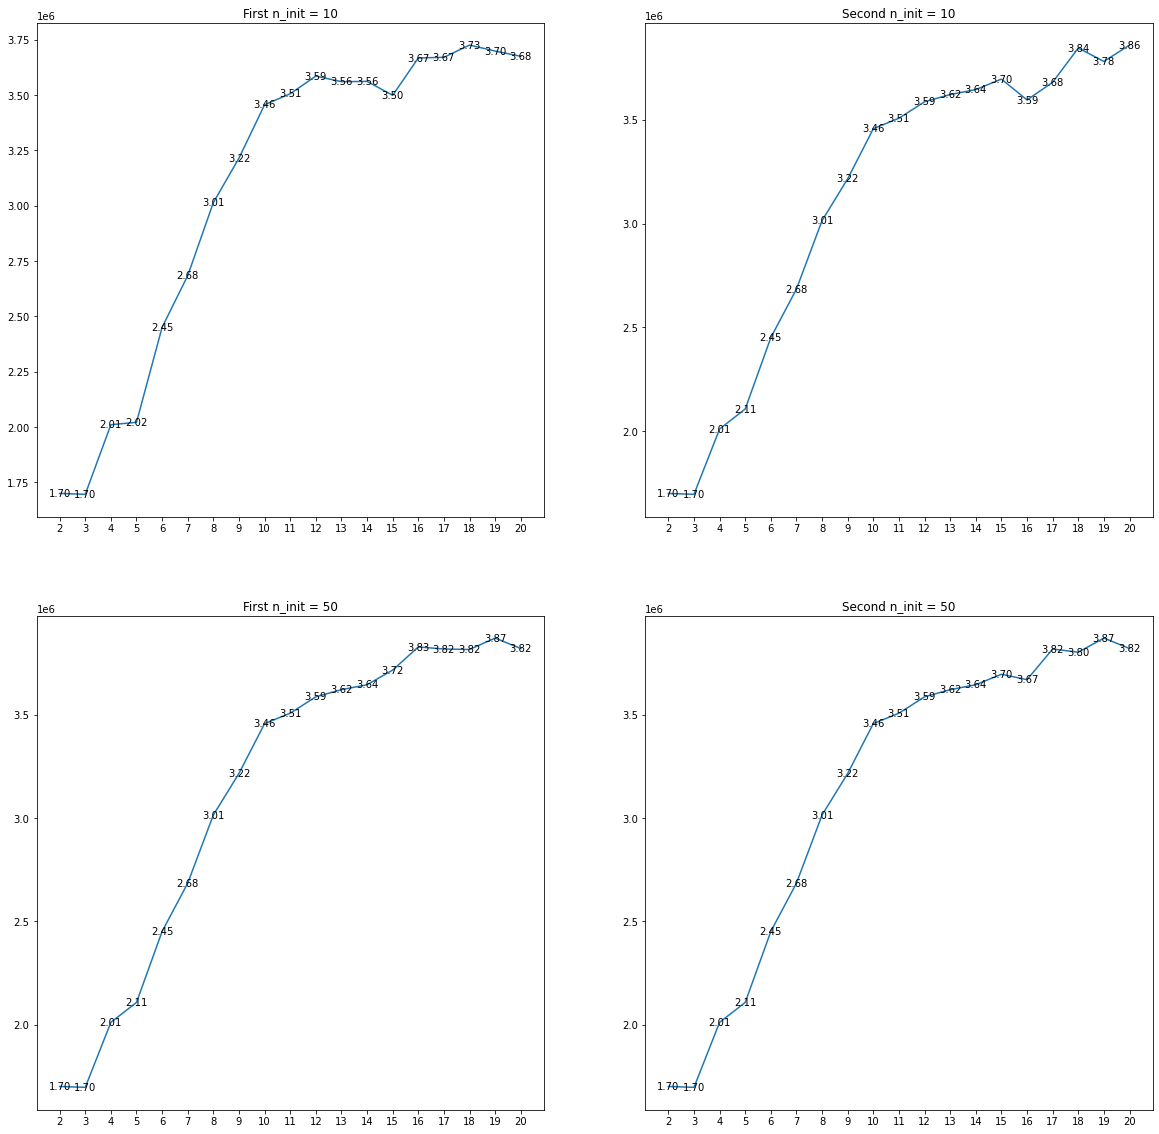

In [96]:
plt.figure(figsize = (20,20))
ax = plt.subplot(2,2,1)
for x,y in zip(Xs_1,scores_1):
    ax.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
ax.plot(Xs_1,scores_1)
plt.xticks(Xs_1)
ax.set_title("First n_init = 10")
ax = plt.subplot(2,2,2)
for x,y in zip(Xs_2,scores_2):
    ax.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
ax.plot(Xs_2,scores_2)
plt.xticks(Xs_1)
ax.set_title("Second n_init = 10")
ax = plt.subplot(2,2,3)
for x,y in zip(Xs_3,scores_3):
    ax.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
ax.plot(Xs_3,scores_3)
plt.xticks(Xs_1)
ax.set_title("First n_init = 50")
ax = plt.subplot(2,2,4)
for x,y in zip(Xs_4,scores_4):
    ax.text(x,y,'%.2f'%(y*0.000001),ha='center',va='center')
ax.plot(Xs_4,scores_4)
ax.set_title("Second n_init = 50")
plt.xticks(Xs_1)
plt.savefig("combined_value.png")
plt.show()

### Distribution plotting
According to the results upwards, I think n_cluster = 19 & n_init = 50 may be considered as the best

In [10]:
kmeans_4.n_clusters = 19
kmeans_4.fit(X_train_temp)

KMeans(n_clusters=19, n_init=50, random_state=40)

In [28]:
def plot_distributions(X_train_temp,y_train_temp,kmeans,n_clusters):
    
    #Maintain the original data
    X_train_temp = X_train_temp.copy()
    y_train_temp = y_train_temp.copy()
        
    #Get the score
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    
    #Add cluster columns
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    
    #Get the average WPP
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Show plots for each cluster
    for n in range(n_clusters):
        
        #Get the Xs with cluster == n
        X_temp_train = X_train_temp[X_train_temp["cluster"] == n]
        
        #Delete the cluster column
        X_temp_train = X_temp_train.drop(["cluster"],axis=1) 
        
        #Get the ys with cluster == n
        y_temp_train = y_train_temp[y_train_temp["cluster"]==n]
        
        #Delete the cluster column
        y_temp_train = y_temp_train.drop(["cluster"],axis=1) 
        
        #New whole training set
        temp_train = pd.concat([X_temp_train,y_temp_train],axis=1)
        
        #Delete the match type columns
        cols = [c for c in temp_train.columns if c.lower()[:9] != 'matchtype']
        temp_train = temp_train[cols]
        
        print("Cluster "+str(n+1)+", average wpp = "+str(average_Wpp[n]))
        
        #Plot the histogram
        ax_hist = temp_train.hist(bins=50, layout=(5,5),figsize=(15, 15),log=True)
        for x in range(ax_hist.shape[0]):
            for y in range(ax_hist.shape[1]):
                ax_hist[x][y].set_xlim((0,1))
        plt.show()
        
        #Plot the box plots
        temp_train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(15, 15))
        plt.show()

Cluster 1, average wpp = 0.656753292758325


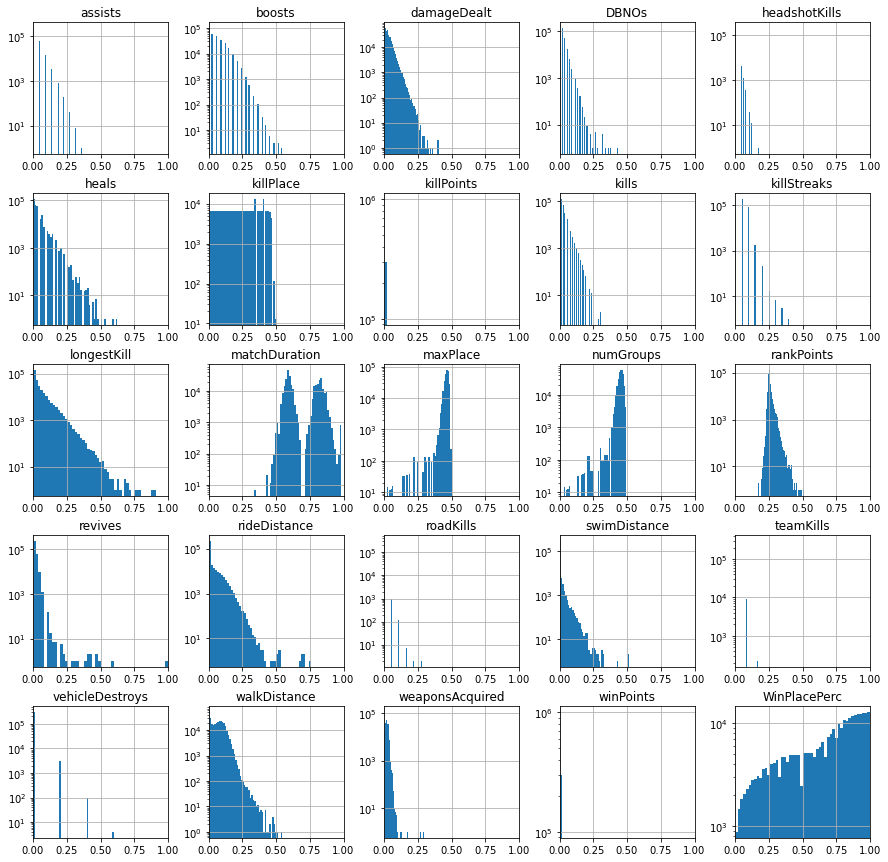

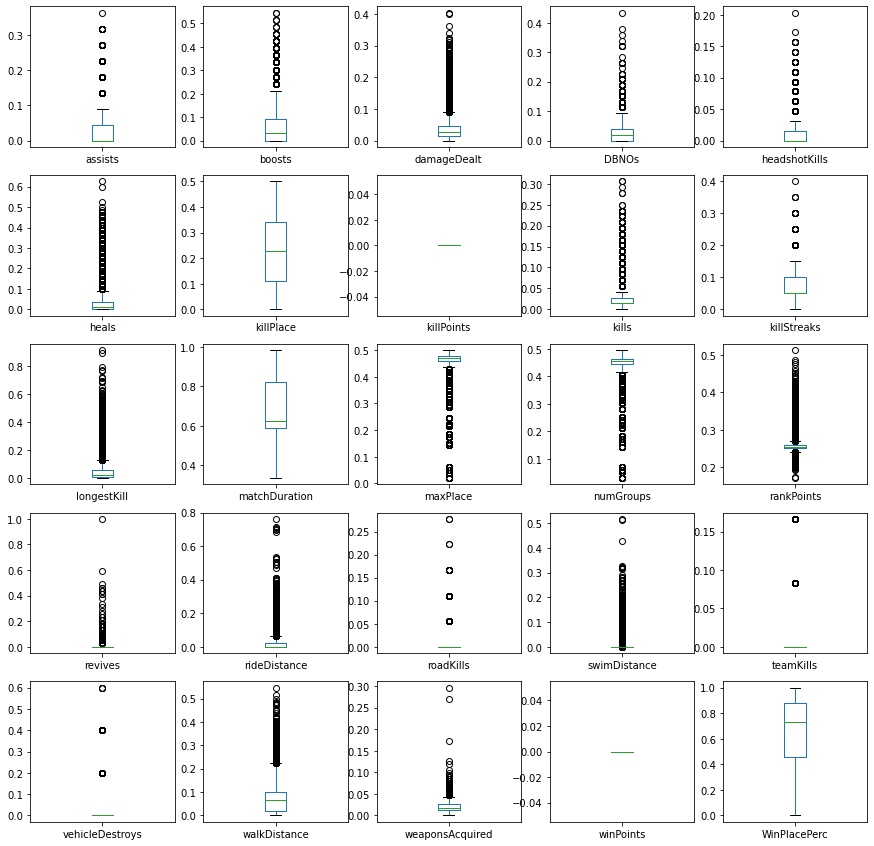

Cluster 2, average wpp = 0.453058954668619


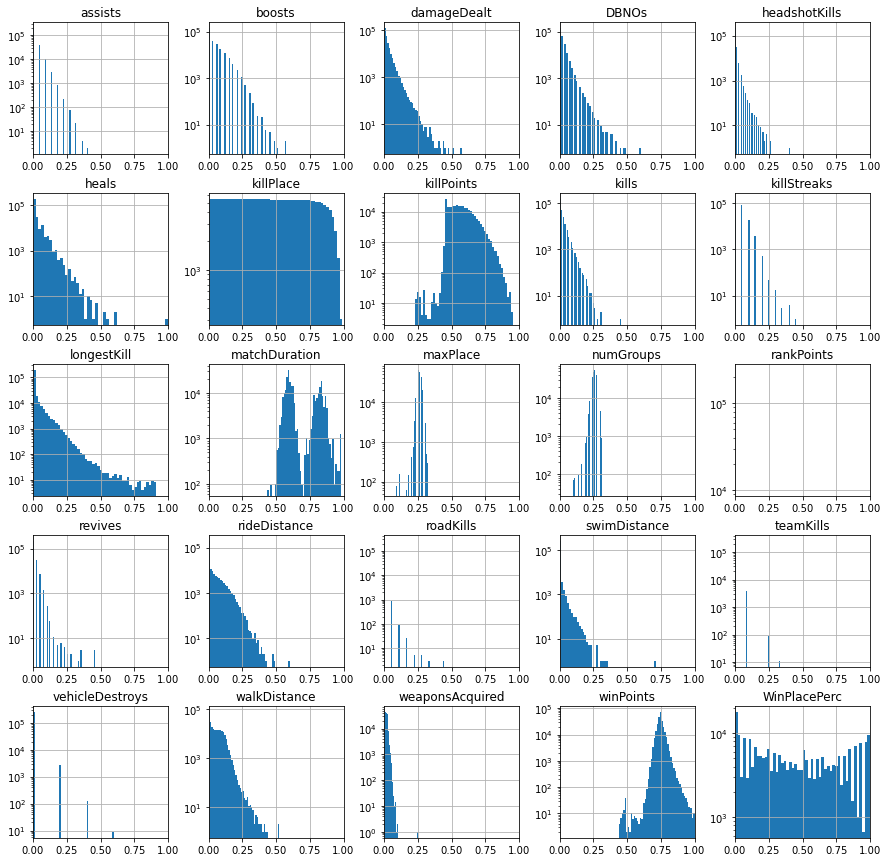

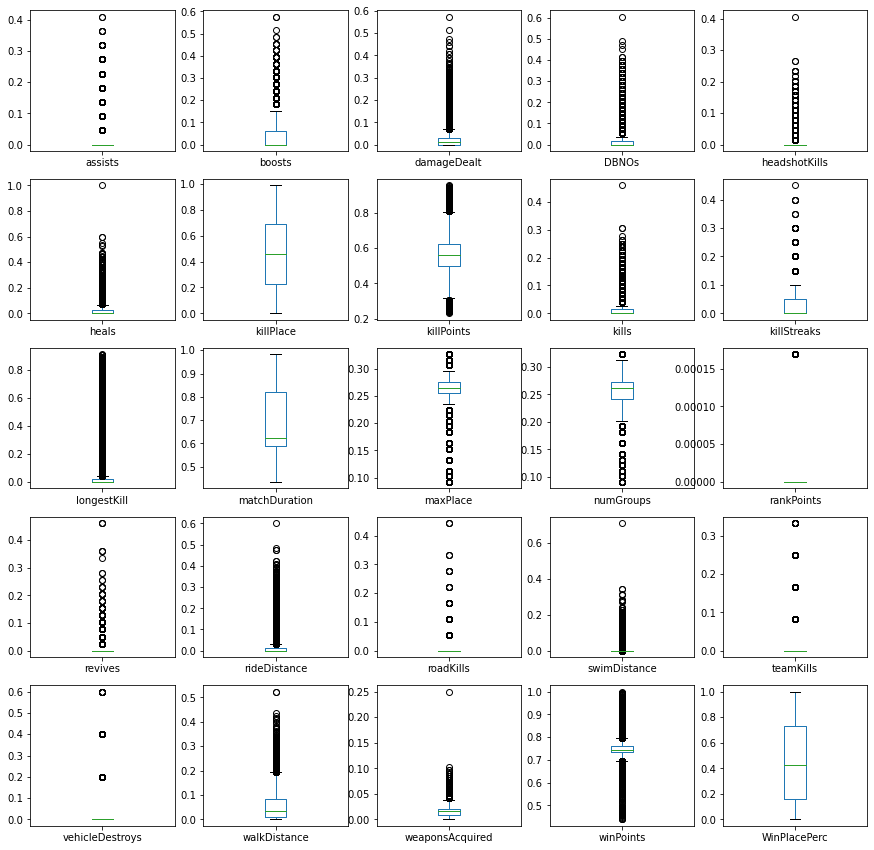

Cluster 3, average wpp = 0.3060793405062617


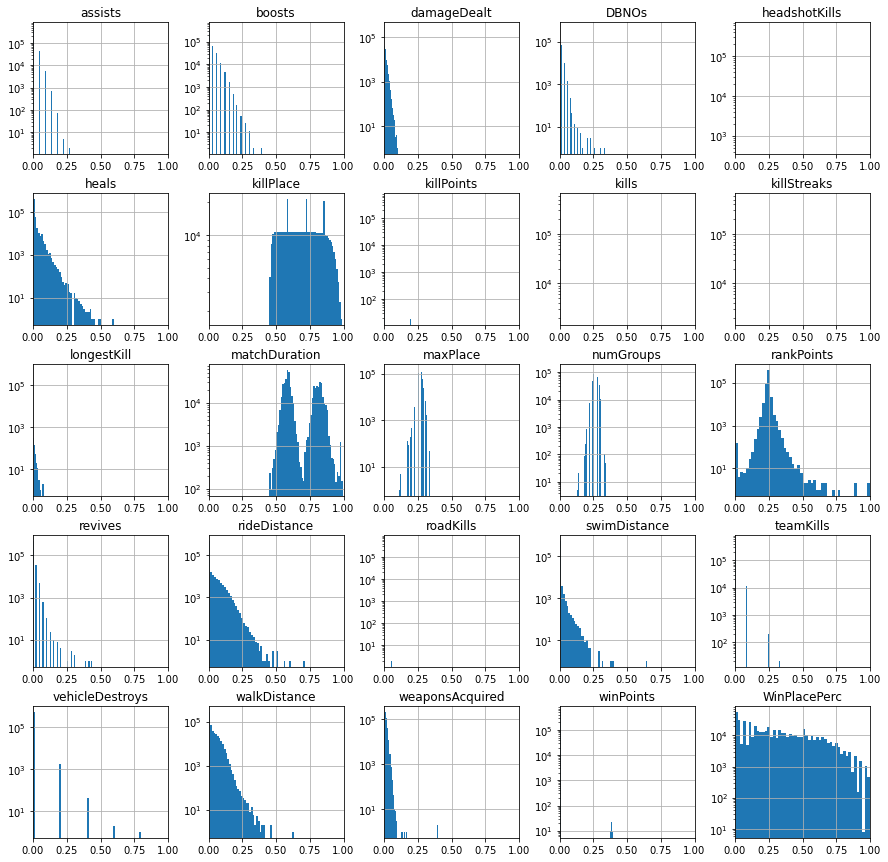

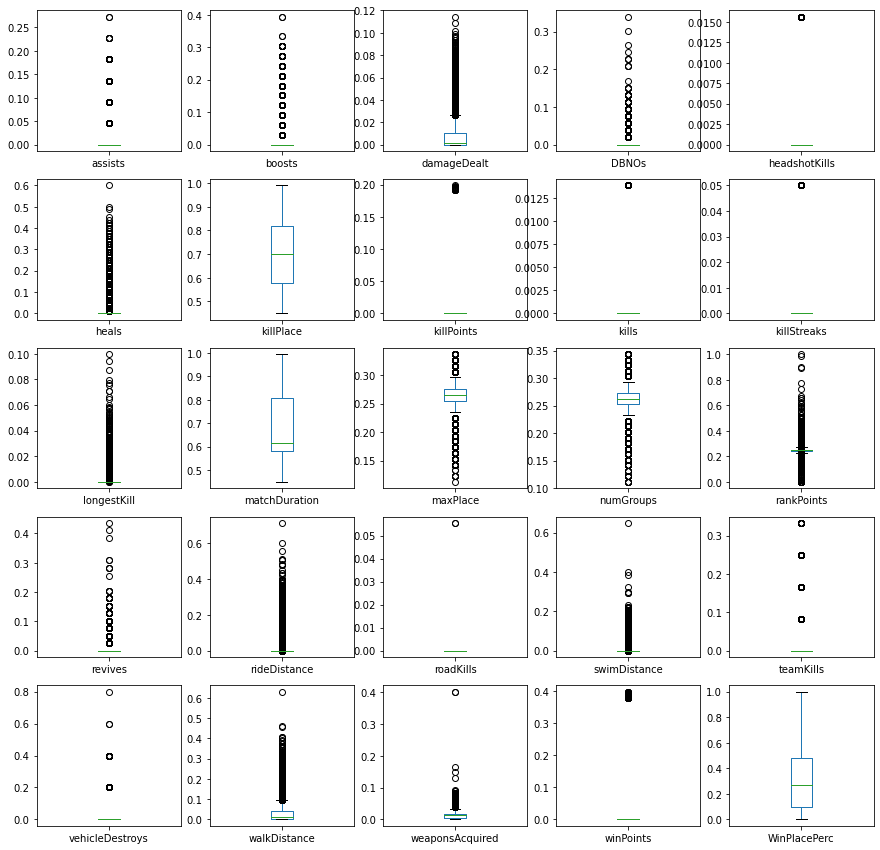

Cluster 4, average wpp = 0.6646793449459963


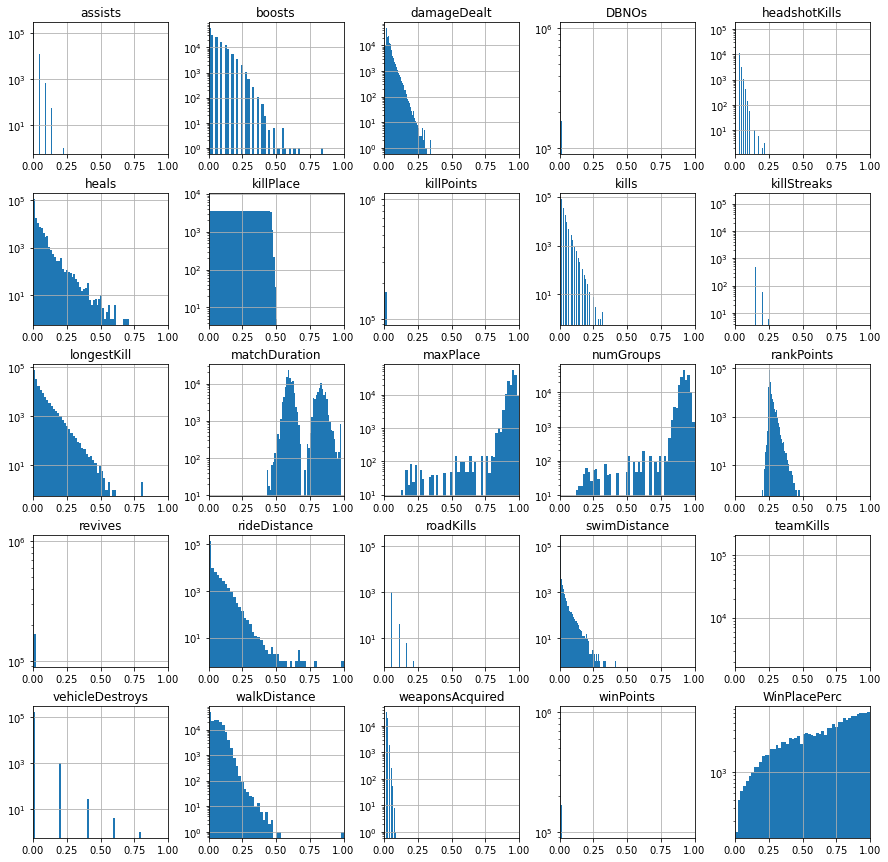

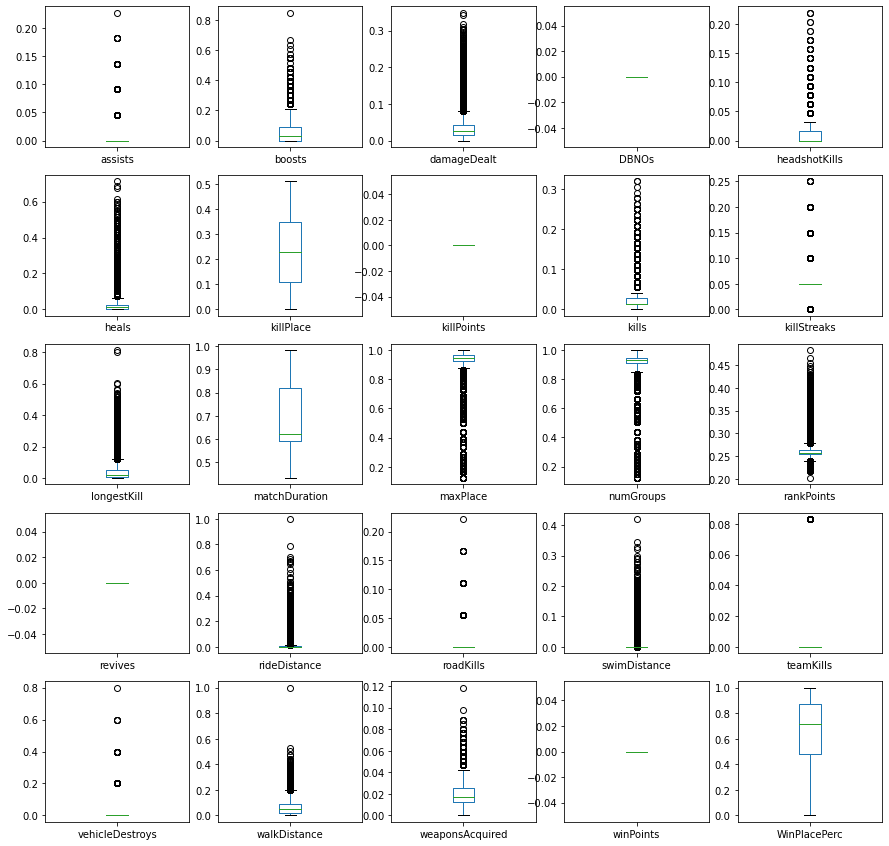

Cluster 5, average wpp = 0.6507694743994277


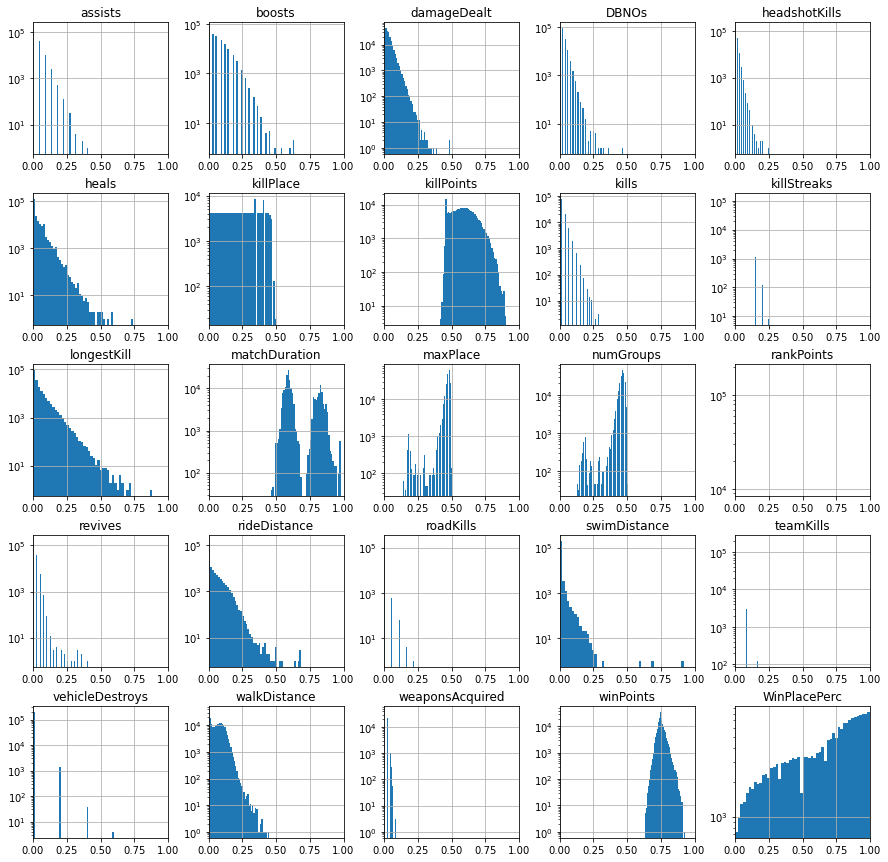

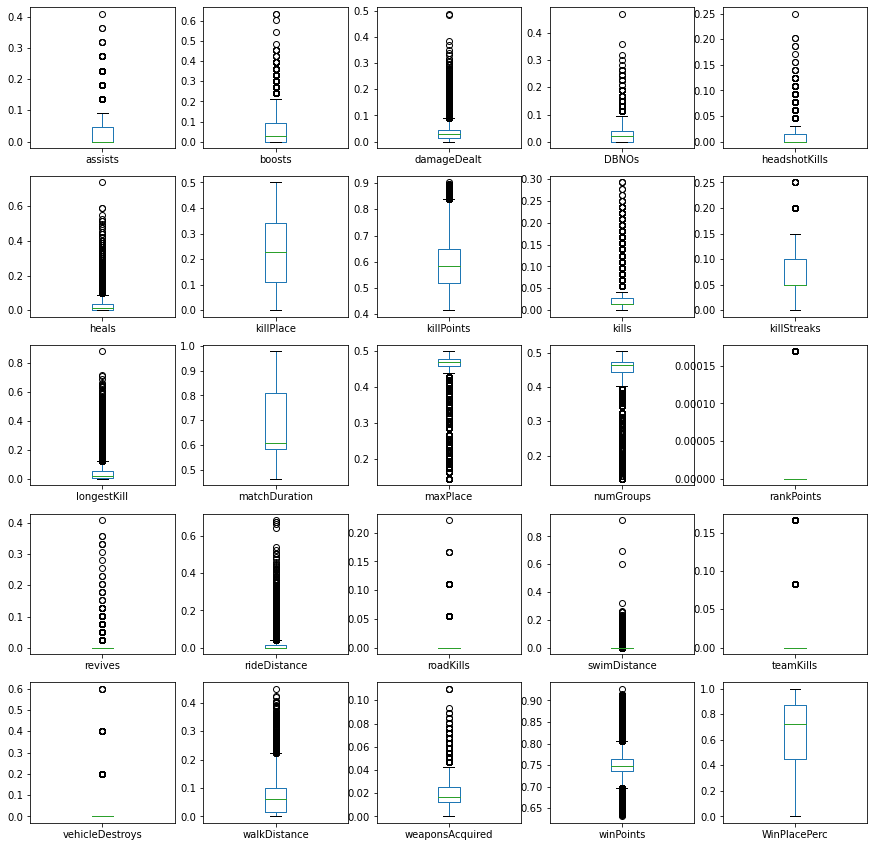

Cluster 6, average wpp = 0.31184862355548515


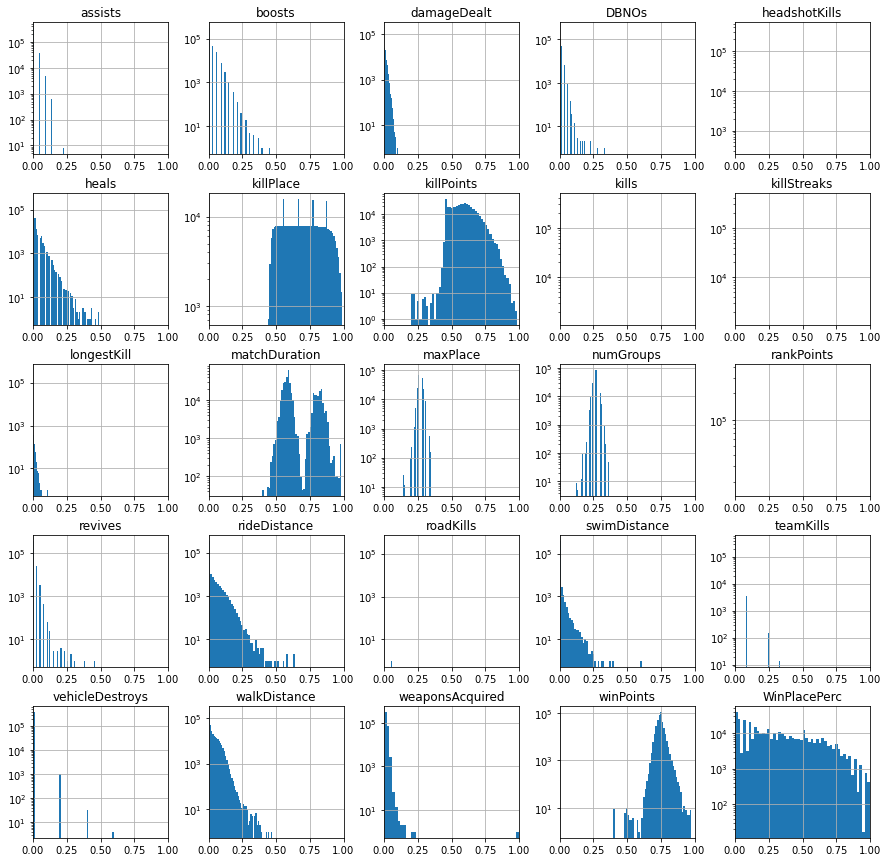

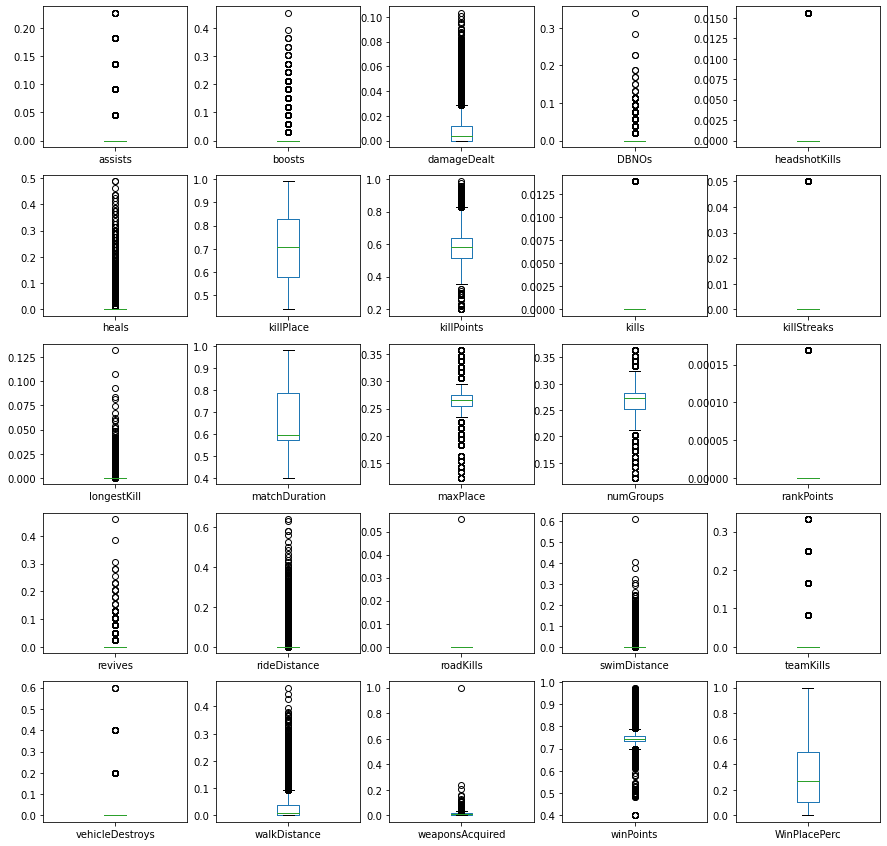

Cluster 7, average wpp = 0.48740827887074395


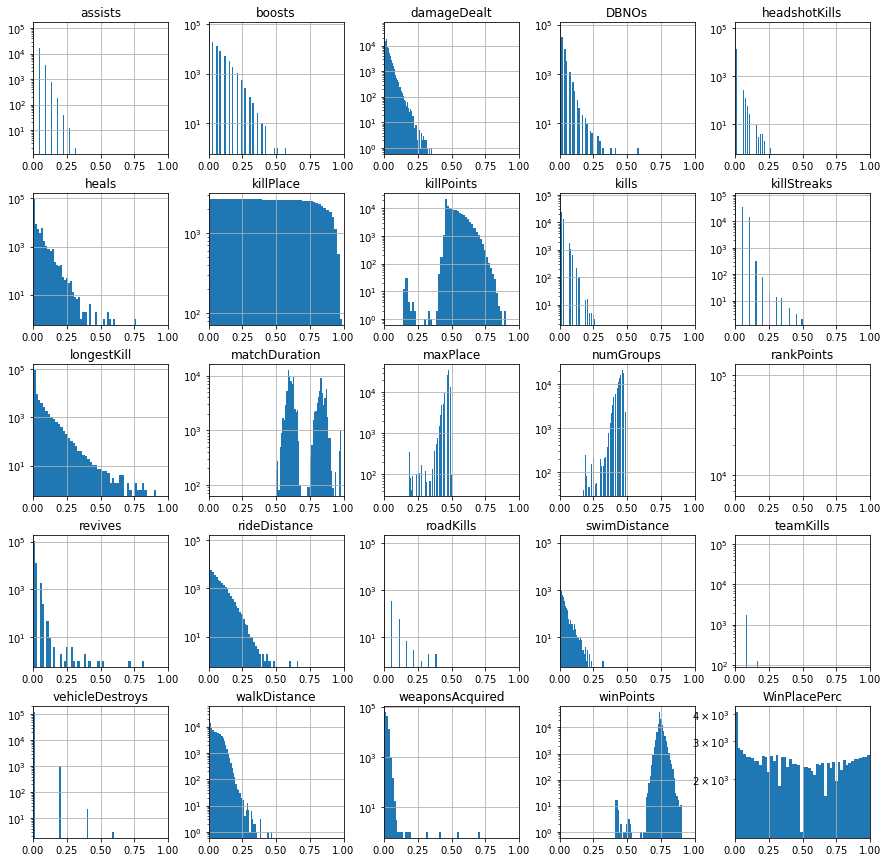

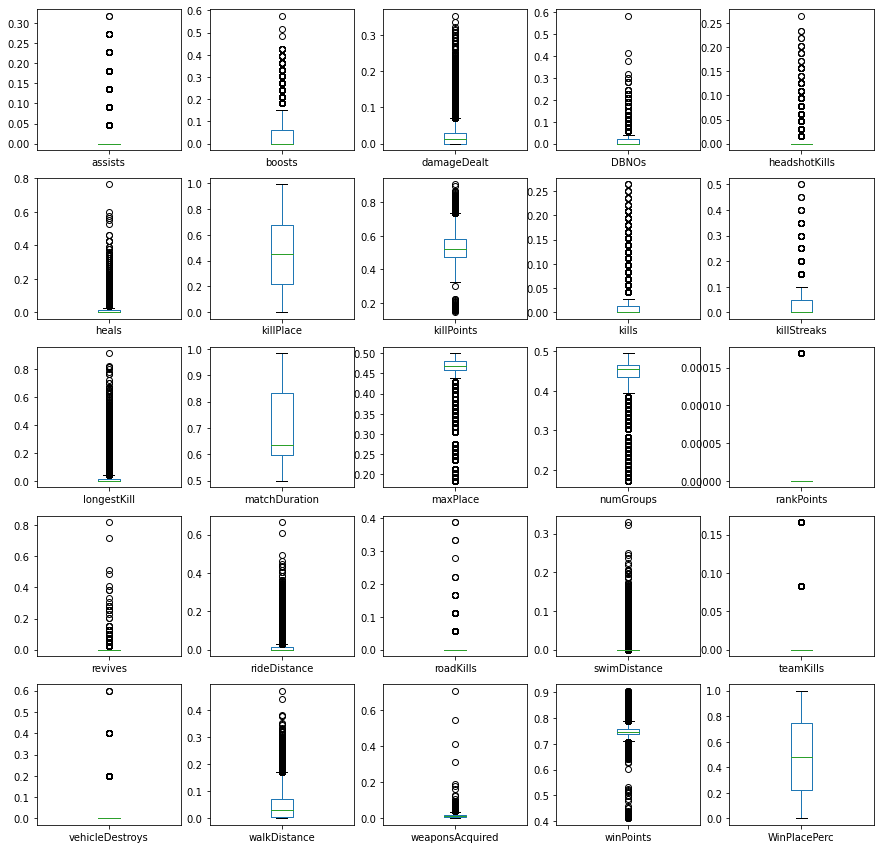

Cluster 8, average wpp = 0.4634041333696059


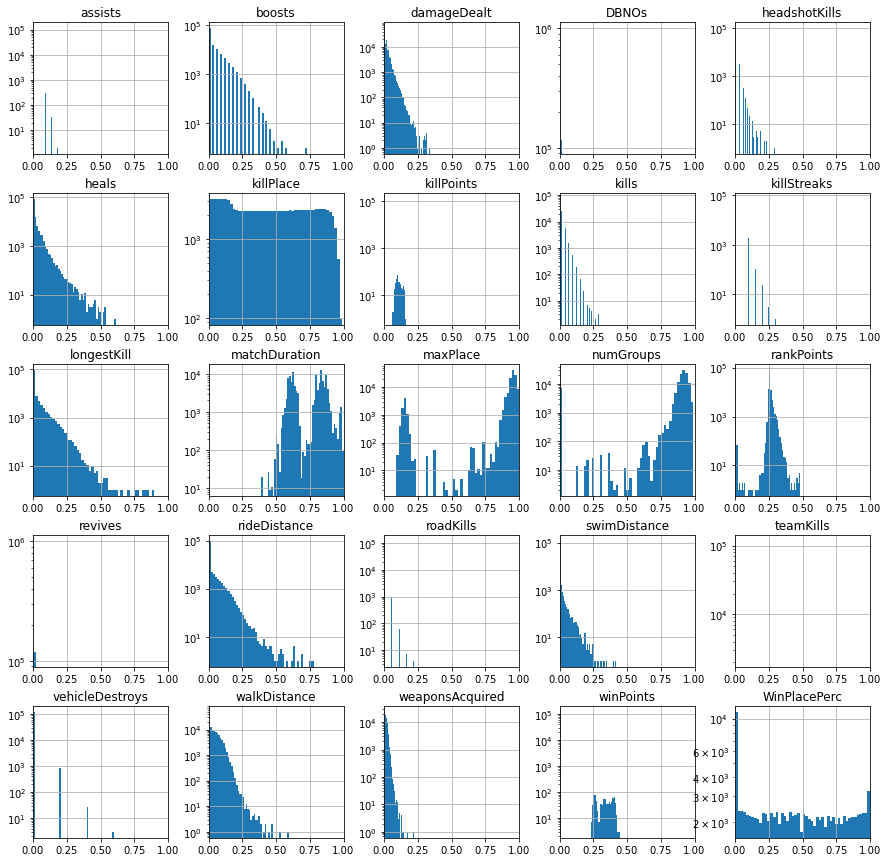

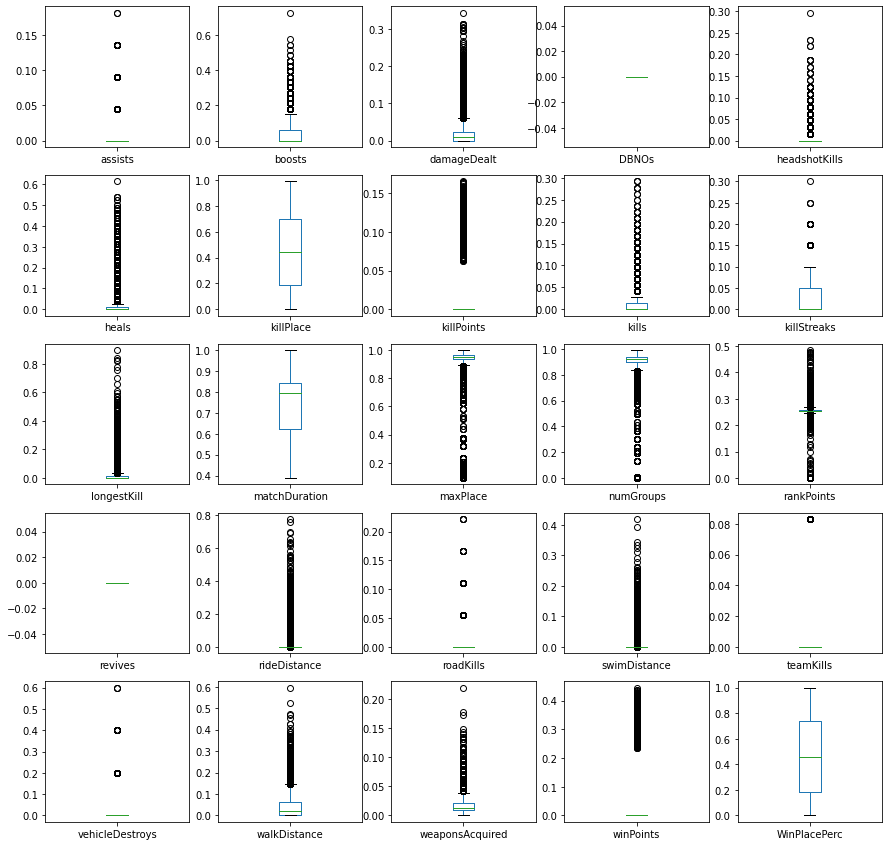

Cluster 9, average wpp = 0.6200462103107325


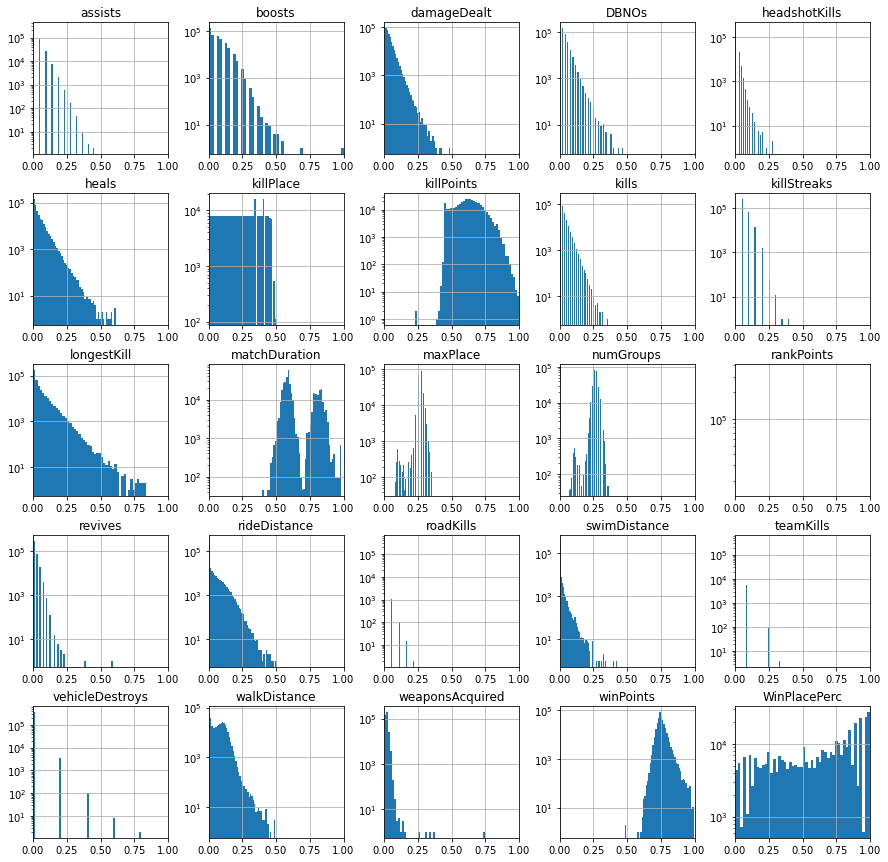

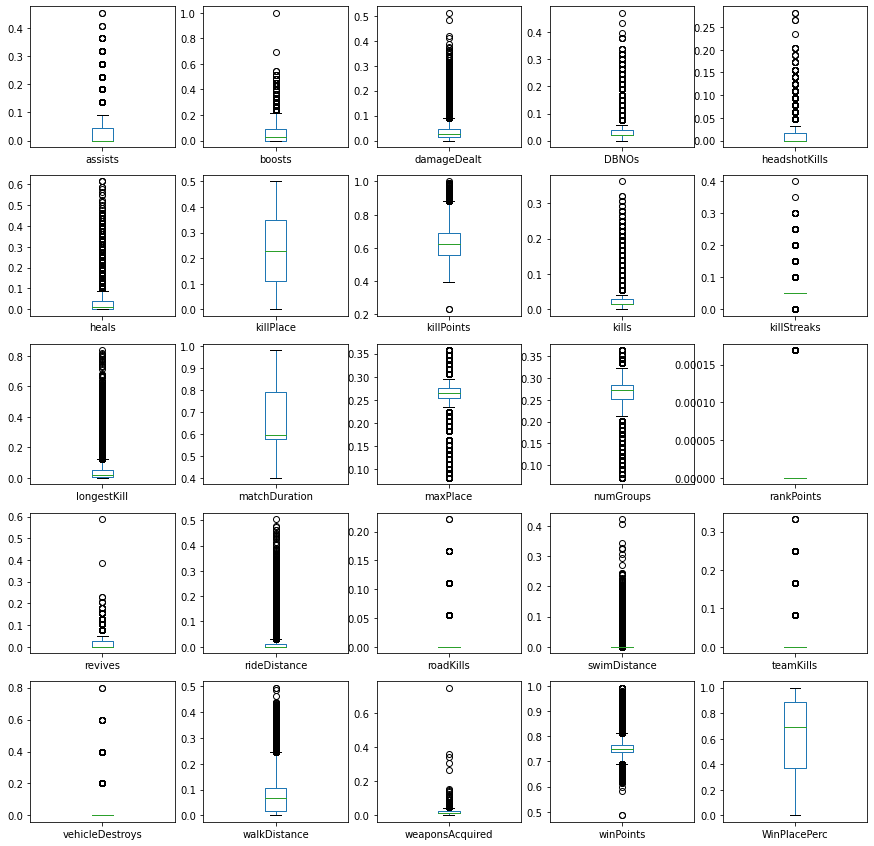

Cluster 10, average wpp = 0.6228918852551104


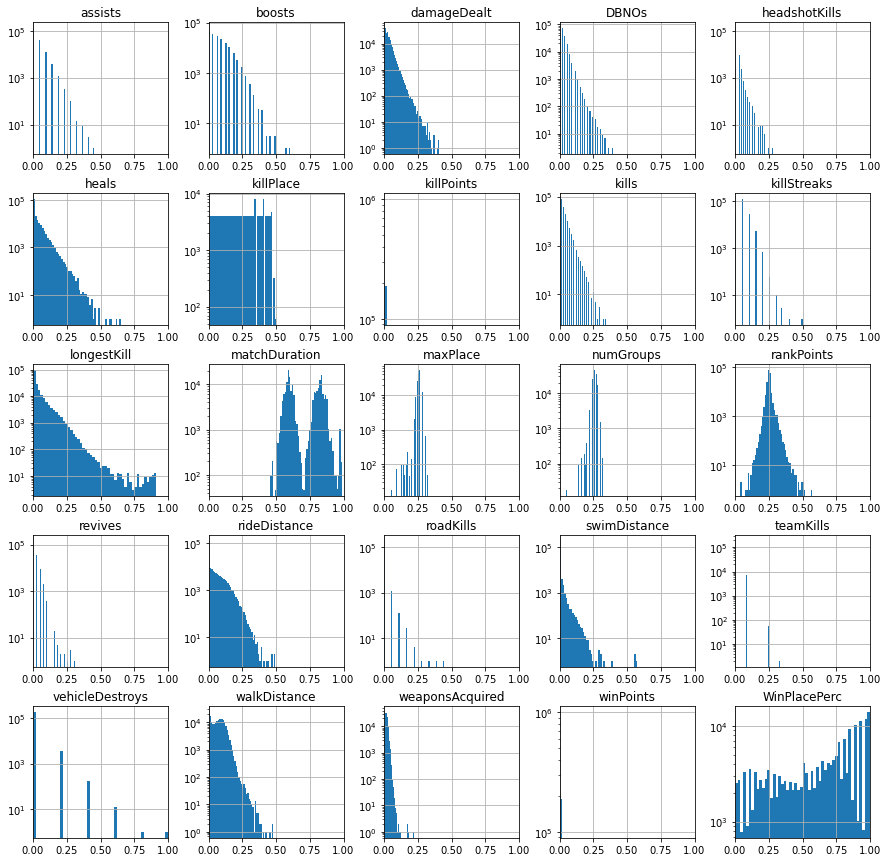

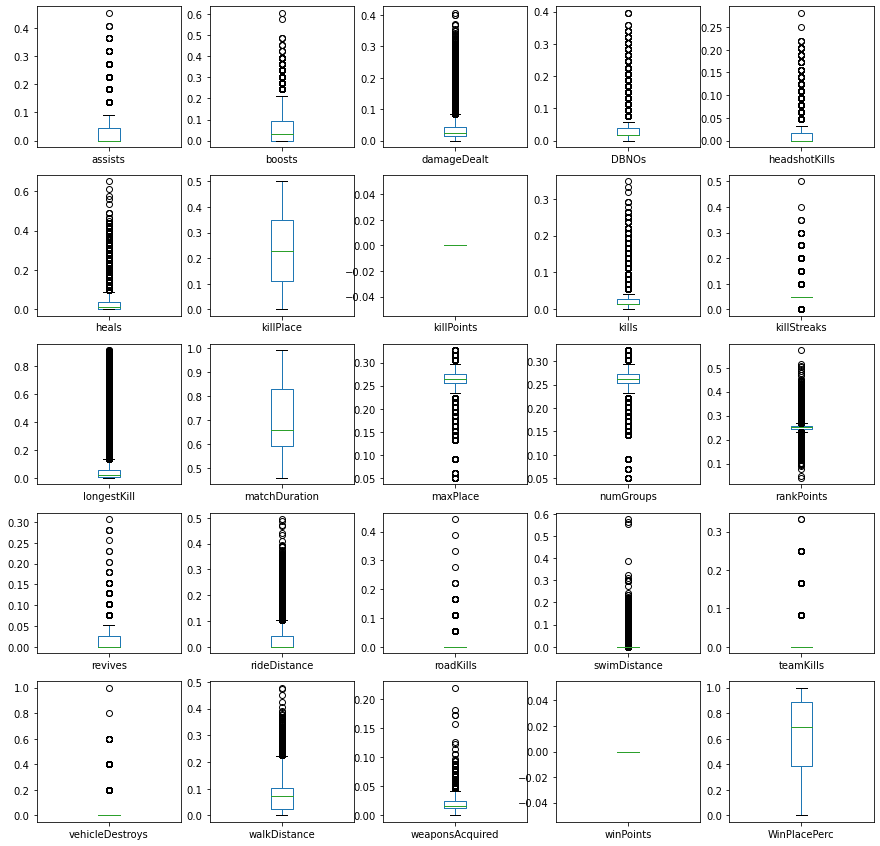

Cluster 11, average wpp = 0.49211723771620086


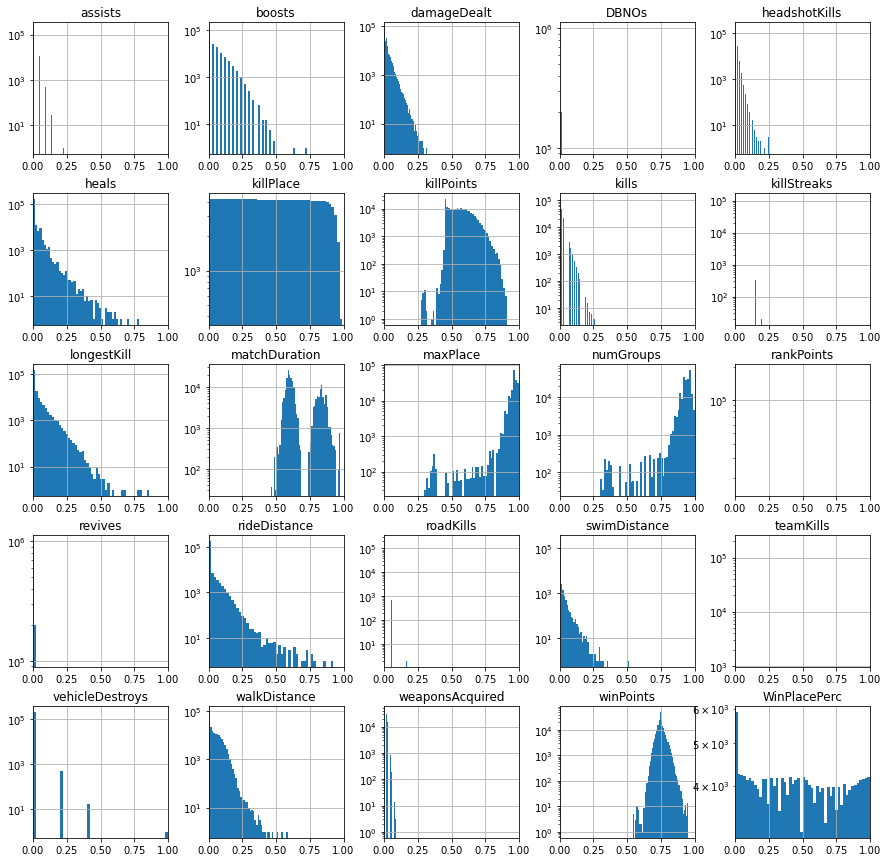

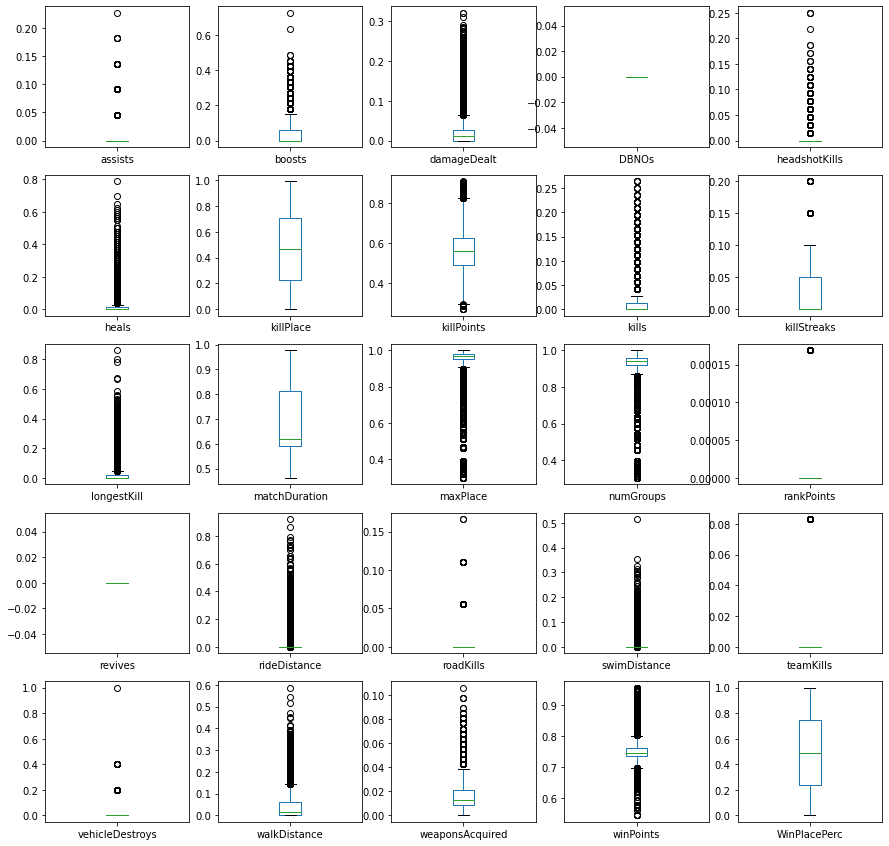

Cluster 12, average wpp = 0.4799193578326982


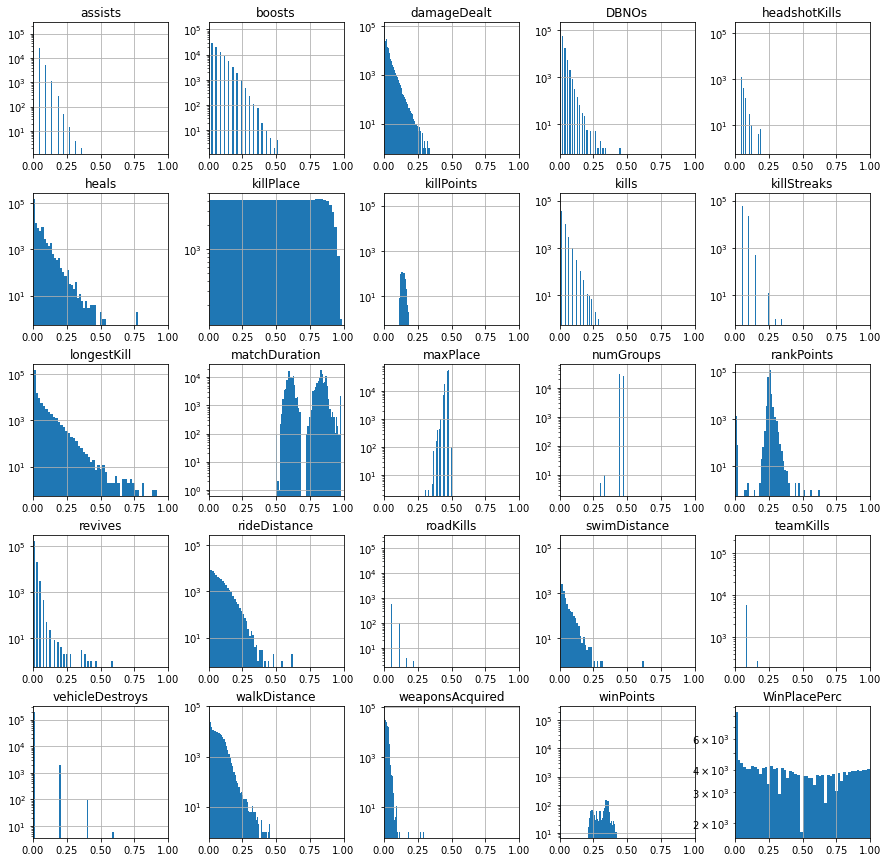

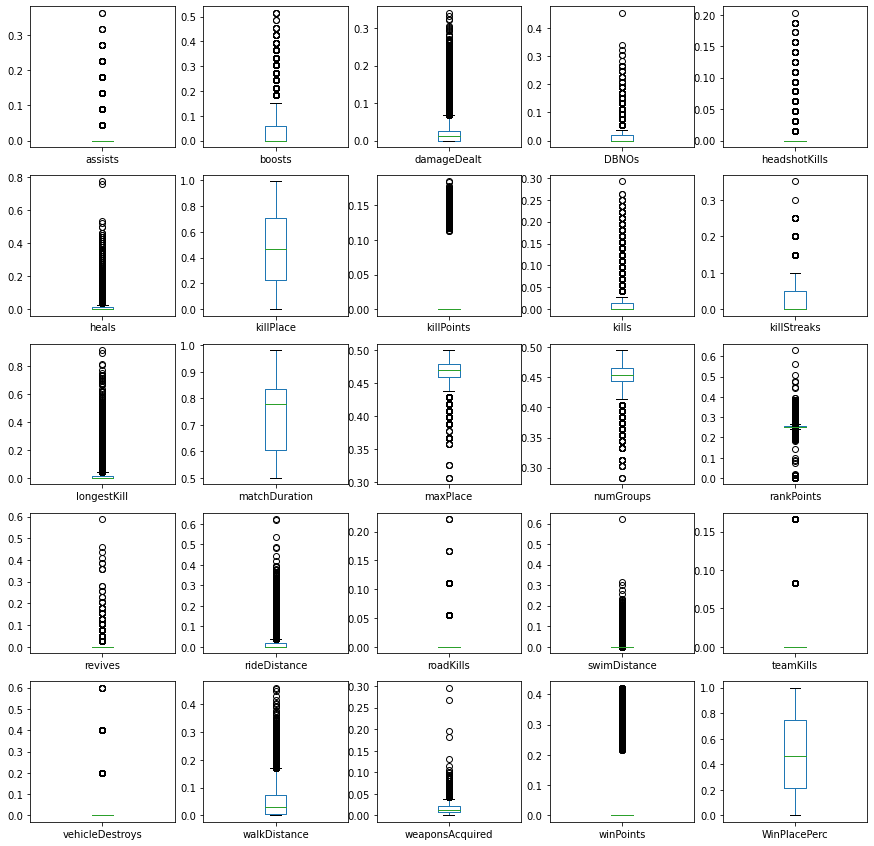

Cluster 13, average wpp = 0.4952978701107429


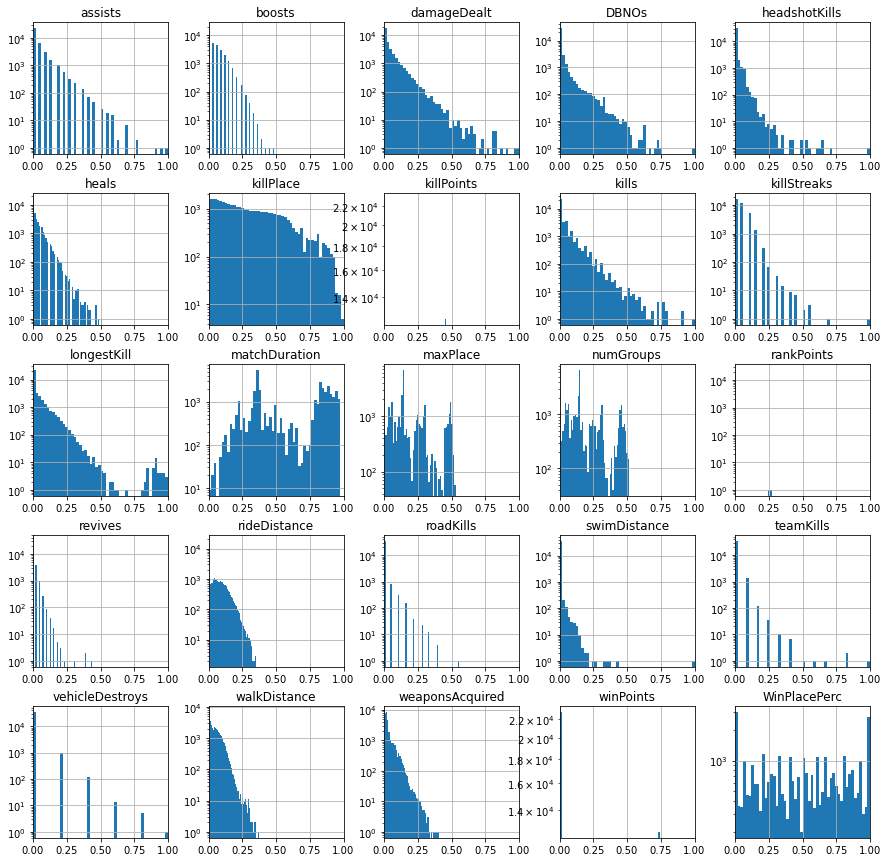

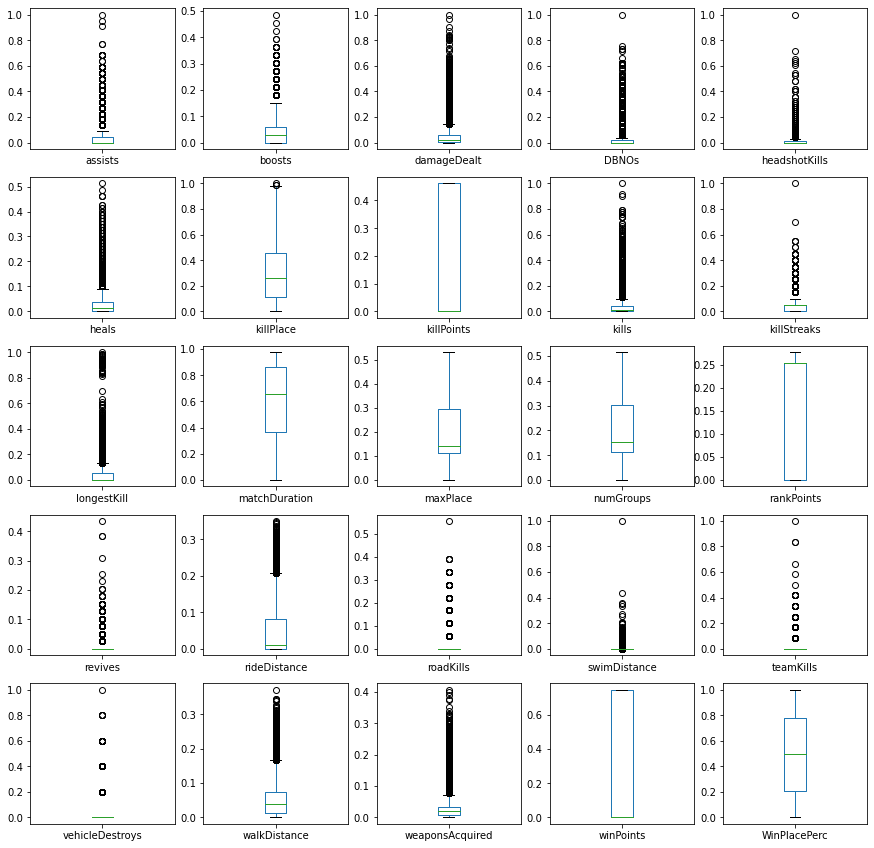

Cluster 14, average wpp = 0.4930989592893922


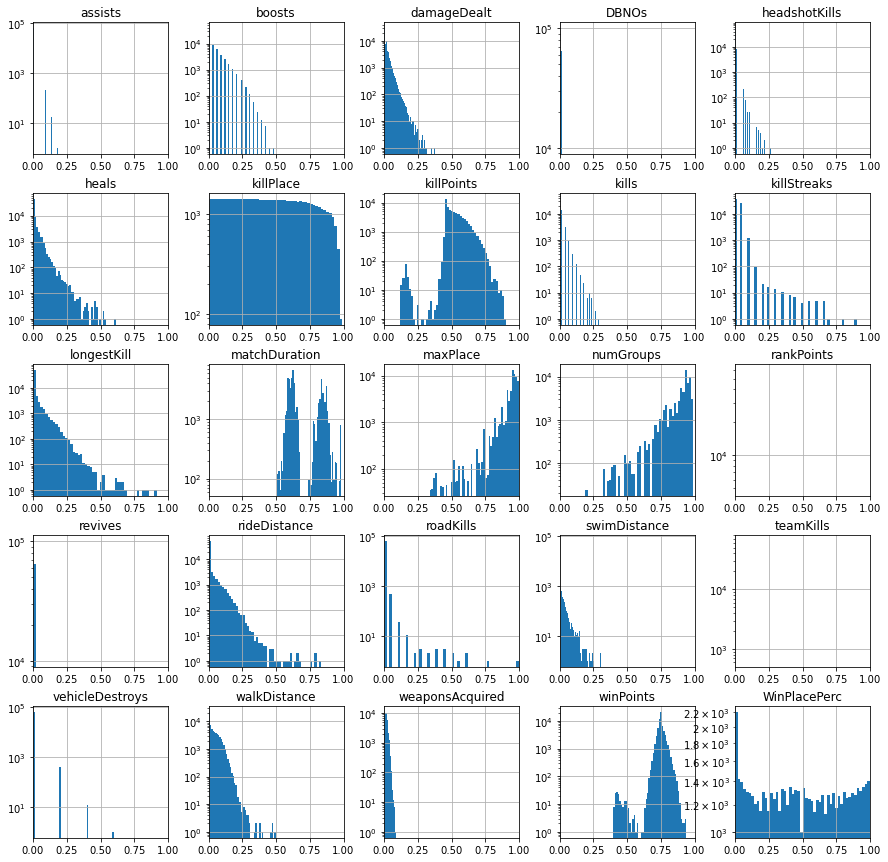

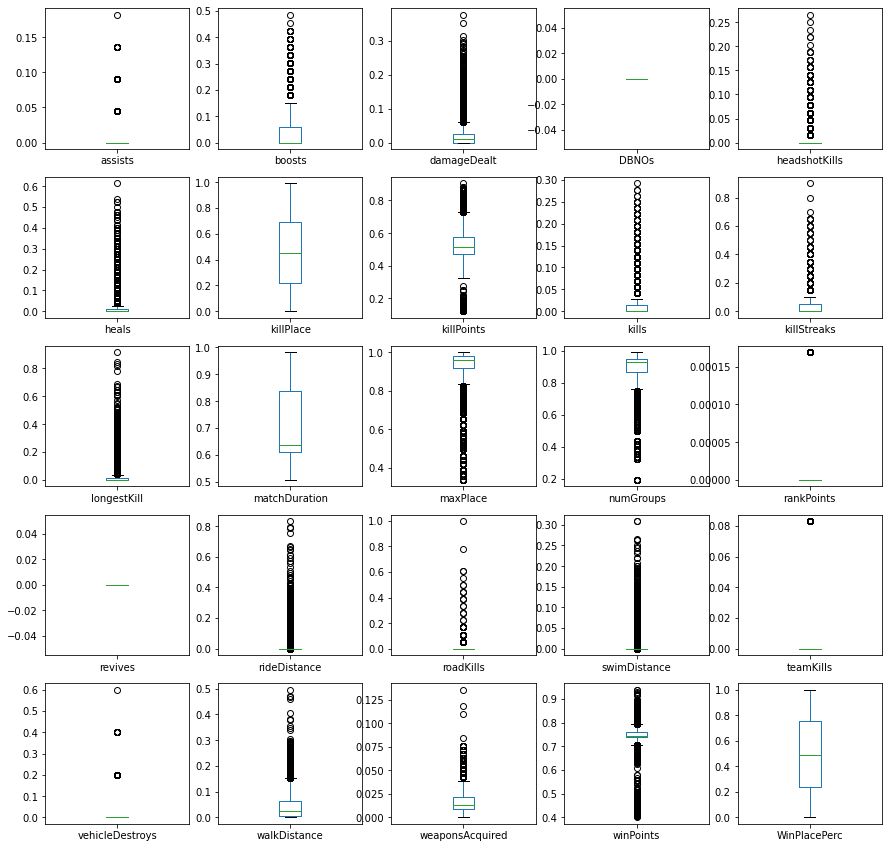

Cluster 15, average wpp = 0.3243992752446304


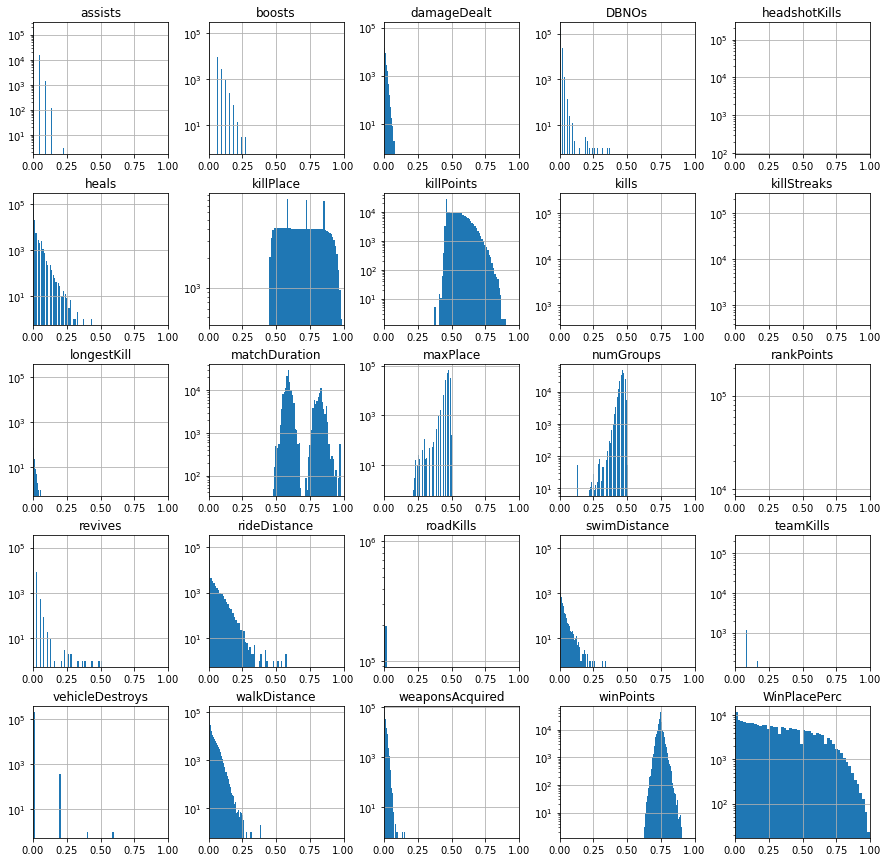

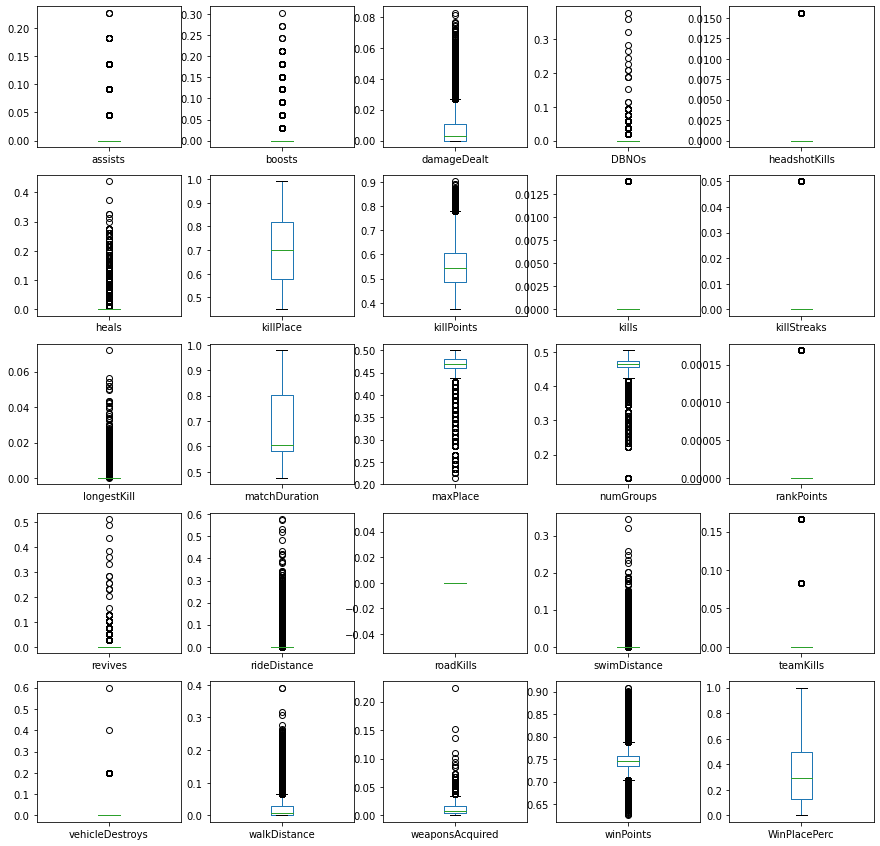

Cluster 16, average wpp = 0.3161151009377955


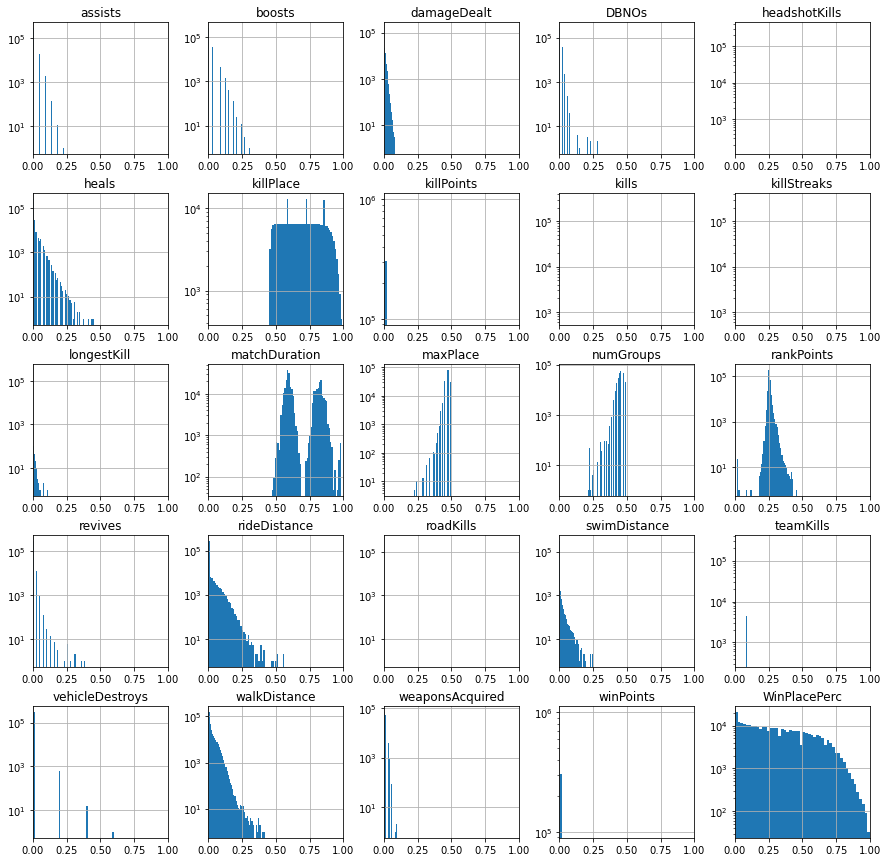

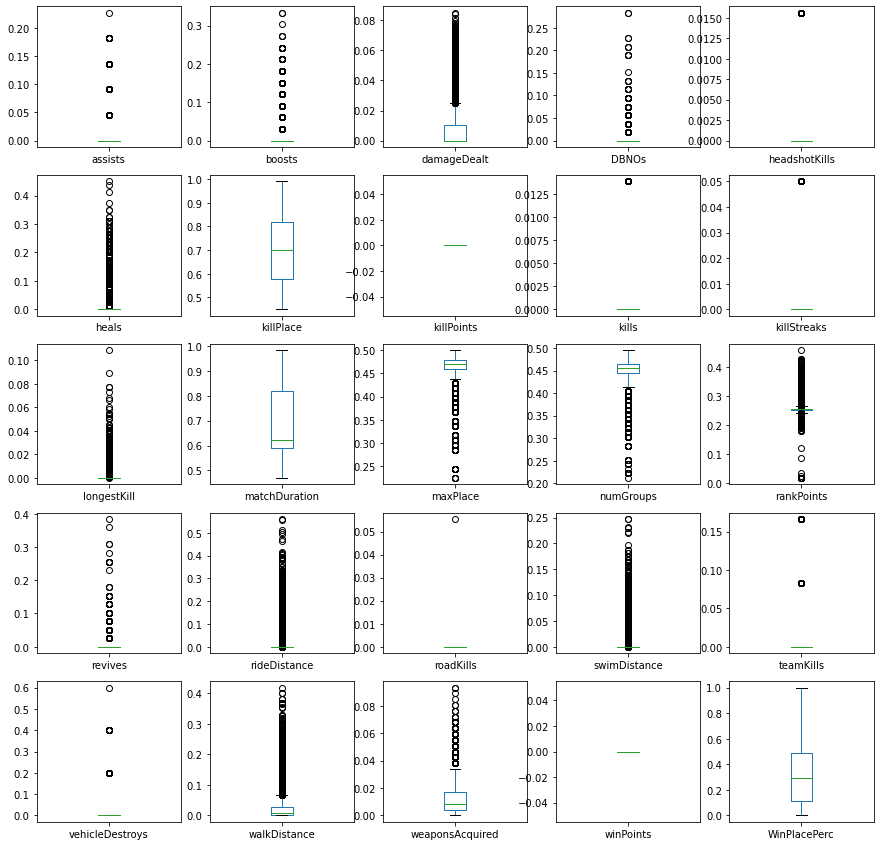

Cluster 17, average wpp = 0.3182437384991931


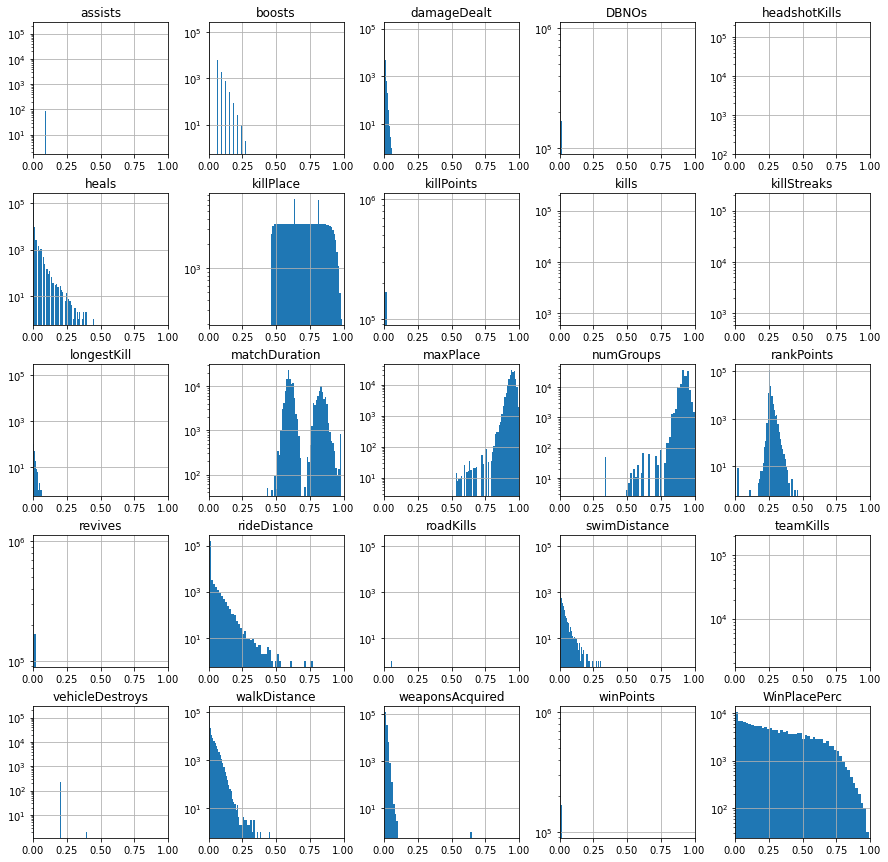

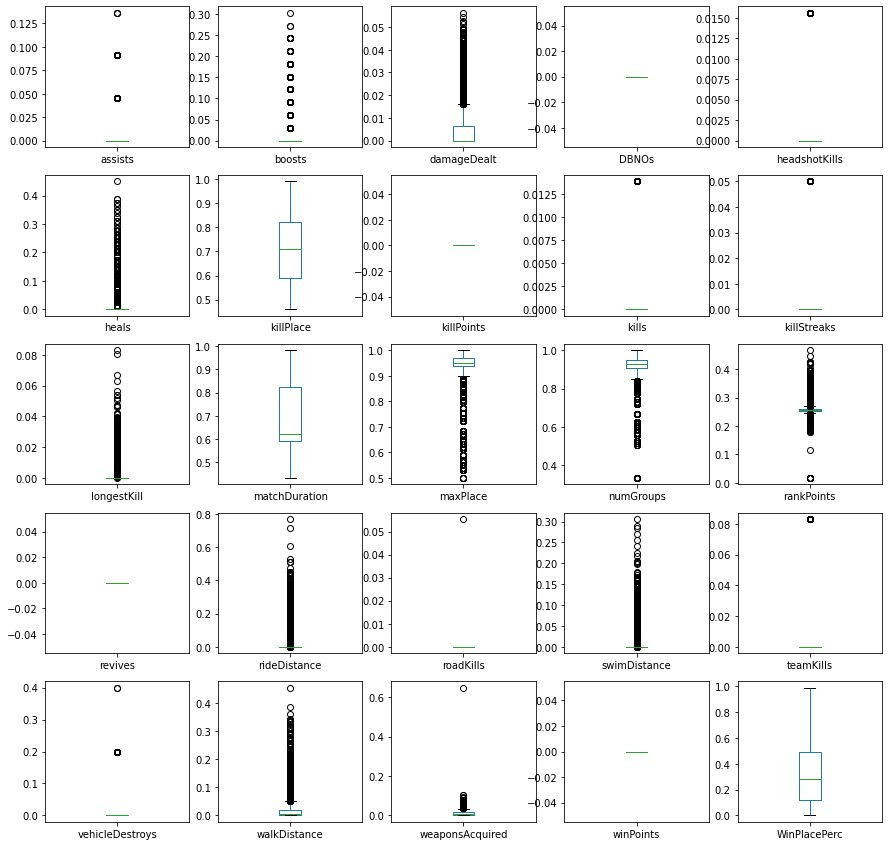

Cluster 18, average wpp = 0.28062441576375613


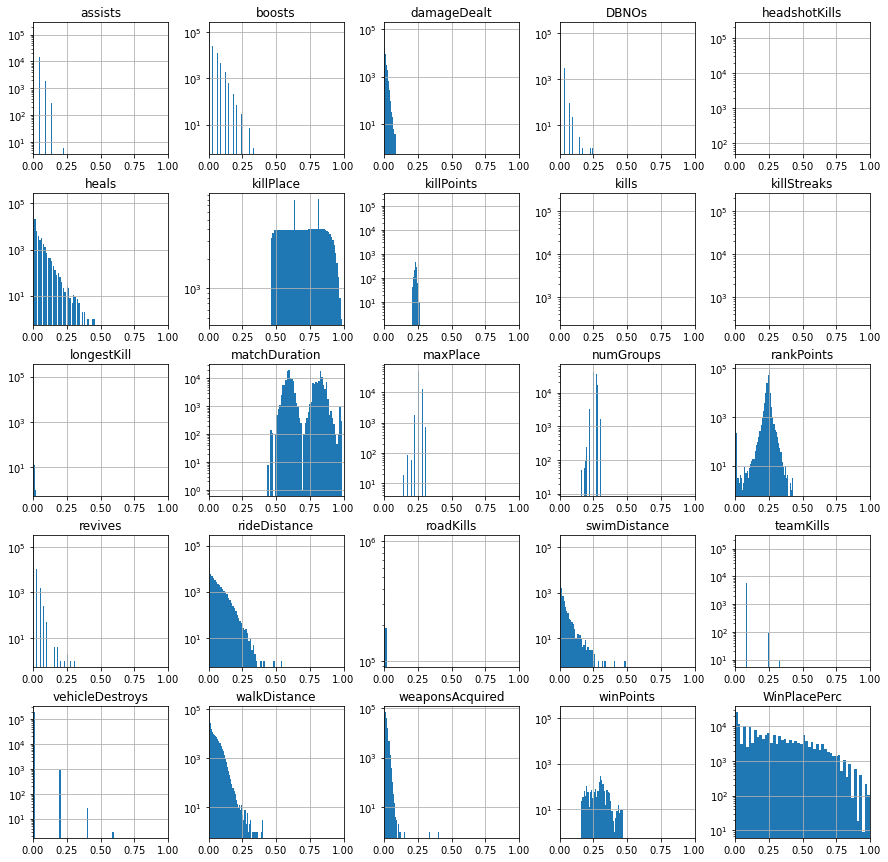

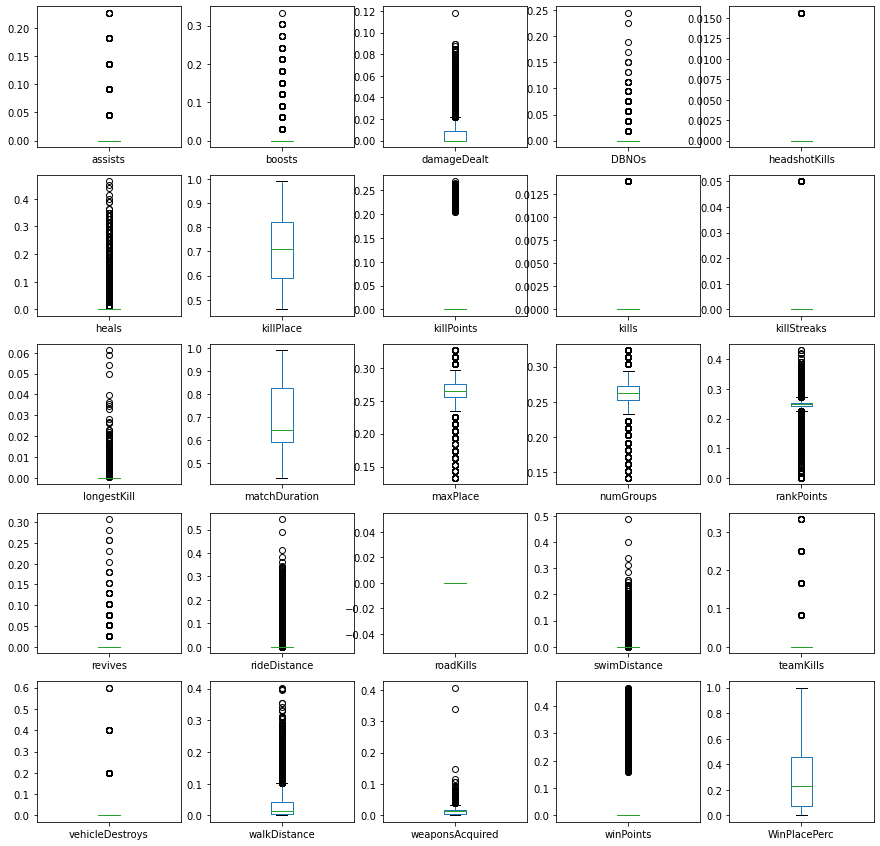

Cluster 19, average wpp = 0.6264854869764885


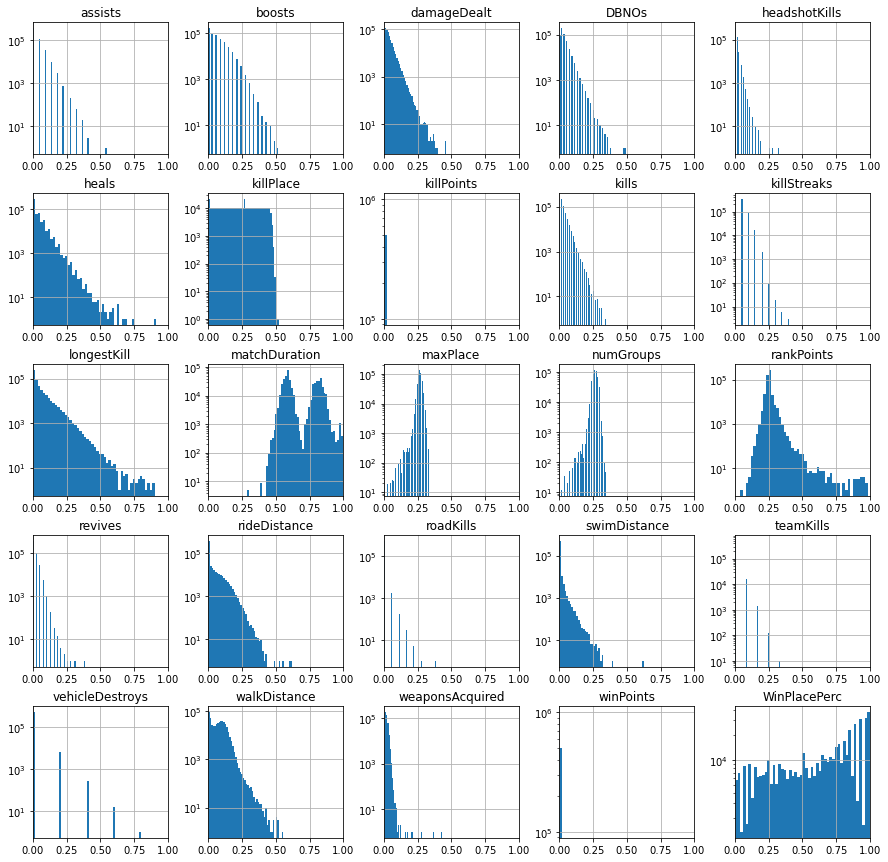

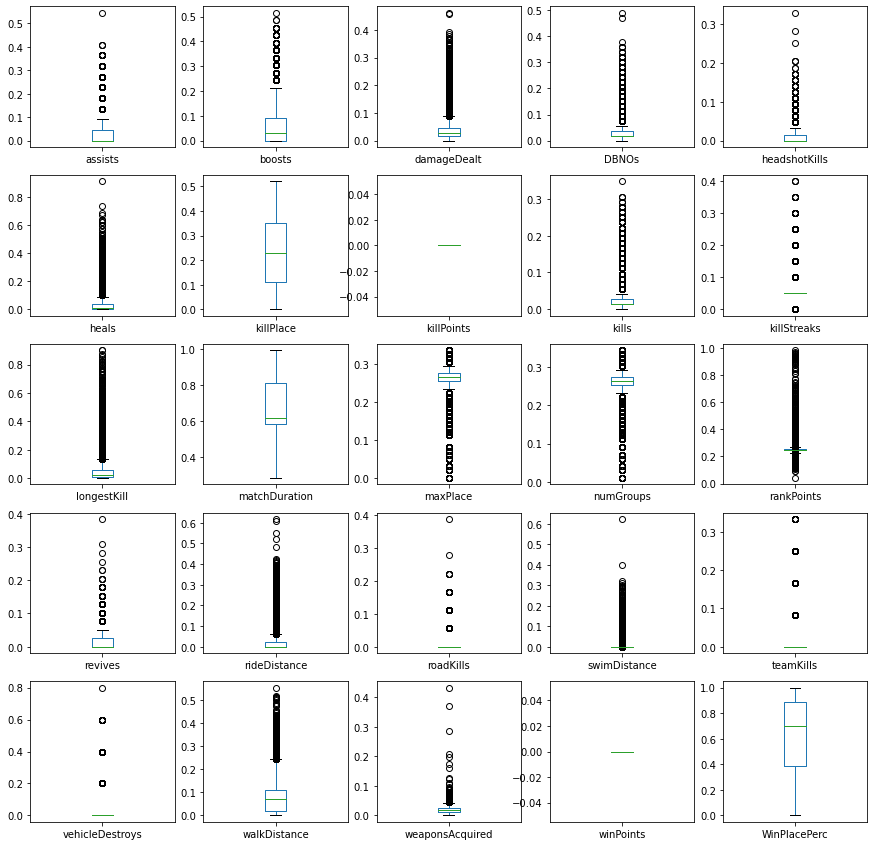

In [140]:
plot_distributions(X_train_temp,y_train_temp,kmeans_4,19)

##### Find the nearest points to the centroid 

In [11]:
def get_closest(X,kmeans,y_train_temp,n_clusters):
    
    #Maintain the original data
    y_train_temp = y_train_temp.copy()
    
    #Get the closest position
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    
    #Add a cluster column for calculating the average WPP
    y_train_temp["cluster"] = kmeans.labels_
    
    #Calculate the average WPP
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Delete the cluster column
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 
    
    #Get the new whole training set
    temp_train = pd.concat([X,y_train_temp],axis=1)
    
    #Find the indices of closest points
    closest_data = temp_train.loc[closest]
    
    #Add an averageWpp column
    closest_data["averageWpp"] = average_Wpp
        
    return closest_data

In [12]:
closest = get_closest(X_train_temp,kmeans_4,y_train_temp,19)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(closest)

assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
1267151      0.0  0.030303     0.026406  0.018868       0.000000  0.0125   
814026       0.0  0.060606     0.005703  0.000000       0.000000  0.0000   
3400389      0.0  0.000000     0.008189  0.000000       0.000000  0.0000   
3326016      0.0  0.060606     0.015115  0.000000       0.015625  0.0125   
589359       0.0  0.090909     0.038165  0.018868       0.015625  0.0000   
2854726      0.0  0.000000     0.003921  0.000000       0.000000  0.0000   
3825073      0.0  0.060606     0.005387  0.000000       0.000000  0.0125   
2756219      0.0  0.030303     0.000000  0.000000       0.000000  0.0000   
2102620      0.0  0.030303     0.017291  0.037736       0.015625  0.0125   
3058148      0.0  0.060606     0.028099  0.018868       0.000000  0.0125   
4037541      0.0  0.030303     0.000000  0.000000       0.000000  0.0000   
585988       0.0  0.030303     0.002786  0.000000       0.000000  0.0125   
4170840      0.0  0.060606     0.023821  0.018868       0.000000  0.0375   
1821551      0.0  0.000000     0.014411  0.000000       0.000000  0.0000   
3652920      0.0  0.000000     0.000000  0.000000       0.000000  0.0000   
3298012      0.0  0.000000     0.000000  0.000000       0.000000  0.0000   
1611760      0.0  0.000000     0.010670  0.000000       0.000000  0.0000   
2951195      0.0  0.000000     0.000000  0.000000       0.000000  0.0000   
1112883      0.0  0.060606     0.023277  0.018868       0.000000  0.0125   

         killPlace  killPoints     kills  killStreaks  longestKill  \
1267151       0.25    0.000000  0.013889         0.05     0.041152   
814026        0.46    0.548848  0.000000         0.00     0.000000   
3400389       0.70    0.000000  0.000000         0.00     0.000000   
3326016       0.23    0.000000  0.013889         0.05     0.033803   
589359        0.21    0.596313  0.013889         0.05     0.019461   
2854726       0.69    0.588018  0.000000         0.00     0.000000   
3825073       0.47    0.538710  0.000000         0.00     0.000000   
2756219       0.45    0.000000  0.000000         0.00     0.000000   
2102620       0.22    0.621659  0.027778         0.05     0.025503   
3058148       0.25    0.000000  0.013889         0.05     0.050521   
4037541       0.47    0.587558  0.000000         0.00     0.000000   
585988        0.46    0.000000  0.000000         0.00     0.000000   
4170840       0.30    0.000000  0.000000         0.00     0.000000   
1821551       0.46    0.523041  0.000000         0.00     0.000000   
3652920       0.70    0.553456  0.000000         0.00     0.000000   
3298012       0.69    0.000000  0.000000         0.00     0.000000   
1611760       0.71    0.000000  0.000000         0.00     0.000000   
2951195       0.71    0.000000  0.000000         0.00     0.000000   
1112883       0.22    0.000000  0.013889         0.05     0.020037   

         matchDuration  maxPlace  numGroups  rankPoints   revives  \
1267151       0.673954  0.448980   0.454545    0.258839  0.000000   
814026        0.672053  0.265306   0.272727    0.000000  0.000000   
3400389       0.678232  0.255102   0.262626    0.241922  0.000000   
3326016       0.681559  0.938776   0.929293    0.255287  0.000000   
589359        0.655894  0.469388   0.454545    0.000000  0.000000   
2854726       0.656844  0.265306   0.272727    0.000000  0.000000   
3825073       0.667300  0.469388   0.444444    0.000000  0.000000   
2756219       0.773289  0.928571   0.888889    0.260870  0.000000   
2102620       0.639259  0.275510   0.282828    0.000000  0.000000   
3058148       0.741445  0.265306   0.262626    0.243444  0.000000   
4037541       0.670627  0.969388   0.949495    0.000000  0.000000   
585988        0.761882  0.459184   0.434343    0.252918  0.000000   
4170840       0.608840  0.112245   0.121212    0.253933  0.000000   
1821551       0.653042  0.928571   0.909091    0.000000  0.000000   
3652920       0.673954  0.479592   0.454545    0.000

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(closest.describe())

assists     boosts  damageDealt      DBNOs  headshotKills      heals  \
count     19.0  19.000000    19.000000  19.000000      19.000000  19.000000   
mean       0.0   0.031898     0.011749   0.006951       0.002467   0.006579   
std        0.0   0.029404     0.011620   0.011269       0.005854   0.009654   
min        0.0   0.000000     0.000000   0.000000       0.000000   0.000000   
25%        0.0   0.000000     0.001393   0.000000       0.000000   0.000000   
50%        0.0   0.030303     0.008189   0.000000       0.000000   0.000000   
75%        0.0   0.060606     0.020284   0.018868       0.000000   0.012500   
max        0.0   0.090909     0.038165   0.037736       0.015625   0.037500   

       killPlace  killPoints      kills  killStreaks  longestKill  \
count  19.000000   19.000000  19.000000    19.000000    19.000000   
mean    0.455263    0.239874   0.005117     0.015789     0.010025   
std     0.195828    0.289743   0.008295     0.023878     0.016515   
min     0.210000    0.000000   0.000000     0.000000     0.000000   
25%     0.250000    0.000000   0.000000     0.000000     0.000000   
50%     0.460000    0.000000   0.000000     0.000000     0.000000   
75%     0.690000    0.551152   0.013889     0.050000     0.019749   
max     0.710000    0.621659   0.027778     0.050000     0.050521   

       matchDuration   maxPlace  numGroups  rankPoints    revives  \
count      19.000000  19.000000  19.000000   19.000000  19.000000   
mean        0.682309   0.497315   0.489102    0.145233   0.001350   
std         0.040550   0.292098   0.281166    0.127339   0.005882   
min         0.608840   0.112245   0.121212    0.000000   0.000000   
25%         0.662072   0.265306   0.267677    0.000000   0.000000   
50%         0.673954   0.459184   0.444444    0.241922   0.000000   
75%         0.681321   0.704082   0.671717    0.253426   0.000000   
max         0.773289   0.969388   0.949495    0.260870   0.025641   

       rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
count     19.000000       19.0          19.0       19.0             19.0   
mean       0.003086        0.0           0.0        0.0              0.0   
std        0.006401        0.0           0.0        0.0              0.0   
min        0.000000        0.0           0.0        0.0              0.0   
25%        0.000000        0.0           0.0        0.0              0.0   
50%        0.000000        0.0           0.0        0.0              0.0   
75%        0.000000        0.0           0.0        0.0              0.0   
max        0.020791        0.0           0.0        0.0              0.0   

       walkDistance  weaponsAcquired  winPoints  matchType_crashfpp  \
count     19.000000        19.000000  19.000000                19.0   
mean       0.044847         0.017395   0.314064                 0.0   
std        0.025984         0.007047   0.378416                 0.0   
min        0.004682         0.008475   0.000000                 0.0   
25%        0.022017         0.012712   0.000000                 0.0   
50%        0.048759         0.016949   0.000000                 0.0   
75%        0.062393         0.021186   0.744908                 0.0   
max        0.084251         0.029661   0.755589                 0.0   

       matchType_crashtpp  matchType_duo  matchType_duo-fpp  \
count                19.0      19.000000          19.000000   
mean                  0.0       0.105263           0.210526   
std                   0.0       0.315302           0.418854   
min                   0.0       0.000000           0.000000   
25%                   0.0       0.000000           0.000000   
50%                   0.0       0.000000           0.000000   
75%                   0.0       0.000000           0.000000   
max                   0.0       1.000000           1.000000   

       matchType_flarefpp  matchType_flaretpp  matchType_normal-duo  \
count                19.0                19.0                  19.0   
mean            

##### Find the centroids

In [11]:
def get_average(X,kmeans,n_clusters,y_train_temp):
    
    #Maintain the original data
    X = X.copy()
    
    #Get the centroids
    centroids = kmeans.cluster_centers_
    
    #Append centroids to the pandas dataframe for showing a table
    for centroid in centroids:
        X.loc[len(X)]=centroid
    
    #Extract the centroids
    average_data = X.tail(n_clusters)
    
    #Get the average WPP
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    
    #Add one more column for average WPP
    average_data["averageWpp"] = average_Wpp
    
    #Delete the match type columns, don't think it's useful
    cols = [c for c in average_data.columns if c.lower()[:9] != 'matchtype']
    average_data = average_data[cols]
    
    return average_data

In [12]:
centroids = get_average(X_train_temp,kmeans_4,19,y_train_temp)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(centroids)

assists    boosts  damageDealt         DBNOs  headshotKills  \
4446965  0.015580  0.058321     0.033979  2.130752e-02       0.007053   
4446966  0.013771  0.035429     0.019930  1.608166e-02       0.003416   
4446967  0.005000  0.011892     0.006301  3.457035e-03       0.000015   
4446968  0.003553  0.058728     0.032193  2.543105e-15       0.007918   
4446969  0.016424  0.055184     0.034513  2.120822e-02       0.007083   
4446970  0.005851  0.011345     0.006882  3.300228e-03       0.000016   
4446971  0.010418  0.033933     0.019626  1.148153e-02       0.003392   
4446972  0.002260  0.031676     0.016772  1.644518e-15       0.003371   
4446973  0.021463  0.054385     0.034641  2.987323e-02       0.007030   
4446974  0.020880  0.059677     0.032469  2.922019e-02       0.006498   
4446975  0.002899  0.031095     0.018108  2.879641e-15       0.003865   
4446976  0.009278  0.034604     0.018765  1.154353e-02       0.003278   
4446977  0.039307  0.041052     0.047111  2.119362e-02       0.009571   
4446978  0.003019  0.033471     0.017475 -8.257284e-16       0.003731   
4446979  0.004250  0.008348     0.006216  2.497694e-03       0.000011   
4446980  0.003478  0.008662     0.005798  2.609464e-03       0.000008   
4446981  0.001353  0.006584     0.003567  2.537900e-15       0.000013   
4446982  0.004710  0.011913     0.005297  3.104622e-03       0.000006   
4446983  0.020503  0.057098     0.033735  2.978025e-02       0.006894   

            heals  killPlace    killPoints     kills  killStreaks  \
4446965  0.028514   0.228496  9.853229e-14  0.025786     0.056731   
4446966  0.018441   0.462483  5.688614e-01  0.012484     0.026782   
4446967  0.007936   0.702804  1.572149e-05  0.000052     0.000189   
4446968  0.022729   0.231333 -3.402834e-14  0.025865     0.047899   
4446969  0.026598   0.228223  5.872249e-01  0.025944     0.057158   
4446970  0.007293   0.706608  5.821254e-01  0.000057     0.000206   
4446971  0.016315   0.455380  5.336754e-01  0.012734     0.027523   
4446972  0.012627   0.448925  8.120147e-04  0.011722     0.021404   
4446973  0.028133   0.228702  6.236202e-01  0.025681     0.056927   
4446974  0.030583   0.231760 -3.477774e-14  0.024653     0.053165   
4446975  0.012168   0.473041  5.682800e-01  0.012990     0.024178   
4446976  0.016998   0.469458  9.448481e-04  0.012535     0.027102   
4446977  0.029736   0.303724  1.637382e-01  0.035698     0.040954   
4446978  0.012703   0.457054  5.304623e-01  0.012788     0.023512   
4446979  0.005332   0.704340  5.531110e-01  0.000036     0.000129   
4446980  0.005760   0.699685  1.018630e-13  0.000032     0.000115   
4446981  0.003032   0.706365 -3.400058e-14  0.000064     0.000231   
4446982  0.007730   0.707009  2.242157e-03  0.000021     0.000074   
4446983  0.030475   0.229362  8.090750e-14  0.025265     0.055707   

         longestKill  matchDuration  maxPlace  numGroups  rankPoints  \
4446965     0.041855       0.696902  0.464995   0.452272    0.257620   
4446966     0.022020       0.690352  0.261793   0.258754    0.000007   
4446967     0.000037       0.684992  0.267123   0.264899    0.247167   
4446968     0.040092       0.690072  0.943641   0.919983    0.262050   
4446969     0.040007       0.675559  0.464634   0.454278    0.000009   
4446970     0.000040       0.657648  0.270528   0.268660    0.000007   
4446971     0.020086       0.705340  0.462070   0.444997    0.000010   
4446972     0.018691       0.744265  0.900325   0.859951    0.256243   
4446973     0.041774       0.661576  0.269222   0.267317    0.000007   
4446974     0.043894       0.707766  0.261117   0.259206    0.250907   
4446975     0.019411       0.679390  0.955187   0.932762    0.000013   
4446976     0.020435       0.728070  0.468701   0.453501    0.253202   
4446977     0.039319       0.616218  0.211929   0.209123    0.163710   
4446978     0.019351       0.714059  0.932836   0.893297    0.000013   
4446979     0.000026       0.670575  0.470367   0.459943    0.000008   
4446980     0.00

In [16]:
winner = centroids.loc[centroids['averageWpp'] > 0.6]
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(winner)

assists    boosts  damageDealt         DBNOs  headshotKills  \
4446965  0.015580  0.058321     0.033979  2.130752e-02       0.007053   
4446968  0.003553  0.058728     0.032193  2.543105e-15       0.007918   
4446969  0.016424  0.055184     0.034513  2.120822e-02       0.007083   
4446973  0.021463  0.054385     0.034641  2.987323e-02       0.007030   
4446974  0.020880  0.059677     0.032469  2.922019e-02       0.006498   
4446983  0.020503  0.057098     0.033735  2.978025e-02       0.006894   

            heals  killPlace    killPoints     kills  killStreaks  \
4446965  0.028514   0.228496  9.856005e-14  0.025786     0.056731   
4446968  0.022729   0.231333 -3.402834e-14  0.025865     0.047899   
4446969  0.026598   0.228223  5.872249e-01  0.025944     0.057158   
4446973  0.028133   0.228702  6.236202e-01  0.025681     0.056927   
4446974  0.030583   0.231760 -3.477774e-14  0.024653     0.053165   
4446983  0.030475   0.229362  8.090750e-14  0.025265     0.055707   

         longestKill  matchDuration  maxPlace  numGroups  rankPoints  \
4446965     0.041855       0.696902  0.464995   0.452272    0.257620   
4446968     0.040092       0.690072  0.943641   0.919983    0.262050   
4446969     0.040007       0.675559  0.464634   0.454278    0.000009   
4446973     0.041774       0.661576  0.269222   0.267317    0.000007   
4446974     0.043894       0.707766  0.261117   0.259206    0.250907   
4446983     0.044090       0.686141  0.266090   0.263786    0.250956   

              revives  rideDistance  roadKills  swimDistance  teamKills  \
4446965  7.119323e-03      0.021573   0.000232      0.001813   0.002583   
4446968 -1.093743e-15      0.015651   0.000384      0.002092   0.001018   
4446969  6.914535e-03      0.018132   0.000215      0.001687   0.001394   
4446973  8.891201e-03      0.017479   0.000203      0.001515   0.001727   
4446974  8.640185e-03      0.029233   0.000466      0.001902   0.003945   
4446983  9.162074e-03      0.022167   0.000234      0.001705   0.003300   

         vehicleDestroys  walkDistance  weaponsAcquired     winPoints  \
4446965         0.002208      0.066483         0.018994 -1.397216e-13   
4446968         0.001305      0.057395         0.018946  4.490852e-14   
4446969         0.001530      0.064038         0.018609  7.523217e-01   
4446973         0.001955      0.067927         0.018338  7.527797e-01   
4446974         0.004370      0.069632         0.019636  2.553513e-15   
4446983         0.002838      0.070508         0.018827  8.448797e-14   

         averageWpp  
4446965    0.656753  
4446968    0.664679  
4446969    0.650769  
4446973    0.620046  
4446974    0.622892  
4446983    0.626485

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(winner.describe())

assists    boosts  damageDealt         DBNOs  headshotKills     heals  \
count  6.000000  6.000000     6.000000  6.000000e+00       6.000000  6.000000   
mean   0.016400  0.057232     0.033588  2.189824e-02       0.007079  0.027839   
std    0.006757  0.002084     0.001033  1.148647e-02       0.000464  0.002921   
min    0.003553  0.054385     0.032193  2.543105e-15       0.006498  0.022729   
25%    0.015791  0.055663     0.032785  2.123305e-02       0.006928  0.026982   
50%    0.018464  0.057710     0.033857  2.526386e-02       0.007042  0.028324   
75%    0.020786  0.058626     0.034379  2.964024e-02       0.007076  0.029985   
max    0.021463  0.059677     0.034641  2.987323e-02       0.007918  0.030583   

       killPlace    killPoints     kills  killStreaks  longestKill  \
count   6.000000  6.000000e+00  6.000000     6.000000     6.000000   
mean    0.229646  2.018075e-01  0.025532     0.054598     0.041952   
std     0.001525  3.128506e-01  0.000492     0.003597     0.001768   
min     0.228223 -3.477774e-14  0.024653     0.047899     0.040007   
25%     0.228547 -5.294376e-15  0.025369     0.053801     0.040513   
50%     0.229032  8.973378e-14  0.025733     0.056219     0.041814   
75%     0.230840  4.404186e-01  0.025845     0.056878     0.043384   
max     0.231760  6.236202e-01  0.025944     0.057158     0.044090   

       matchDuration  maxPlace  numGroups  rankPoints       revives  \
count       6.000000  6.000000   6.000000    6.000000  6.000000e+00   
mean        0.686336  0.444950   0.436140    0.170258  6.787886e-03   
std         0.016212  0.263115   0.254639    0.131943  3.455228e-03   
min         0.661576  0.261117   0.259206    0.000007 -1.093743e-15   
25%         0.678204  0.266873   0.264669    0.062733  6.965732e-03   
50%         0.688106  0.366928   0.359795    0.250932  7.879754e-03   
75%         0.695194  0.464905   0.453777    0.255954  8.828447e-03   
max         0.707766  0.943641   0.919983    0.262050  9.162074e-03   

       rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
count      6.000000   6.000000      6.000000   6.000000         6.000000   
mean       0.020706   0.000289      0.001786   0.002328         0.002368   
std        0.004862   0.000109      0.000199   0.001147         0.001119   
min        0.015651   0.000203      0.001515   0.001018         0.001305   
25%        0.017642   0.000219      0.001692   0.001477         0.001636   
50%        0.019852   0.000233      0.001759   0.002155         0.002081   
75%        0.022019   0.000346      0.001880   0.003121         0.002681   
max        0.029233   0.000466      0.002092   0.003945         0.004370   

       walkDistance  weaponsAcquired     winPoints  averageWpp  
count      6.000000         6.000000  6.000000e+00    6.000000  
mean       0.065997         0.018892  2.508502e-01    0.640271  
std        0.004803         0.000438  3.886155e-01    0.019384  
min        0.057395         0.018338 -1.397216e-13    0.620046  
25%        0.064649         0.018664  1.314227e-14    0.623790  
50%        0.067205         0.018886  6.469825e-14    0.638627  
75%        0.069205         0.018982  5.642413e-01    0.655257  
max        0.070508         0.019636  7.527797e-01    0.664679

In [18]:
loser = centroids.loc[centroids['averageWpp'] < 0.4]
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(loser)

assists    boosts  damageDealt         DBNOs  headshotKills  \
4446967  0.005000  0.011892     0.006301  3.457035e-03       0.000015   
4446970  0.005851  0.011345     0.006882  3.300228e-03       0.000016   
4446979  0.004250  0.008348     0.006216  2.497694e-03       0.000011   
4446980  0.003478  0.008662     0.005798  2.609464e-03       0.000008   
4446981  0.001353  0.006584     0.003567  2.541370e-15       0.000013   
4446982  0.004710  0.011913     0.005297  3.104622e-03       0.000006   

            heals  killPlace    killPoints     kills  killStreaks  \
4446967  0.007936   0.702804  1.572149e-05  0.000052     0.000189   
4446970  0.007293   0.706608  5.821254e-01  0.000057     0.000206   
4446979  0.005332   0.704340  5.531110e-01  0.000036     0.000129   
4446980  0.005760   0.699685  1.018630e-13  0.000032     0.000115   
4446981  0.003032   0.706365 -3.402834e-14  0.000064     0.000231   
4446982  0.007730   0.707009  2.242157e-03  0.000021     0.000074   

         longestKill  matchDuration  maxPlace  numGroups  rankPoints  \
4446967     0.000037       0.684992  0.267123   0.264899    0.247167   
4446970     0.000040       0.657648  0.270528   0.268660    0.000007   
4446979     0.000026       0.670575  0.470367   0.459943    0.000008   
4446980     0.000026       0.695446  0.466762   0.454087    0.254832   
4446981     0.000046       0.690944  0.948631   0.924718    0.258782   
4446982     0.000012       0.706030  0.261837   0.259877    0.244520   

              revives  rideDistance     roadKills  swimDistance  teamKills  \
4446967  2.322410e-03      0.009351  2.191493e-07      0.000596   0.002335   
4446970  2.250388e-03      0.007387  1.461408e-07      0.000589   0.001226   
4446979  1.272847e-03      0.005948 -3.087266e-17      0.000442   0.000660   
4446980  1.312064e-03      0.007188  1.825822e-07      0.000423   0.001414   
4446981 -1.092008e-15      0.004592  3.307863e-07      0.000488   0.001076   
4446982  2.060787e-03      0.010947 -2.545165e-17      0.000720   0.003100   

         vehicleDestroys  walkDistance  weaponsAcquired     winPoints  \
4446967         0.000726      0.026951         0.012248  3.128218e-05   
4446970         0.000572      0.026227         0.012087  7.449501e-01   
4446979         0.000357      0.020180         0.011394  7.463548e-01   
4446980         0.000441      0.020585         0.011418 -1.421085e-13   
4446981         0.000276      0.016368         0.010636  4.574119e-14   
4446982         0.000992      0.027603         0.012527  2.780328e-03   

         averageWpp  
4446967    0.306079  
4446970    0.311849  
4446979    0.324399  
4446980    0.316115  
4446981    0.318244  
4446982    0.280624

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(loser.describe())

assists    boosts  damageDealt         DBNOs  headshotKills     heals  \
count  6.000000  6.000000     6.000000  6.000000e+00       6.000000  6.000000   
mean   0.004107  0.009791     0.005677  2.494841e-03       0.000012  0.006181   
std    0.001562  0.002235     0.001161  1.279350e-03       0.000004  0.001872   
min    0.001353  0.006584     0.003567  2.541370e-15       0.000006  0.003032   
25%    0.003671  0.008426     0.005422  2.525637e-03       0.000009  0.005439   
50%    0.004480  0.010004     0.006007  2.857043e-03       0.000012  0.006527   
75%    0.004928  0.011755     0.006279  3.251326e-03       0.000015  0.007621   
max    0.005851  0.011913     0.006882  3.457035e-03       0.000016  0.007936   

       killPlace    killPoints     kills  killStreaks  longestKill  \
count   6.000000  6.000000e+00  6.000000     6.000000     6.000000   
mean    0.704469  1.895824e-01  0.000044     0.000157     0.000031   
std     0.002839  2.929703e-01  0.000017     0.000061     0.000012   
min     0.699685 -3.402834e-14  0.000021     0.000074     0.000012   
25%     0.703188  3.930372e-06  0.000033     0.000118     0.000026   
50%     0.705353  1.128939e-03  0.000044     0.000159     0.000031   
75%     0.706547  4.153938e-01  0.000056     0.000202     0.000039   
max     0.707009  5.821254e-01  0.000064     0.000231     0.000046   

       matchDuration  maxPlace  numGroups  rankPoints       revives  \
count       6.000000  6.000000   6.000000    6.000000  6.000000e+00   
mean        0.684272  0.447541   0.438697    0.167553  1.536416e-03   
std         0.017548  0.264708   0.256125    0.129881  8.812358e-04   
min         0.657648  0.261837   0.259877    0.000007 -1.092008e-15   
25%         0.674179  0.267974   0.265839    0.061136  1.282651e-03   
50%         0.687968  0.368645   0.361374    0.245843  1.686425e-03   
75%         0.694320  0.469465   0.458479    0.252916  2.202988e-03   
max         0.706030  0.948631   0.924718    0.258782  2.322410e-03   

       rideDistance     roadKills  swimDistance  teamKills  vehicleDestroys  \
count      6.000000  6.000000e+00      6.000000   6.000000         6.000000   
mean       0.007569  1.464431e-07      0.000543   0.001635         0.000561   
std        0.002291  1.292021e-07      0.000113   0.000907         0.000264   
min        0.004592 -3.087266e-17      0.000423   0.000660         0.000276   
25%        0.006258  3.653519e-08      0.000453   0.001114         0.000378   
50%        0.007287  1.643615e-07      0.000539   0.001320         0.000507   
75%        0.008860  2.100075e-07      0.000594   0.002105         0.000687   
max        0.010947  3.307863e-07      0.000720   0.003100         0.000992   

       walkDistance  weaponsAcquired     winPoints  averageWpp  
count      6.000000         6.000000  6.000000e+00    6.000000  
mean       0.022986         0.011718  2.490194e-01    0.309552  
std        0.004582         0.000698  3.846921e-01    0.015448  
min        0.016368         0.010636 -1.421085e-13    0.280624  
25%        0.020281         0.011400  7.820544e-06    0.307522  
50%        0.023406         0.011752  1.405805e-03    0.313982  
75%        0.026770         0.012208  5.594077e-01    0.317712  
max        0.027603         0.012527  7.463548e-01    0.324399

In [21]:
norm = centroids.loc[(centroids['averageWpp'] > 0.4) & (centroids['averageWpp'] < 0.6)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(norm)

assists    boosts  damageDealt         DBNOs  headshotKills  \
4446966  0.013771  0.035429     0.019930  1.608166e-02       0.003416   
4446971  0.010418  0.033933     0.019626  1.148153e-02       0.003392   
4446972  0.002260  0.031676     0.016772  1.646253e-15       0.003371   
4446975  0.002899  0.031095     0.018108  2.879641e-15       0.003865   
4446976  0.009278  0.034604     0.018765  1.154353e-02       0.003278   
4446977  0.039307  0.041052     0.047111  2.119362e-02       0.009571   
4446978  0.003019  0.033471     0.017475 -8.274631e-16       0.003731   

            heals  killPlace  killPoints     kills  killStreaks  longestKill  \
4446966  0.018441   0.462483    0.568861  0.012484     0.026782     0.022020   
4446971  0.016315   0.455380    0.533675  0.012734     0.027523     0.020086   
4446972  0.012627   0.448925    0.000812  0.011722     0.021404     0.018691   
4446975  0.012168   0.473041    0.568280  0.012990     0.024178     0.019411   
4446976  0.016998   0.469458    0.000945  0.012535     0.027102     0.020435   
4446977  0.029736   0.303724    0.163738  0.035698     0.040954     0.039319   
4446978  0.012703   0.457054    0.530462  0.012788     0.023512     0.019351   

         matchDuration  maxPlace  numGroups  rankPoints       revives  \
4446966       0.690352  0.261793   0.258754    0.000007  5.270792e-03   
4446971       0.705340  0.462070   0.444997    0.000010  3.831346e-03   
4446972       0.744265  0.900325   0.859951    0.256243 -8.881784e-16   
4446975       0.679390  0.955187   0.932762    0.000013 -1.169204e-15   
4446976       0.728070  0.468701   0.453501    0.253202  3.933210e-03   
4446977       0.616218  0.211929   0.209123    0.163710  5.441646e-03   
4446978       0.714059  0.932836   0.893297    0.000013 -3.287301e-16   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
4446966      0.018404   0.000271      0.001337   0.001805         0.002305   
4446971      0.017298   0.000254      0.001287   0.001382         0.001762   
4446972      0.015851   0.000494      0.001499   0.001481         0.001607   
4446975      0.009531   0.000196      0.001214   0.000516         0.000547   
4446976      0.019211   0.000226      0.001241   0.002676         0.002286   
4446977      0.045598   0.003567      0.001093   0.004388         0.007387   
4446978      0.015559   0.000660      0.001609   0.000826         0.001322   

         walkDistance  weaponsAcquired  winPoints  averageWpp  
4446966      0.048607         0.016047   0.747641    0.453059  
4446971      0.043806         0.015845   0.749210    0.487408  
4446972      0.037420         0.015922   0.002488    0.463404  
4446975      0.036273         0.014737   0.749630    0.492117  
4446976      0.043449         0.015706   0.002122    0.479919  
4446977      0.047913         0.031265   0.264763    0.495298  
4446978      0.039802         0.015916   0.750399    0.493099

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(norm.describe())

assists    boosts  damageDealt         DBNOs  headshotKills     heals  \
count  7.000000  7.000000     7.000000  7.000000e+00       7.000000  7.000000   
mean   0.011565  0.034466     0.022541  8.614333e-03       0.004375  0.016998   
std    0.013011  0.003285     0.010892  8.693106e-03       0.002301  0.006133   
min    0.002260  0.031095     0.016772 -8.274631e-16       0.003278  0.012168   
25%    0.002959  0.032573     0.017792  2.262947e-15       0.003381  0.012665   
50%    0.009278  0.033933     0.018765  1.148153e-02       0.003416  0.016315   
75%    0.012094  0.035017     0.019778  1.381259e-02       0.003798  0.017720   
max    0.039307  0.041052     0.047111  2.119362e-02       0.009571  0.029736   

       killPlace  killPoints     kills  killStreaks  longestKill  \
count   7.000000    7.000000  7.000000     7.000000     7.000000   
mean    0.438581    0.338111  0.015850     0.027351     0.022759   
std     0.060040    0.270594  0.008762     0.006398     0.007379   
min     0.303724    0.000812  0.011722     0.021404     0.018691   
25%     0.452153    0.082342  0.012509     0.023845     0.019381   
50%     0.457054    0.530462  0.012734     0.026782     0.020086   
75%     0.465971    0.550978  0.012889     0.027313     0.021227   
max     0.473041    0.568861  0.035698     0.040954     0.039319   

       matchDuration  maxPlace  numGroups  rankPoints       revives  \
count       7.000000  7.000000   7.000000    7.000000  7.000000e+00   
mean        0.696813  0.598977   0.578912    0.096171  2.639571e-03   
std         0.041713  0.323618   0.309822    0.123714  2.542007e-03   
min         0.616218  0.211929   0.209123    0.000007 -1.169204e-15   
25%         0.684871  0.361932   0.351876    0.000011 -6.084543e-16   
50%         0.705340  0.468701   0.453501    0.000013  3.831346e-03   
75%         0.721065  0.916581   0.876624    0.208456  4.602001e-03   
max         0.744265  0.955187   0.932762    0.256243  5.441646e-03   

       rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
count      7.000000   7.000000      7.000000   7.000000         7.000000   
mean       0.020207   0.000810      0.001326   0.001868         0.002459   
std        0.011633   0.001228      0.000176   0.001311         0.002255   
min        0.009531   0.000196      0.001093   0.000516         0.000547   
25%        0.015705   0.000240      0.001228   0.001104         0.001465   
50%        0.017298   0.000271      0.001287   0.001481         0.001762   
75%        0.018808   0.000577      0.001418   0.002241         0.002295   
max        0.045598   0.003567      0.001609   0.004388         0.007387   

       walkDistance  weaponsAcquired  winPoints  averageWpp  
count      7.000000         7.000000   7.000000    7.000000  
mean       0.042467         0.017920   0.466607    0.480615  
std        0.004849         0.005901   0.363175    0.016360  
min        0.036273         0.014737   0.002122    0.453059  
25%        0.038611         0.015776   0.133625    0.471662  
50%        0.043449         0.015916   0.747641    0.487408  
75%        0.045860         0.015984   0.749420    0.492608  
max        0.048607         0.031265   0.750399    0.495298

In [20]:
#Describe the centroids
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(centroids.describe())

assists     boosts  damageDealt         DBNOs  headshotKills  \
count  19.000000  19.000000    19.000000  1.900000e+01      19.000000   
mean    0.010737   0.033863     0.020704  1.087678e-02       0.003851   
std     0.009767   0.019533     0.013120  1.132232e-02       0.003212   
min     0.001353   0.006584     0.003567 -8.274631e-16       0.000006   
25%     0.003515   0.011902     0.006591  1.248847e-03       0.000016   
50%     0.005851   0.033933     0.018765  3.457035e-03       0.003416   
75%     0.016002   0.054785     0.033102  2.120092e-02       0.006962   
max     0.039307   0.059677     0.047111  2.987323e-02       0.009571   

           heals  killPlace    killPoints      kills  killStreaks  \
count  19.000000  19.000000  1.900000e+01  19.000000    19.000000   
mean    0.017006   0.456566  2.481639e-01   0.013916     0.027368   
std     0.009699   0.197433  2.836251e-01   0.011672     0.022610   
min     0.003032   0.228223 -3.477774e-14   0.000021     0.000074   
25%     0.007833   0.231546  1.002115e-13   0.000061     0.000219   
50%     0.016315   0.457054  2.242157e-03   0.012734     0.026782   
75%     0.027366   0.701245  5.606955e-01   0.025473     0.050532   
max     0.030583   0.707009  6.236202e-01   0.035698     0.057158   

       longestKill  matchDuration   maxPlace  numGroups  rankPoints  \
count    19.000000      19.000000  19.000000  19.000000   19.000000   
mean      0.021643       0.689544   0.502515   0.489548    0.142109   
std       0.017683       0.027781   0.281664   0.270460    0.126190   
min       0.000012       0.616218   0.211929   0.209123    0.000007   
25%       0.000043       0.677474   0.266606   0.264343    0.000009   
50%       0.020086       0.690352   0.464634   0.452272    0.244520   
75%       0.040049       0.705685   0.685346   0.659947    0.254017   
max       0.044090       0.744265   0.955187   0.932762    0.262050   

            revives  rideDistance     roadKills  swimDistance  teamKills  \
count  1.900000e+01     19.000000  1.900000e+01     19.000000  19.000000   
mean   3.601200e-03      0.016374  3.896420e-04      0.001224   0.001940   
std    3.294184e-03      0.009537  7.925902e-04      0.000537   0.001118   
min   -1.169204e-15      0.004592 -3.087266e-17      0.000423   0.000516   
25%    6.364235e-04      0.009441  2.749678e-07      0.000658   0.001151   
50%    2.322410e-03      0.015851  2.257320e-04      0.001287   0.001481   
75%    6.178091e-03      0.018808  3.273504e-04      0.001648   0.002629   
max    9.162074e-03      0.045598  3.567124e-03      0.002092   0.004388   

       vehicleDestroys  walkDistance  weaponsAcquired     winPoints  \
count        19.000000     19.000000        19.000000  1.900000e+01   
mean          0.001831      0.043746         0.016268  3.297616e-01   
std           0.001688      0.018150         0.004696  3.722301e-01   
min           0.000276      0.016368         0.010636 -1.421085e-13   
25%           0.000649      0.027277         0.012388  6.511458e-14   
50%           0.001530      0.043449         0.015916  2.780328e-03   
75%           0.002247      0.060716         0.018718  7.484254e-01   
max           0.007387      0.070508         0.031265  7.527797e-01   

       averageWpp  
count   19.000000  
mean     0.477013  
std      0.136004  
min      0.280624  
25%      0.321322  
50%      0.487408  
75%      0.621469  
max      0.664679

In [23]:
#statistics for the whole training set
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(train.describe())

assists        boosts   damageDealt         DBNOs  headshotKills  \
count  4.446965e+06  4.446965e+06  4.446965e+06  4.446965e+06   4.446965e+06   
mean   1.062795e-02  3.354267e-02  1.975773e-02  1.241275e-02   3.544057e-03   
std    2.675332e-02  5.199375e-02  2.581328e-02  2.161779e-02   9.408677e-03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
50%    0.000000e+00  0.000000e+00  1.273277e-02  0.000000e+00   0.000000e+00   
75%    0.000000e+00  6.060606e-02  2.811366e-02  1.886792e-02   0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000e+00   

              heals     killPlace    killPoints         kills   killStreaks  \
count  4.446965e+06  4.446965e+06  4.446965e+06  4.446965e+06  4.446965e+06   
mean   1.712684e-02  4.659936e-01  2.327217e-01  1.284422e-02  2.719776e-02   
std    3.349978e-02  2.746293e-01  2.891728e-01  2.164507e-02  3.554861e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  2.300000e-01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  4.600000e-01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.500000e-02  7.000000e-01  5.400922e-01  1.388889e-02  5.000000e-02   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

        longestKill  matchDuration      maxPlace     numGroups    rankPoints  \
count  4.446965e+06   4.446965e+06  4.446965e+06  4.446965e+06  4.446965e+06   
mean   2.102157e-02   6.875032e-01  4.337212e-01  4.243192e-01  1.510760e-01   
std    4.659289e-02   1.229747e-01  2.431439e-01  2.352474e-01  1.246232e-01   
min    0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00   5.865019e-01  2.653061e-01  2.626263e-01  0.000000e+00   
50%    0.000000e+00   6.202471e-01  2.857143e-01  2.929293e-01  2.442903e-01   
75%    1.948812e-02   8.165399e-01  4.795918e-01  4.646465e-01  2.539333e-01   
max    1.000000e+00   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

            revives  rideDistance     roadKills  swimDistance     teamKills  \
count  4.446965e+06  4.446965e+06  4.446965e+06  4.446965e+06  4.446965e+06   
mean   4.222027e-03  1.488862e-02  1.942273e-04  1.179525e-03  1.989034e-03   
std    1.210685e-02  3.680530e-02  4.076276e-03  7.978604e-03  1.394946e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  4.691722e-06  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       vehicleDestroys  walkDistance  weaponsAcquired     winPoints  \
count     4.446965e+06  4.446965e+06     4.446965e+06  4.446965e+06   
mean      1.583642e-03  4.477184e-02     1.551054e-02  3.012719e-01   
std       1.852232e-02  4.590757e-02     1.040908e-02  3.674617e-01   
min       0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%       0.000000e+00  6.016292e-03     8.474576e-03  0.000000e+00   
50%       0.000000e+00  2.659426e-02     1.271186e-02  0.000000e+00   
75%       0.000000e+00  7.664856e-02     2.118644e-02  7.426726e-01   
max       1.000000e+00  1.000000e+00     1.000000e+00  1.000000e+00   

       winPlacePerc  
count  4.446965e+06  
mean   4.728216e-01  
std    3.074050e-01  
min    0.000000e+00  
25%    2.000000e-01  
50%    4.583000e-01  
75%    7.407000e-01  
max    1.000000e+00

In [24]:
winner.mean()-centroids.mean()

assists            0.005664
boosts             0.023369
damageDealt        0.012884
DBNOs              0.011021
headshotKills      0.003228
heals              0.010833
killPlace         -0.226920
killPoints        -0.046356
kills              0.011616
killStreaks        0.027230
longestKill        0.020309
matchDuration     -0.003208
maxPlace          -0.057565
numGroups         -0.053408
rankPoints         0.028150
revives            0.003187
rideDistance       0.004332
roadKills         -0.000101
swimDistance       0.000562
teamKills          0.000388
vehicleDestroys    0.000537
walkDistance       0.022252
weaponsAcquired    0.002623
winPoints         -0.078911
averageWpp         0.163258
dtype: float64

In [25]:
loser.mean() - centroids.mean()

assists           -0.006630
boosts            -0.024072
damageDealt       -0.015027
DBNOs             -0.008382
headshotKills     -0.003839
heals             -0.010825
killPlace          0.247903
killPoints        -0.058581
kills             -0.013872
killStreaks       -0.027210
longestKill       -0.021612
matchDuration     -0.005272
maxPlace          -0.054974
numGroups         -0.050851
rankPoints         0.025444
revives           -0.002065
rideDistance      -0.008805
roadKills         -0.000389
swimDistance      -0.000681
teamKills         -0.000304
vehicleDestroys   -0.001270
walkDistance      -0.020760
weaponsAcquired   -0.004550
winPoints         -0.080742
averageWpp        -0.167461
dtype: float64

In [26]:
norm.mean() - centroids.mean()

assists            0.000828
boosts             0.000603
damageDealt        0.001837
DBNOs             -0.002262
headshotKills      0.000524
heals             -0.000007
killPlace         -0.017985
killPoints         0.089947
kills              0.001934
killStreaks       -0.000017
longestKill        0.001116
matchDuration      0.007269
maxPlace           0.096462
numGroups          0.089364
rankPoints        -0.045937
revives           -0.000962
rideDistance       0.003834
roadKills          0.000420
swimDistance       0.000102
teamKills         -0.000072
vehicleDestroys    0.000628
walkDistance      -0.001278
weaponsAcquired    0.001651
winPoints          0.136846
averageWpp         0.003602
dtype: float64

### Cluster Analysis For Each Match Type

In [10]:
#Extract each matchType
matchType_crashfpp=train[train['matchType']=='crashfpp']
matchType_crashtpp=train[train['matchType']=='crashtpp']
matchType_duo=train[train['matchType']=='duo']
matchType_duo_fpp=train[train['matchType']=='duo-fpp']
matchType_flarefpp=train[train['matchType']=='flarefpp']
matchType_flaretpp=train[train['matchType']=='flaretpp']
matchType_normal_duo=train[train['matchType']=='normal-duo']
matchType_normal_duo_fpp=train[train['matchType']=='normal-duo-fpp']
matchType_normal_solo=train[train['matchType']=='normal-solo']
matchType_normal_solo_fpp=train[train['matchType']=='normal-solo-fpp']
matchType_normal_squad=train[train['matchType']=='normal-squad']
matchType_normal_squad_fpp=train[train['matchType']=='normal-squad-fpp']
matchType_solo=train[train['matchType']=='solo']
matchType_solo_fpp=train[train['matchType']=='solo-fpp']
matchType_squad=train[train['matchType']=='squad']
matchType_squad_fpp=train[train['matchType']=='squad-fpp']

In [11]:
#Add all match types to a list
allTypes = [matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo_fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal_duo,matchType_normal_duo_fpp,matchType_normal_solo,matchType_normal_solo_fpp,matchType_normal_squad,matchType_normal_squad_fpp,matchType_solo,matchType_solo_fpp,matchType_squad,matchType_squad_fpp]

#Add all names of match types to a list
names = ["crashfpp","crashtpp","duo","duo_fpp","flarefpp","flaretpp","normal_duo","normal_duo_fpp","normal_solo","normal_solo_fpp","normal_squad","normal_squad_fpp","solo","solo_fpp","squad","squad_fpp"]

In [12]:
for index in range(len(allTypes)):
    #Reset the indices
    allTypes[index] = allTypes[index].reset_index(drop=True)

In [13]:
#According to the experiences before, n_init doesn't seem to create a huge difference
#Use default n_init = 10 here
kmeans = KMeans(random_state=0) 

#### View the best number of clusters

crashfpp:
n_clusters:  2 ,Score:  8671.747543226787 ,Average WPP:  [0.6509074186682882, 0.2814120080053369]
n_clusters:  3 ,Score:  7349.923338726254 ,Average WPP:  [0.7057865871121718, 0.5309915284625728, 0.16381575726670067]
n_clusters:  4 ,Score:  5987.304389933077 ,Average WPP:  [0.7068755604155276, 0.5318276126558007, 0.15597064413938752, 0.60006589958159]
n_clusters:  5 ,Score:  5503.748570734683 ,Average WPP:  [0.7461607575757575, 0.5947939100346021, 0.11270614449696151, 0.5574489878542511, 0.451067032967033]
n_clusters:  6 ,Score:  5174.62644207231 ,Average WPP:  [0.1062804516584333, 0.7284614506927466, 0.5877143165467626, 0.42227804214819853, 0.8122152777777778, 0.5426603238866398]
n_clusters:  7 ,Score:  4888.070323206304 ,Average WPP:  [0.6374676100628931, 0.811405035971223, 0.10610909732016924, 0.586717441860465, 0.4517496703296703, 0.7275145559210526, 0.3074066455696203]
n_clusters:  8 ,Score:  4780.502271214008 ,Average WPP:  [0.7524466042154566, 0.32623773747841106, 0.30

flaretpp:
n_clusters:  2 ,Score:  2448.631125549769 ,Average WPP:  [0.4345421431787483, 0.4349760563380282]
n_clusters:  3 ,Score:  4235.928724452476 ,Average WPP:  [0.2408252268602541, 0.6253160857908847, 0.4349760563380282]
n_clusters:  4 ,Score:  4065.6370741470073 ,Average WPP:  [0.13234201570680626, 0.6992320950965825, 0.4349760563380282, 0.5018183673469389]
n_clusters:  5 ,Score:  3717.1578034177887 ,Average WPP:  [0.13234201570680626, 0.6992320950965825, 0.583208904109589, 0.5018183673469389, 0.27815]
n_clusters:  6 ,Score:  3522.0420871051674 ,Average WPP:  [0.10618742424242424, 0.4525469111969112, 0.583208904109589, 0.5245916256157636, 0.27815, 0.7860341013824883]
n_clusters:  7 ,Score:  3276.877998330792 ,Average WPP:  [0.06286973094170403, 0.4172489539748954, 0.583208904109589, 0.2767777041942605, 0.27815, 0.7977825552825554, 0.6580215102974828]
n_clusters:  8 ,Score:  3029.1729156746846 ,Average WPP:  [0.2770691629955947, 0.5916312056737589, 0.3243996932515337, 0.6660899521

n_clusters:  3 ,Score:  488.32371214479963 ,Average WPP:  [0.5495595419847328, 0.5379620689655172, 0.4466440366972477]
n_clusters:  4 ,Score:  431.93765662884 ,Average WPP:  [0.4662683333333334, 0.5379620689655172, 0.5030526315789474, 0.7518714285714287]
n_clusters:  5 ,Score:  419.8143285732483 ,Average WPP:  [0.4662683333333334, 0.5307504672897196, 0.5030526315789474, 0.7518714285714287, 0.5582684210526315]
n_clusters:  6 ,Score:  431.4803879123093 ,Average WPP:  [0.5346647058823529, 0.5307504672897196, 0.7614657894736843, 0.5582684210526315, 0.3568275862068966, 0.5019131147540983]
n_clusters:  7 ,Score:  423.00336306524696 ,Average WPP:  [0.48596699029126206, 0.5307504672897196, 0.5581594594594594, 0.5582684210526315, 0.7616878787878788, 0.34582599999999997, 0.530481081081081]
n_clusters:  8 ,Score:  415.4960784412743 ,Average WPP:  [0.4911988764044944, 0.5307504672897196, 0.3578352941176471, 0.6566294117647059, 0.5582684210526315, 0.7360260869565217, 0.47547976190476193, 0.55267808

n_clusters:  10 ,Score:  759141.6064315895 ,Average WPP:  [0.5270444044096227, 0.5226588881544866, 0.6996939322980855, 0.6857867662659124, 0.1393685245649752, 0.14687623906008387, 0.16178045692974743, 0.6962159689161554, 0.5300487726149049, 0.5105974027439301]
best_n_clusters:  2 , best_score:  1289948.003485198 , best_average_Wpp:  [0.4529095417843363, 0.45123709279262936] 

squad_fpp:
n_clusters:  2 ,Score:  3890983.6151302313 ,Average WPP:  [0.4654673331482458, 0.46381464269664135]
n_clusters:  3 ,Score:  3223621.1459085806 ,Average WPP:  [0.4638196056165469, 0.30687071163571067, 0.6263034422294205]
n_clusters:  4 ,Score:  3578818.760066495 ,Average WPP:  [0.3114743191175266, 0.30604566035874264, 0.6264920452575082, 0.6201321412892071]
n_clusters:  5 ,Score:  3182859.510117304 ,Average WPP:  [0.7001543521116671, 0.6206288031896238, 0.17264619752645105, 0.30960051438500613, 0.5364799723234172]
n_clusters:  6 ,Score:  2943467.325756722 ,Average WPP:  [0.7002601409170516, 0.53601548385

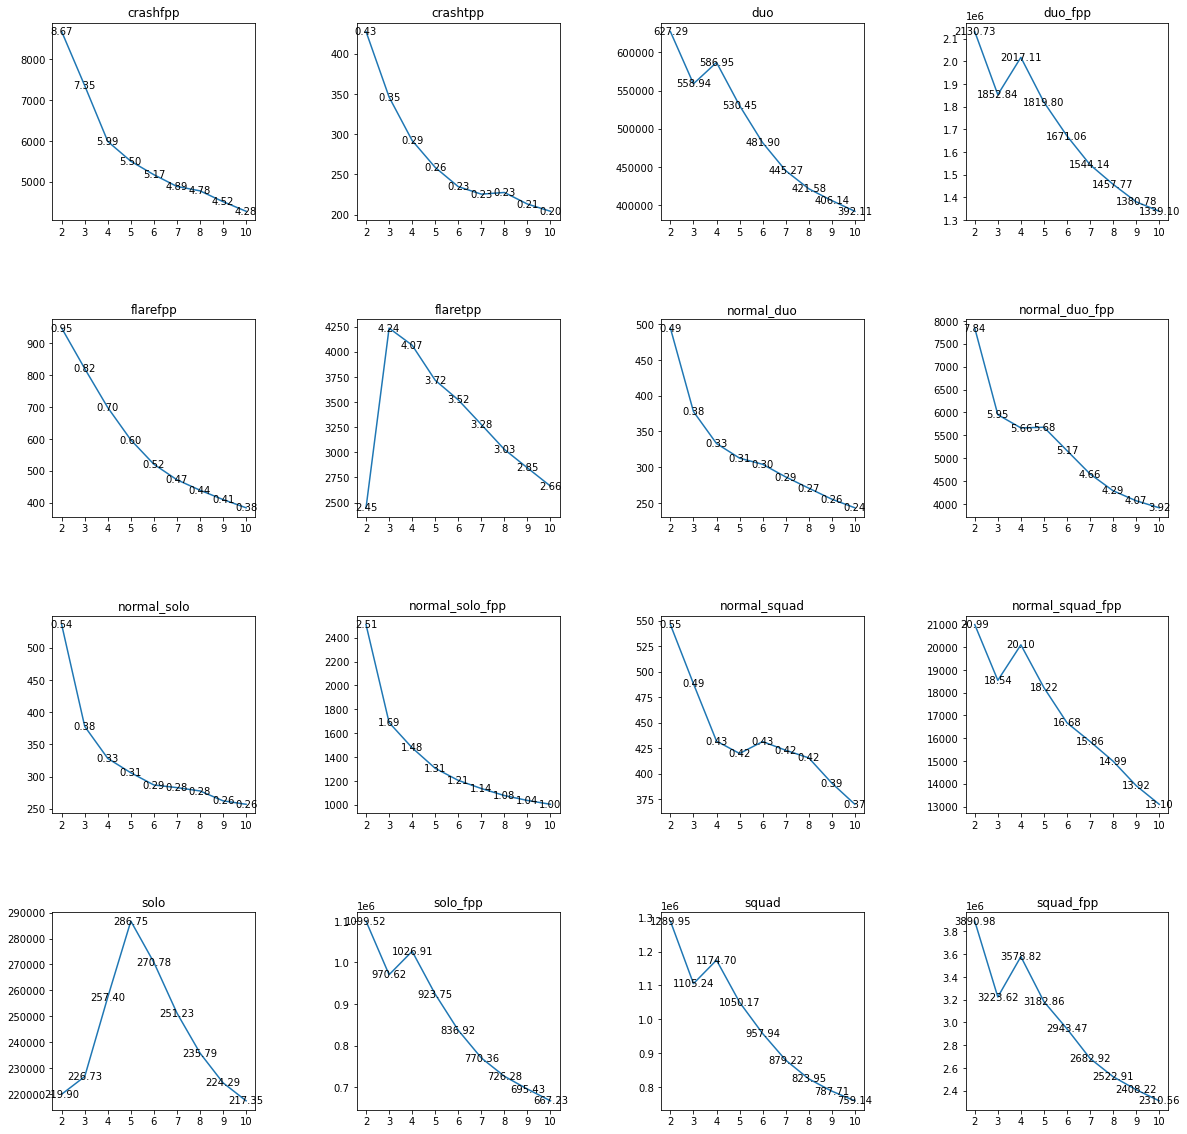

In [23]:
plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace=.5,wspace=.5)

#Used to allocate position for sub plots
p = 1

#Used to store the best number of clusters for each type
n_clusters_collection = []

for index in range(len(allTypes)):
    
    #Get the name
    name = names[index]
    
    #Get the dataframe with specific type, without changing the original data
    single_type = allTypes[index].copy()
    
    #Extract X and y
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    
    #Delete matchType column
    single_X_temp = single_X.drop(["matchType"],axis=1)
    
    #Convert numpy array to pandas dataframe
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y})
    
    scores = []
    Xs = []

    best_n_clusters = 0
    best_score = 0
    best_average_Wpp = 0
    print(name+":")
    for i in range(2,11):   
        
        #Set the number of clusters
        kmeans.n_clusters = i
        
        #Train the kmeans
        kmeans.fit(single_X_temp)
        
        #Get the score
        score = metrics.calinski_harabasz_score(single_X_temp,kmeans.labels_)
        
        #Add a cluster column
        single_X_temp["cluster"] = kmeans.labels_
        single_y_temp["cluster"] = kmeans.labels_
        
        #Calculate the average WPP
        average_Wpp = getAverageWPP(single_y_temp,i)
        
        #If current score is larger than the best score, then replace the values
        if(score>best_score):
            best_score = score
            best_n_clusters = i
            best_average_Wpp = average_Wpp
            
        print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
        
        #Append X and scores with current value
        Xs.append(i)
        scores.append(score)
        
        #Delete the cluster column
        single_X_temp = single_X_temp.drop(["cluster"],axis=1) 
        single_y_temp = single_y_temp.drop(["cluster"],axis=1) 

    print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp,"\n")
    
    #Append the best n_clusters
    n_clusters_collection.append(best_n_clusters)
    
    #Plot the line
    ax = plt.subplot(4,4,p)
    for x,y in zip(Xs,scores):
        ax.text(x,y,'%.2f'%(y*0.001),ha='center',va='center')
    plt.xticks(Xs)
    ax.plot(Xs,scores)
    ax.set_title(name)
    p+=1
    
plt.savefig("Individual_analysis.png")
plt.show()

I don't really understand how to do **"The only way to proceed if you have a result like crashfpp is to plot a graph with the features that are used as a basis for the clustering on the x-axis and their numerical values on the y-axis."** I feel a bit lost in this part.

#### View the distributions 

crashfpp:
Cluster 1, average wpp = 0.6509074186682882


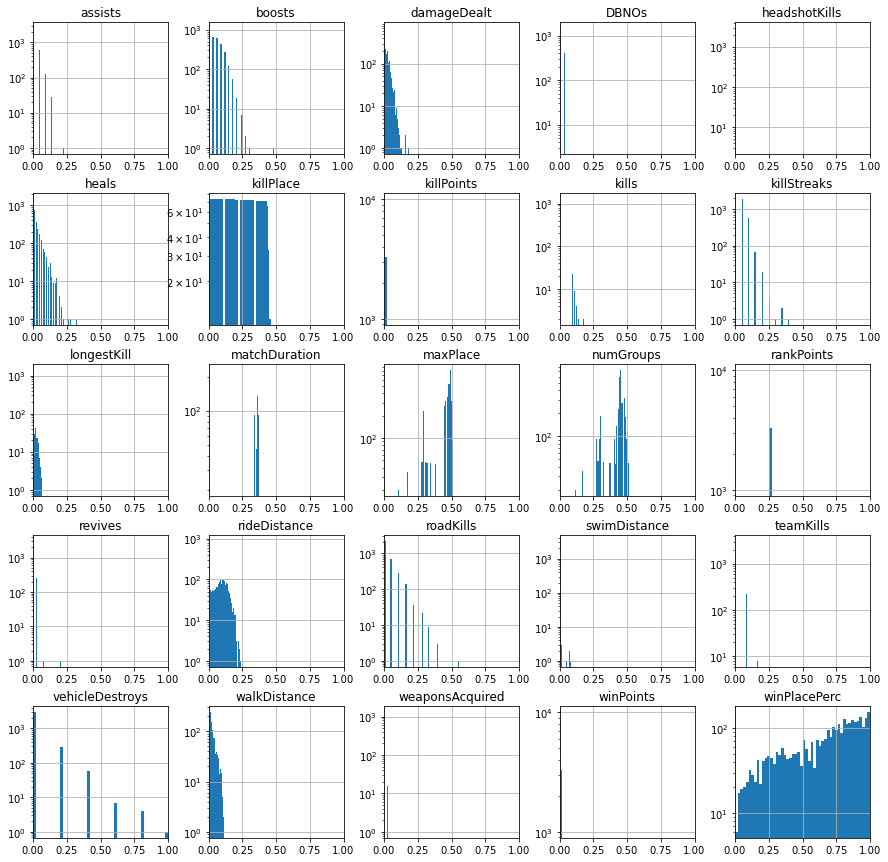

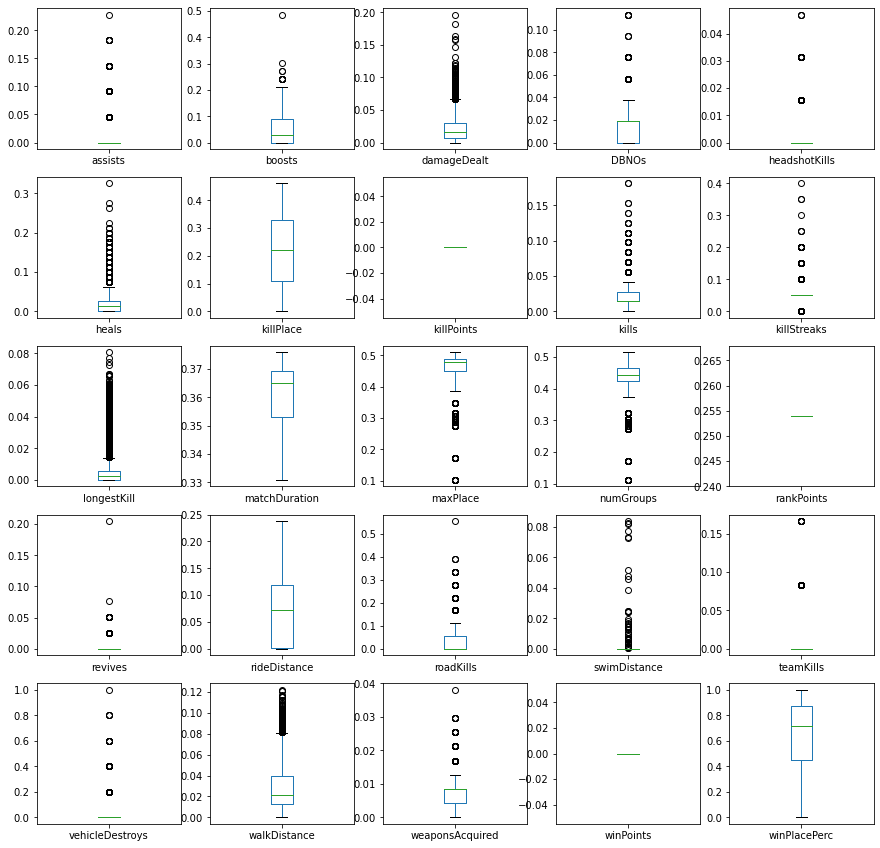

Cluster 2, average wpp = 0.2814120080053369


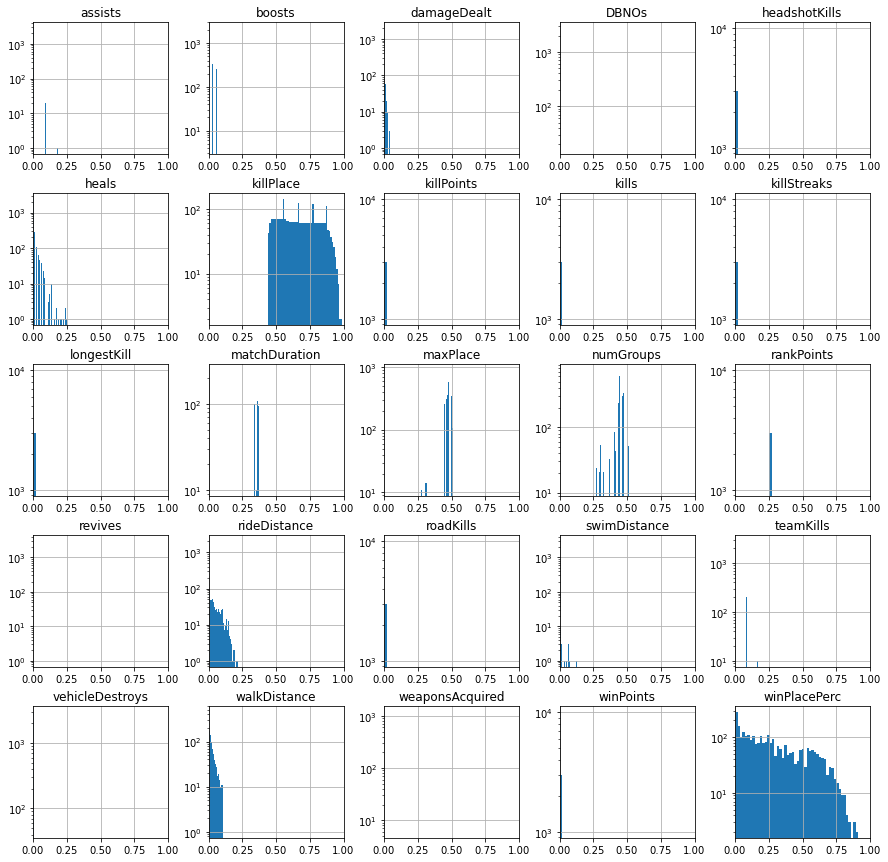

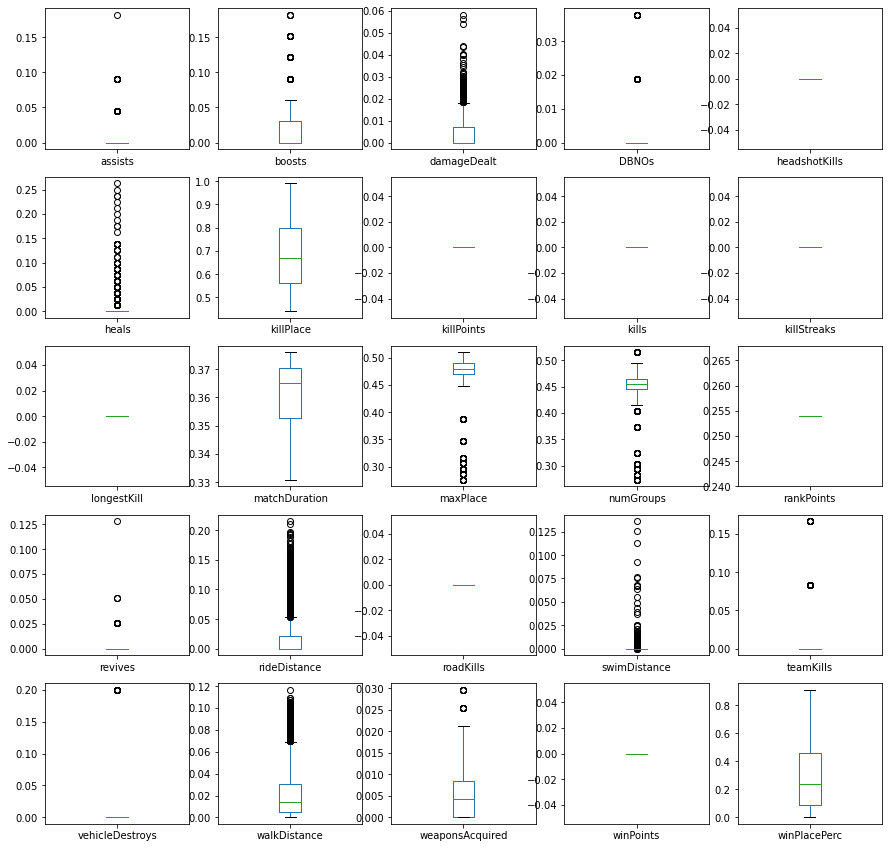

crashtpp:
Cluster 1, average wpp = 0.3173744444444445


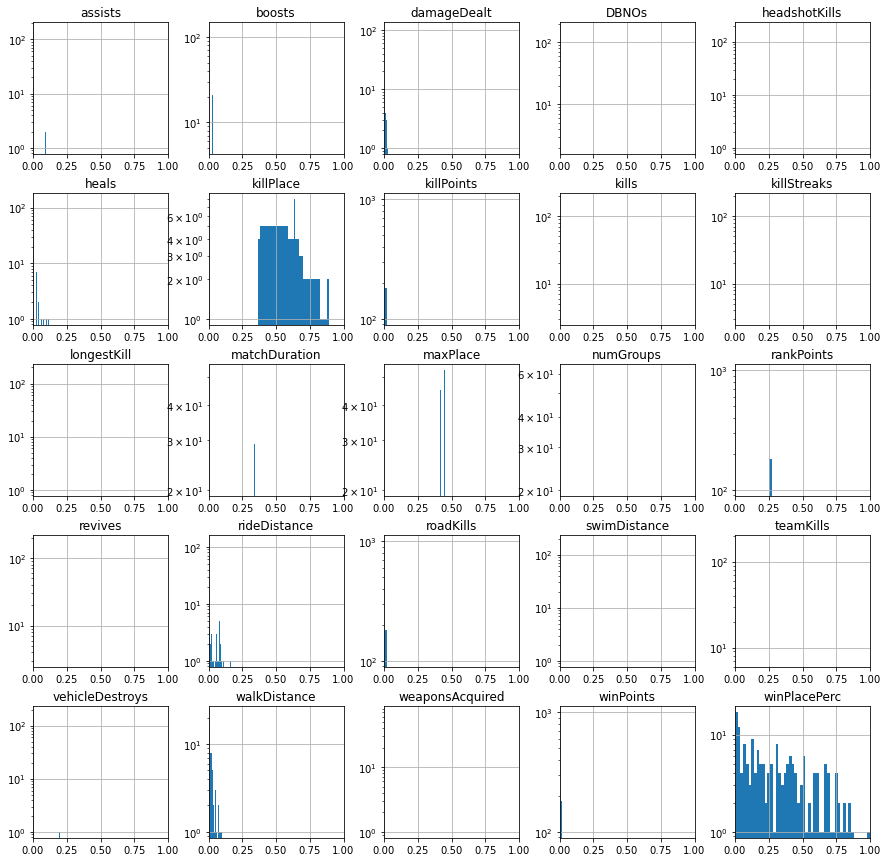

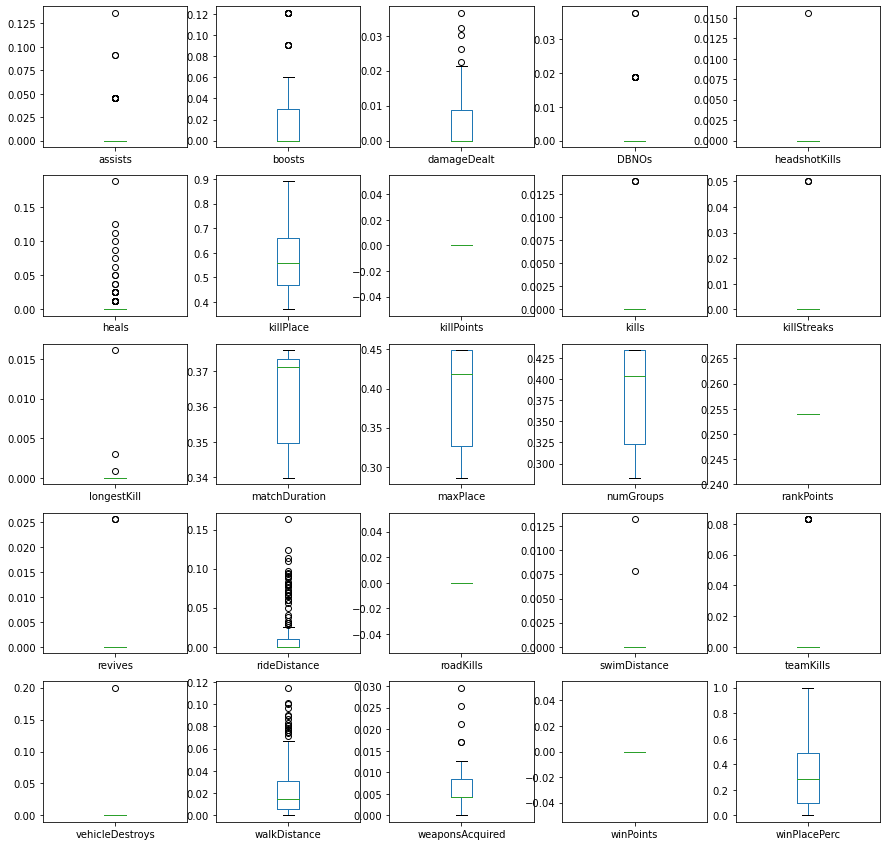

Cluster 2, average wpp = 0.6420303664921465


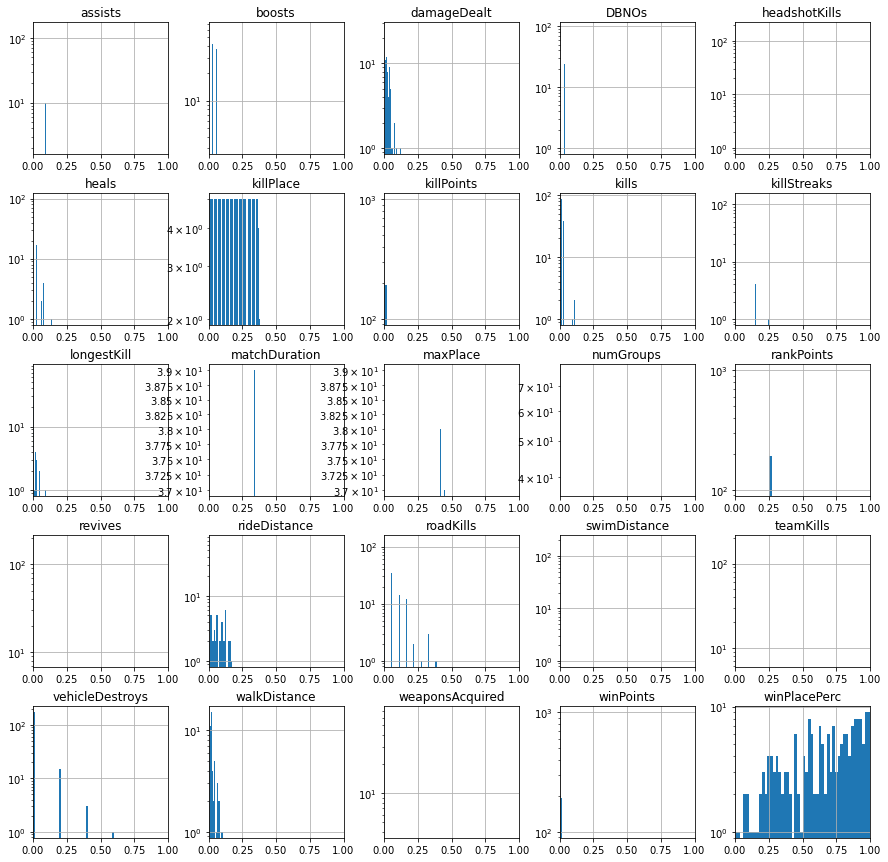

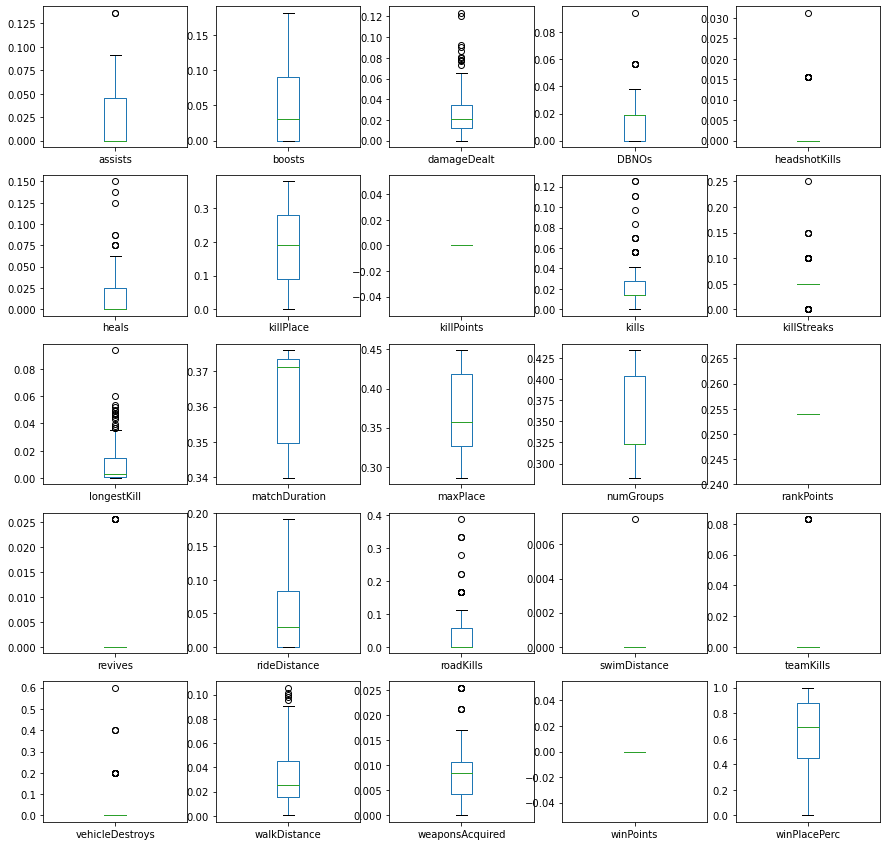

duo:
Cluster 1, average wpp = 0.479921832460193


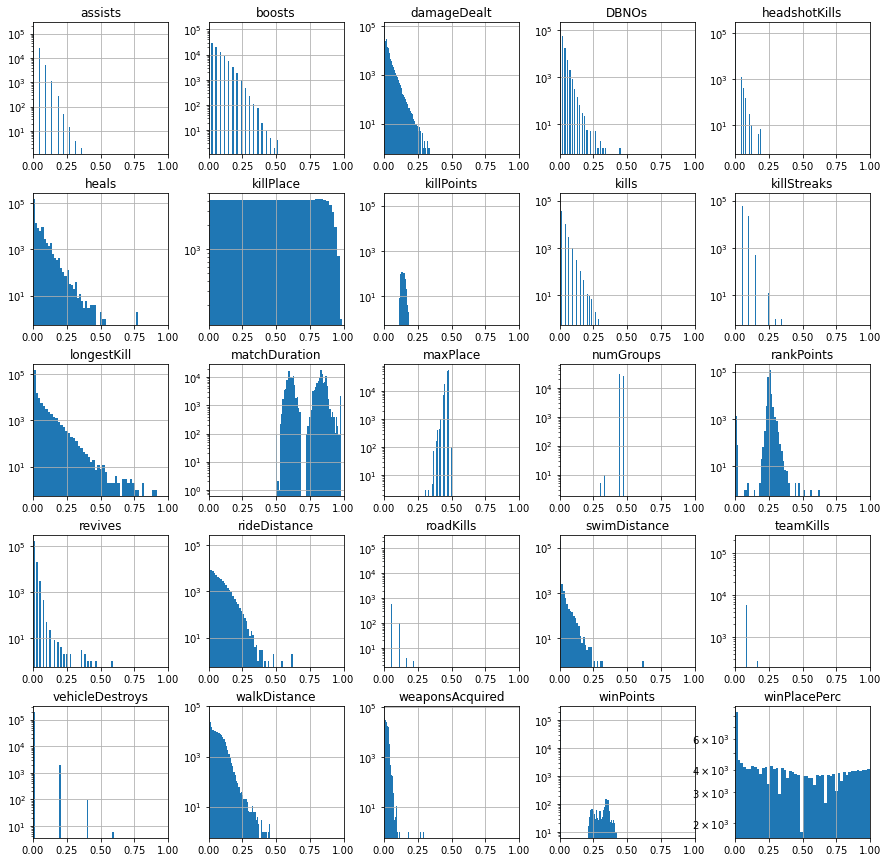

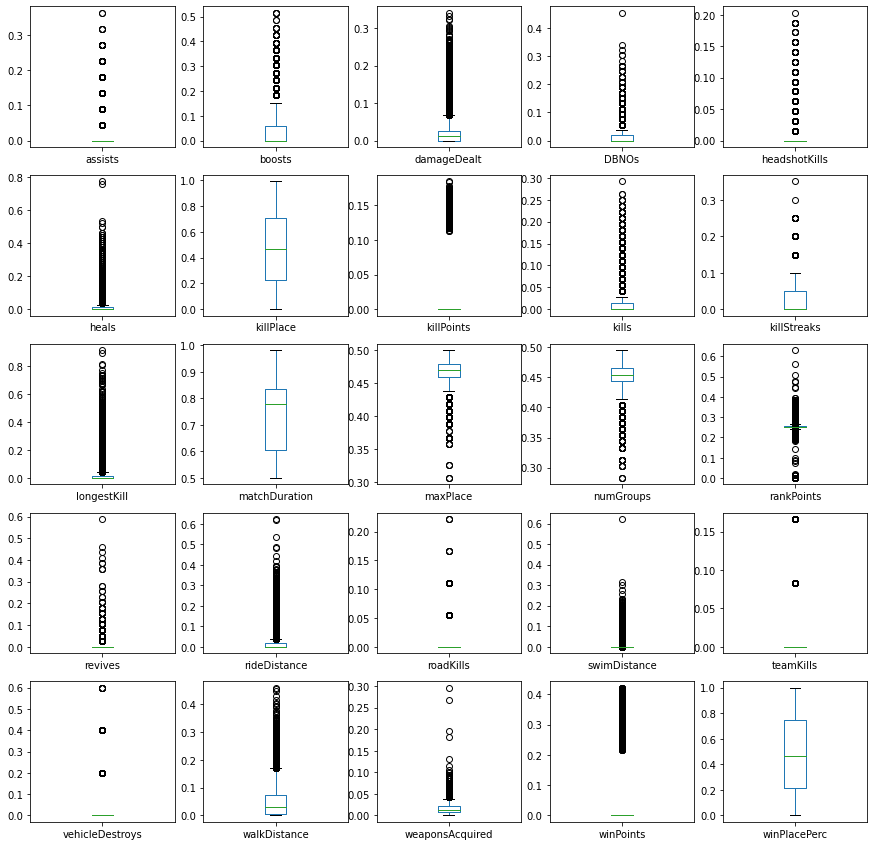

Cluster 2, average wpp = 0.4874042054239271


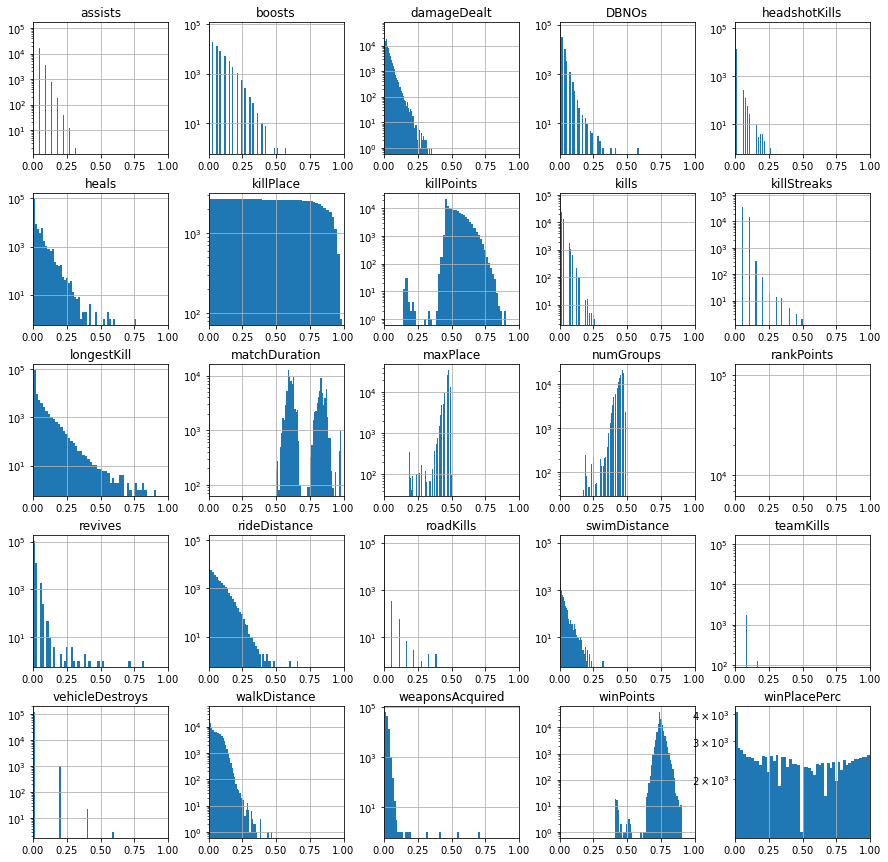

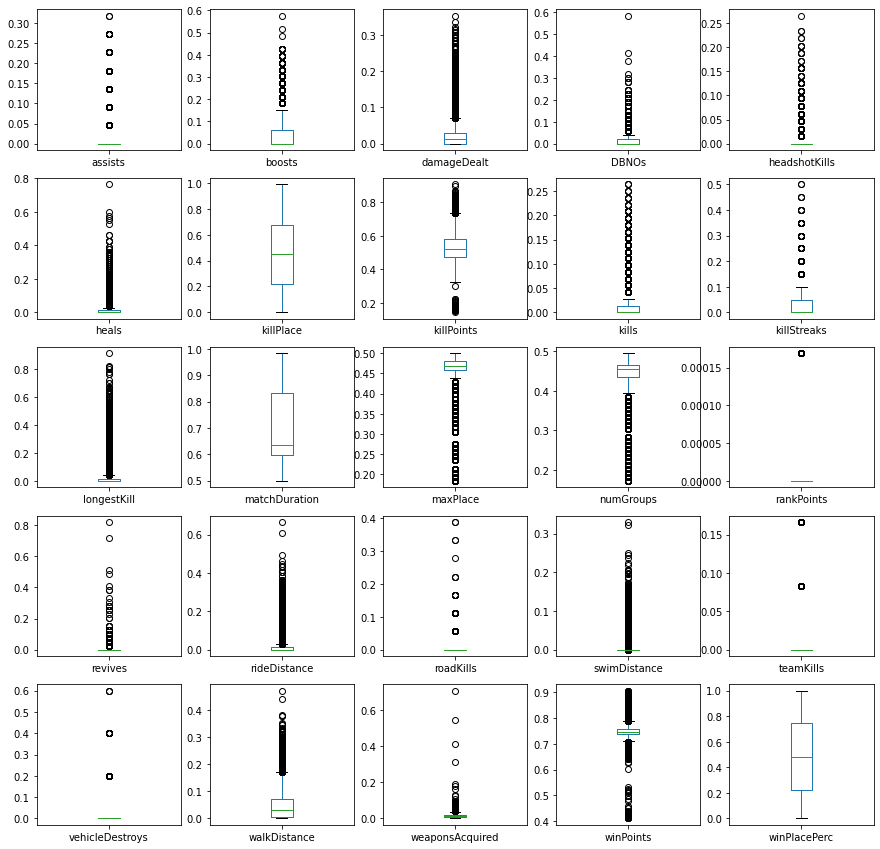

duo_fpp:
Cluster 1, average wpp = 0.48539267739921305


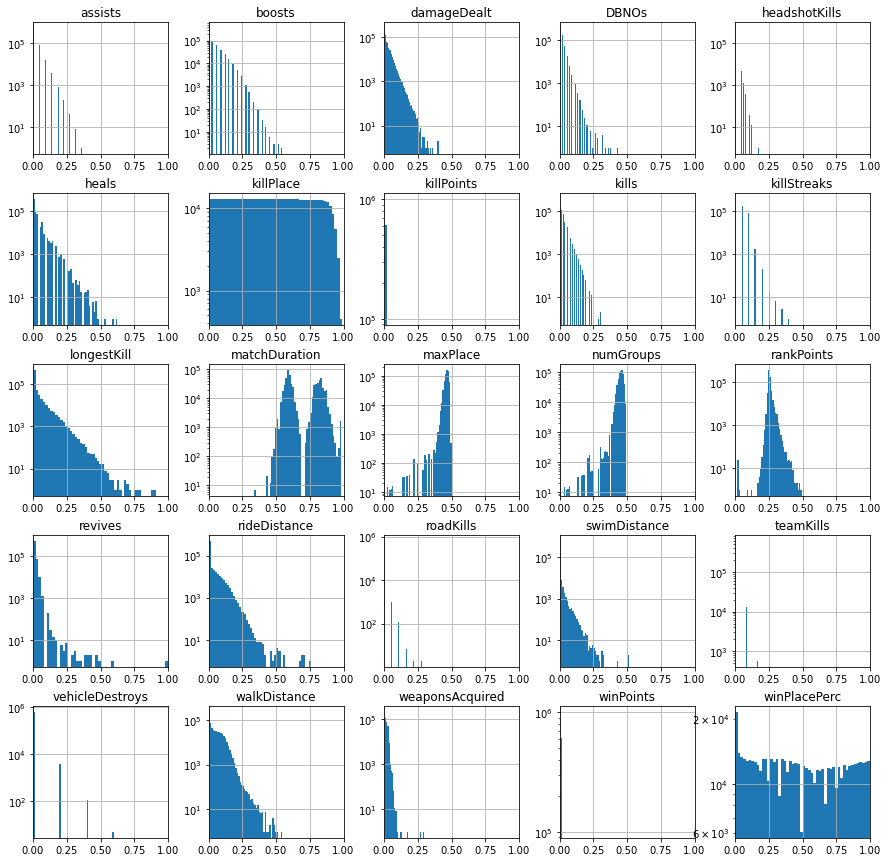

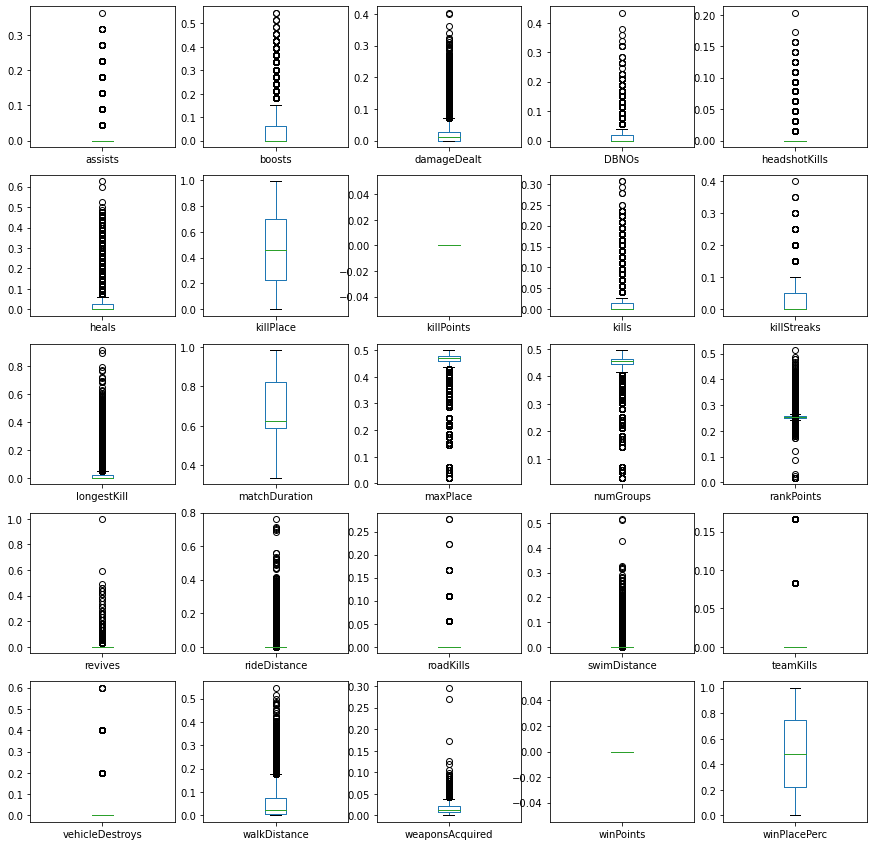

Cluster 2, average wpp = 0.48643379486589744


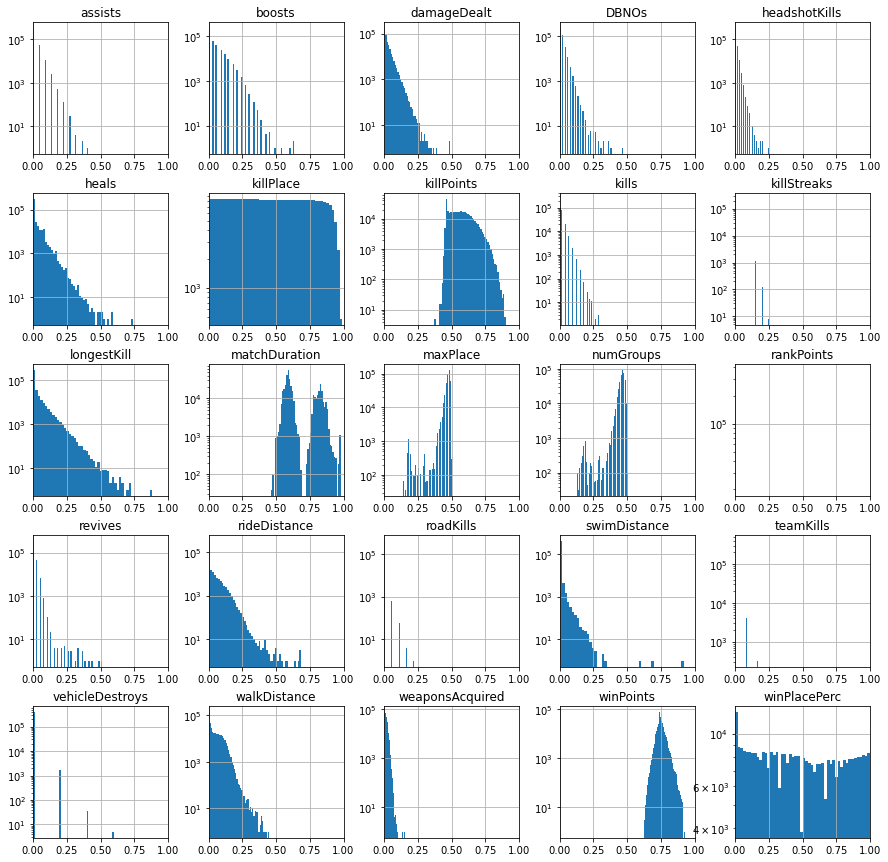

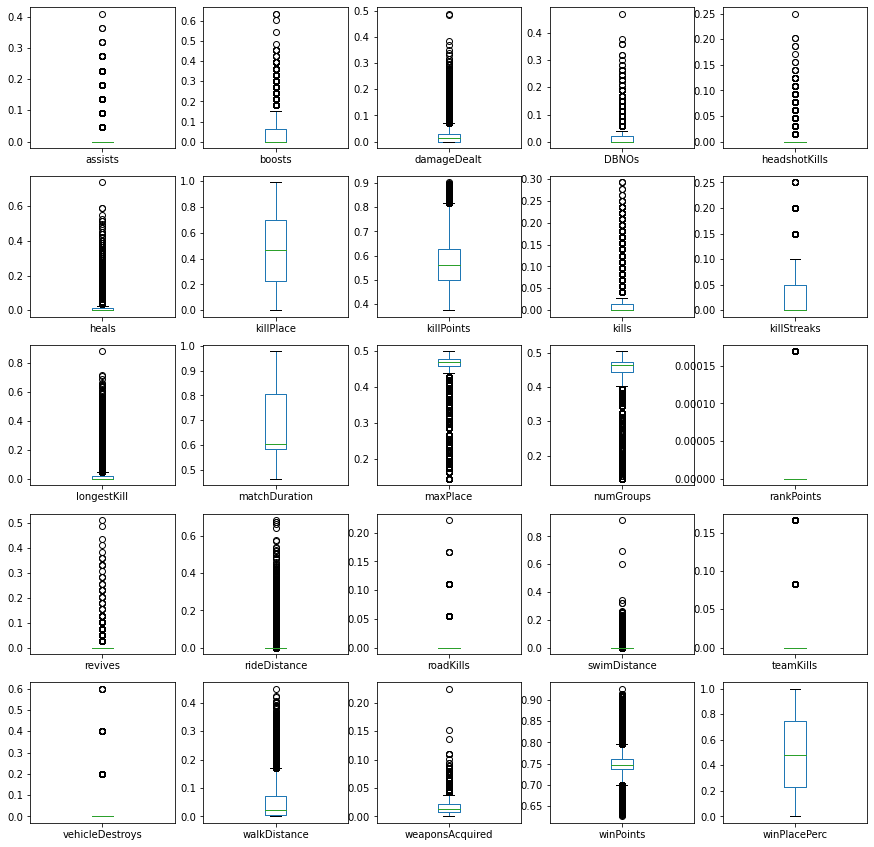

flarefpp:
Cluster 1, average wpp = 0.2585386706948641


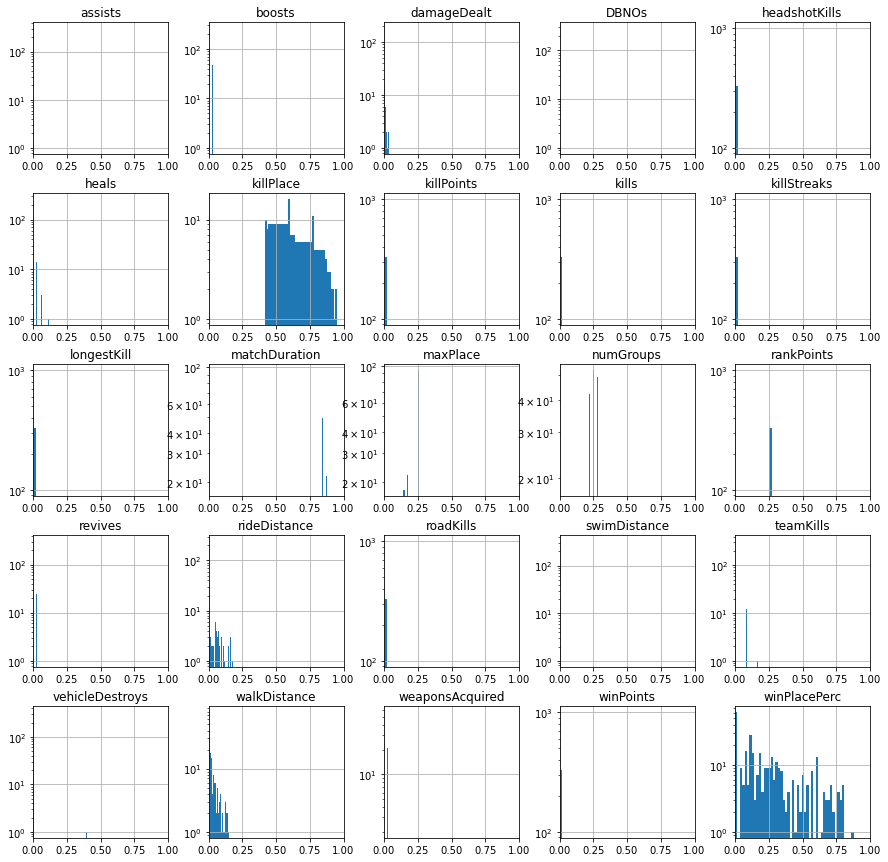

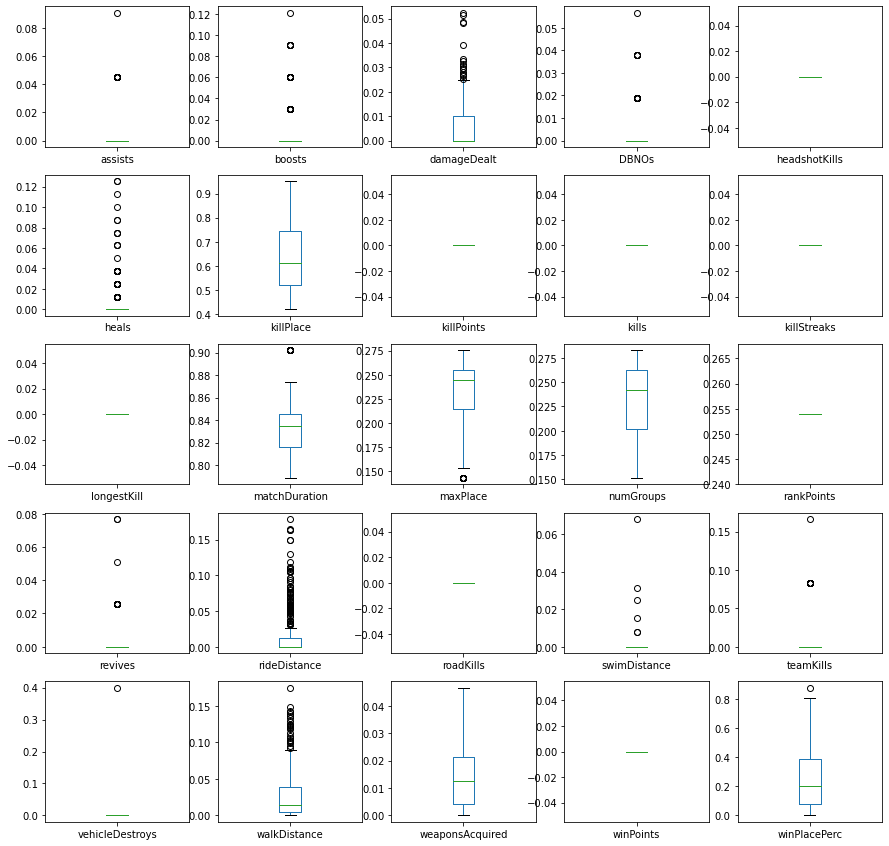

Cluster 2, average wpp = 0.6164552971576227


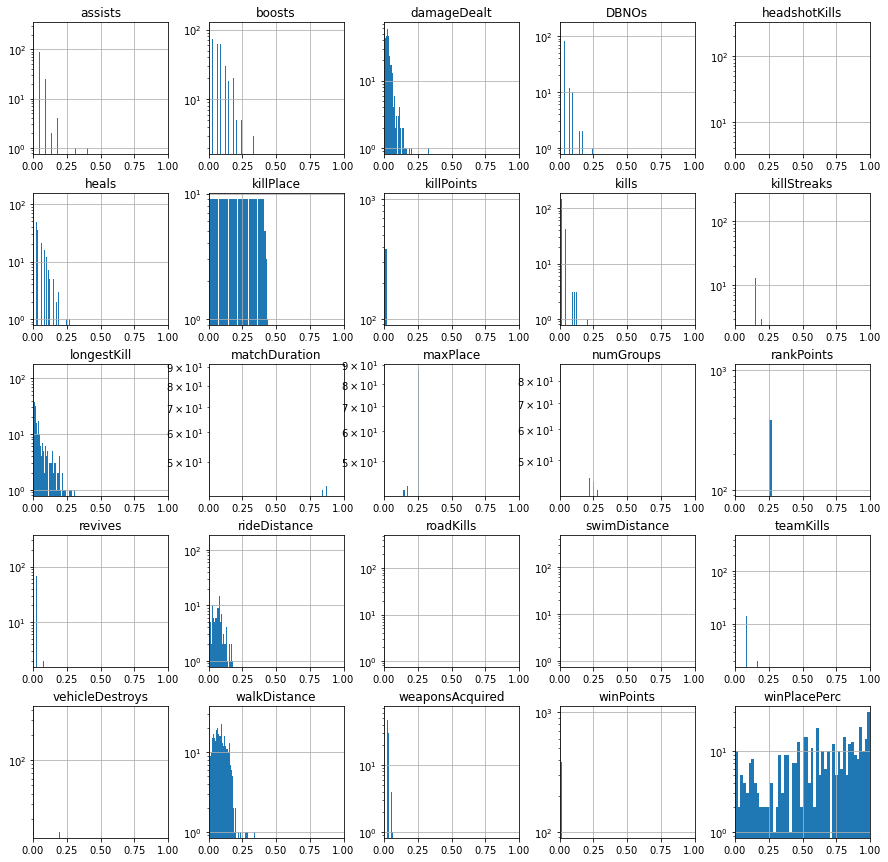

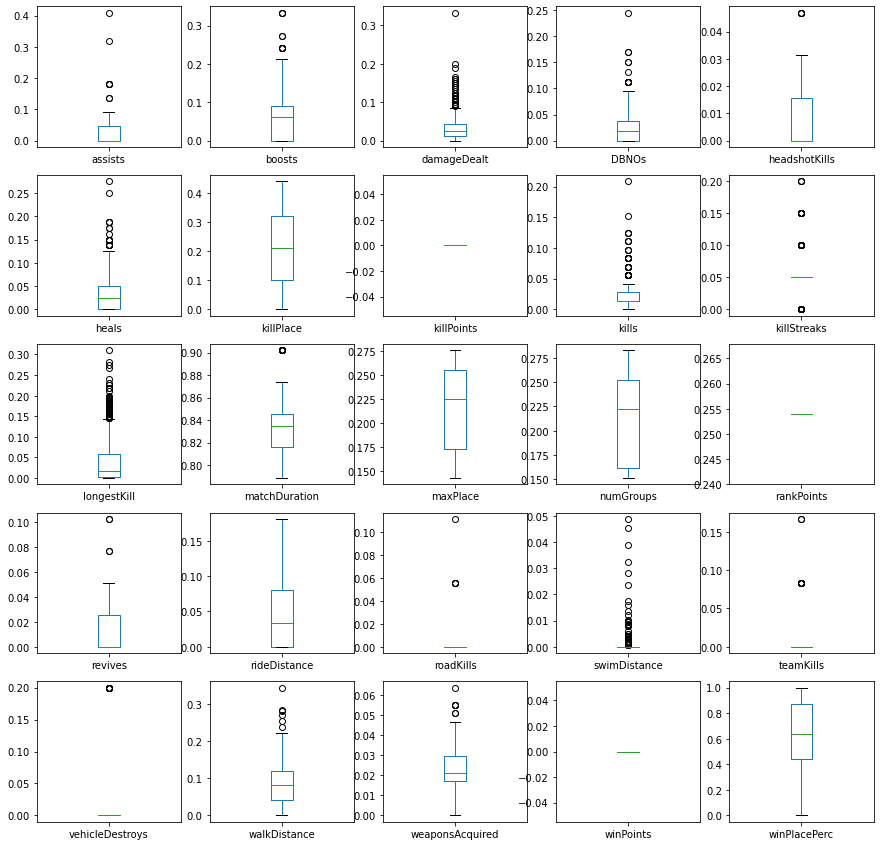

flaretpp:
Cluster 1, average wpp = 0.2408252268602541


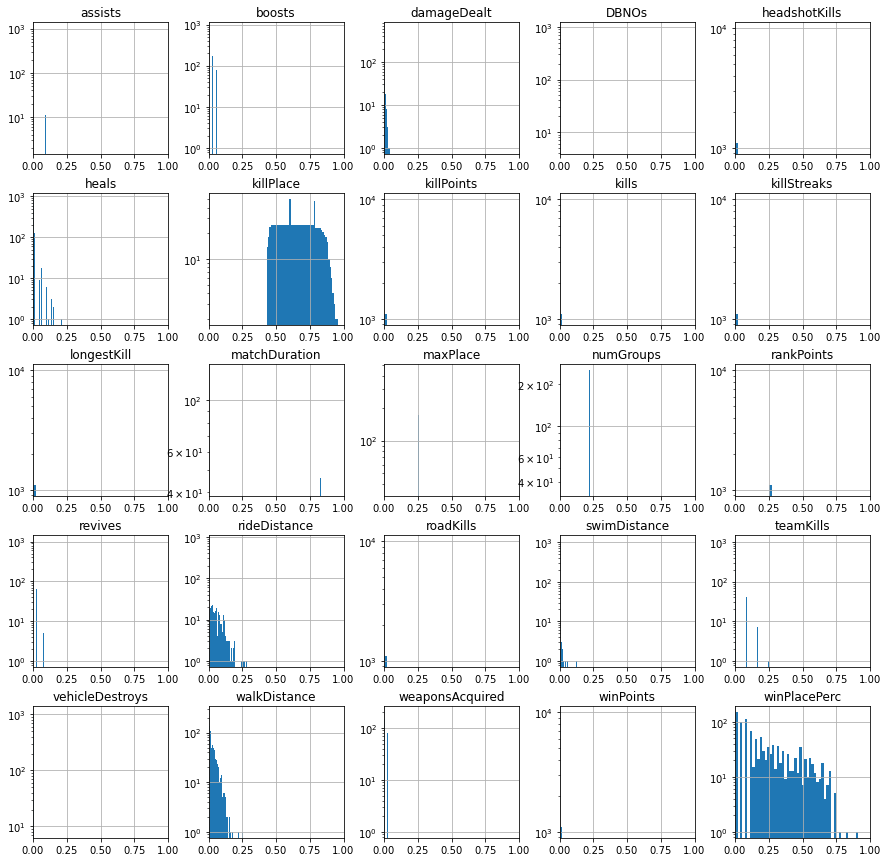

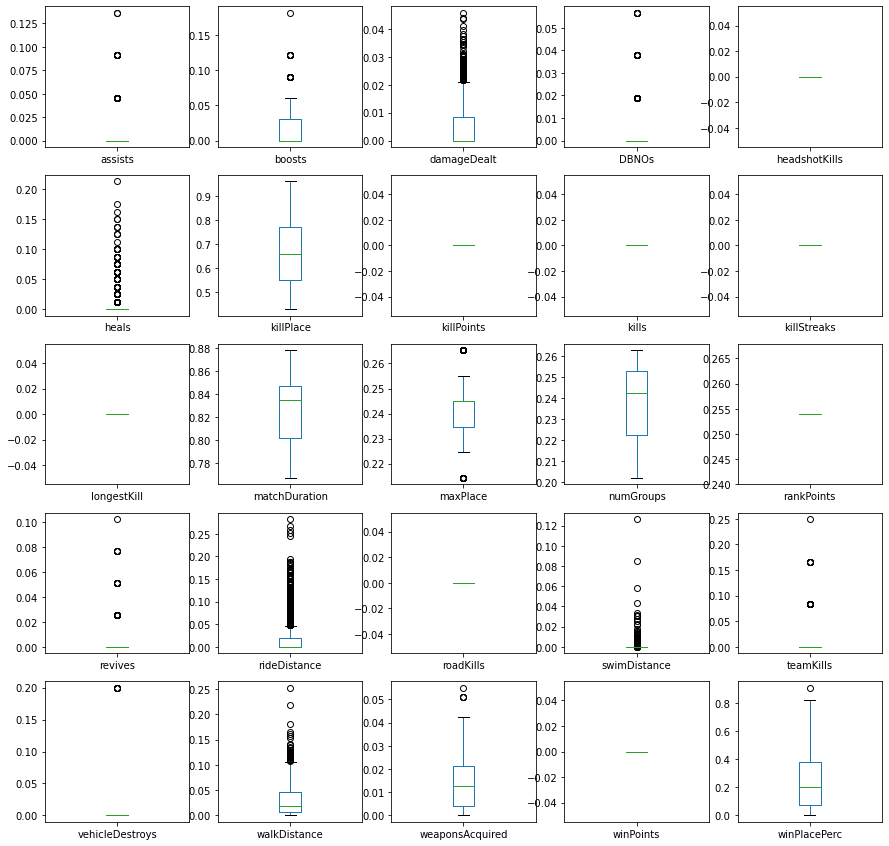

Cluster 2, average wpp = 0.6253160857908847


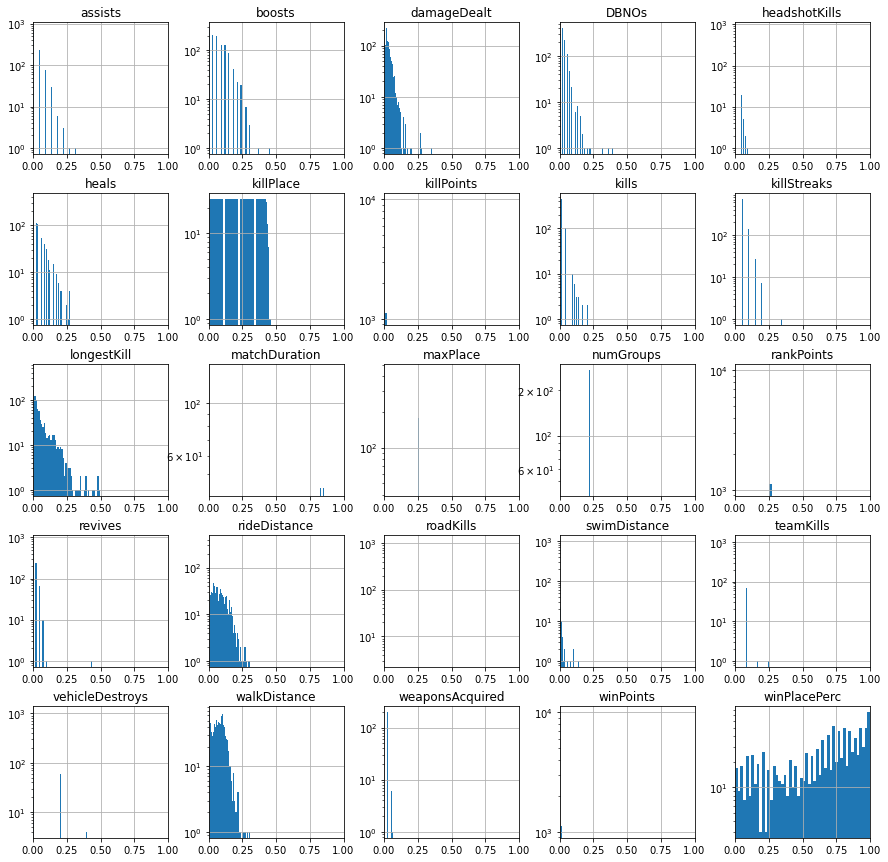

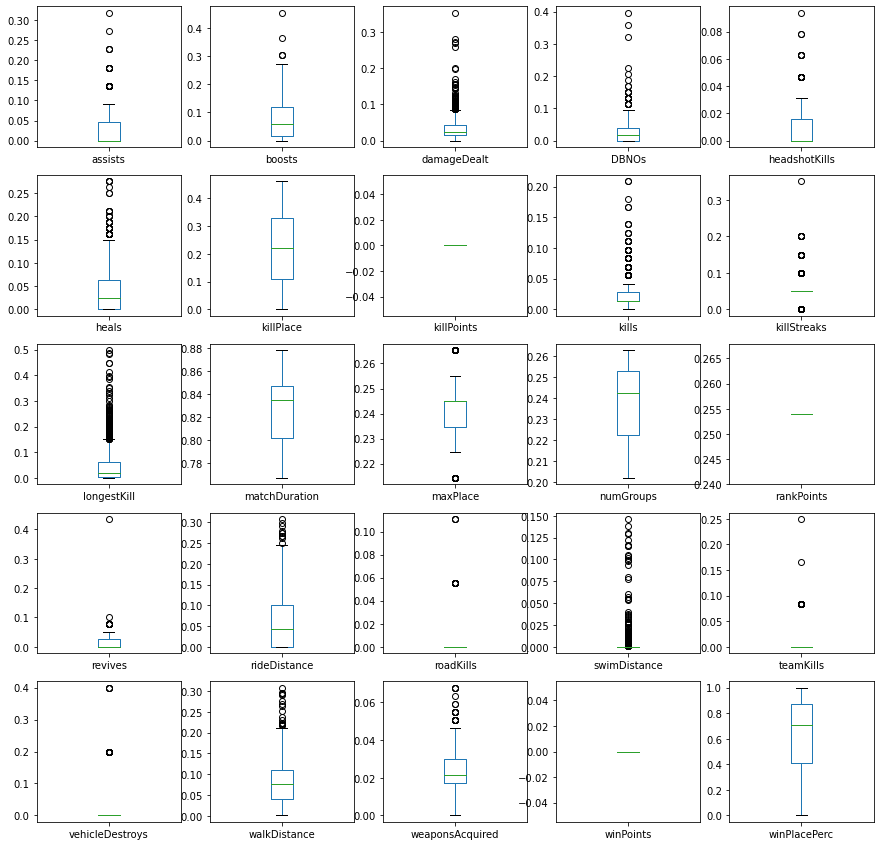

Cluster 3, average wpp = 0.4349760563380282


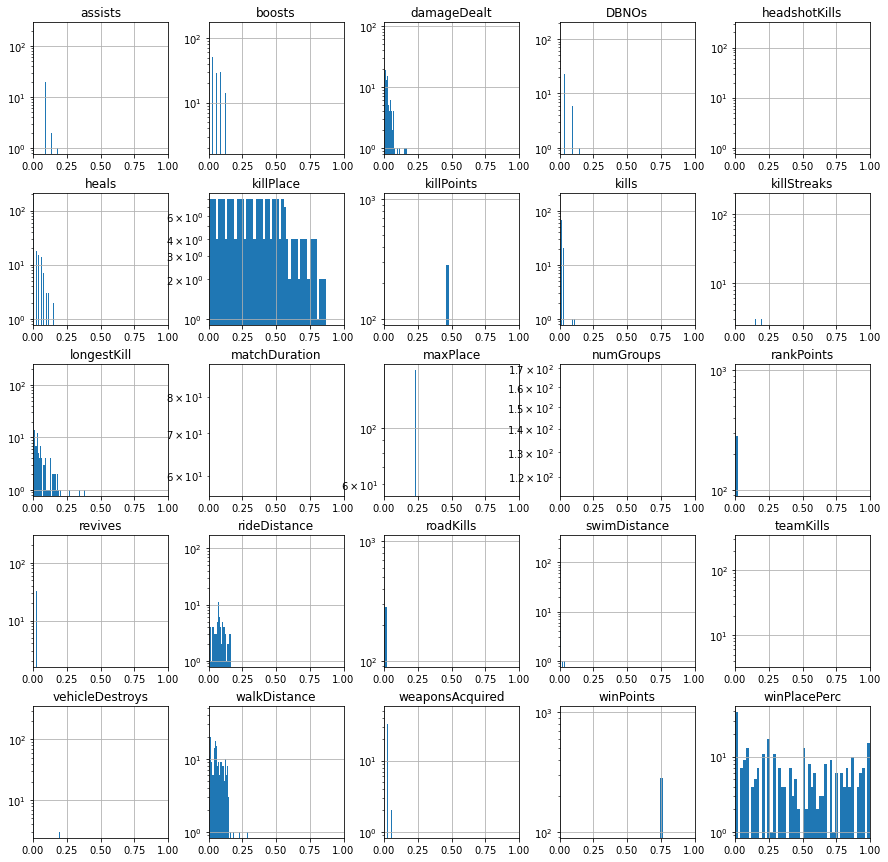

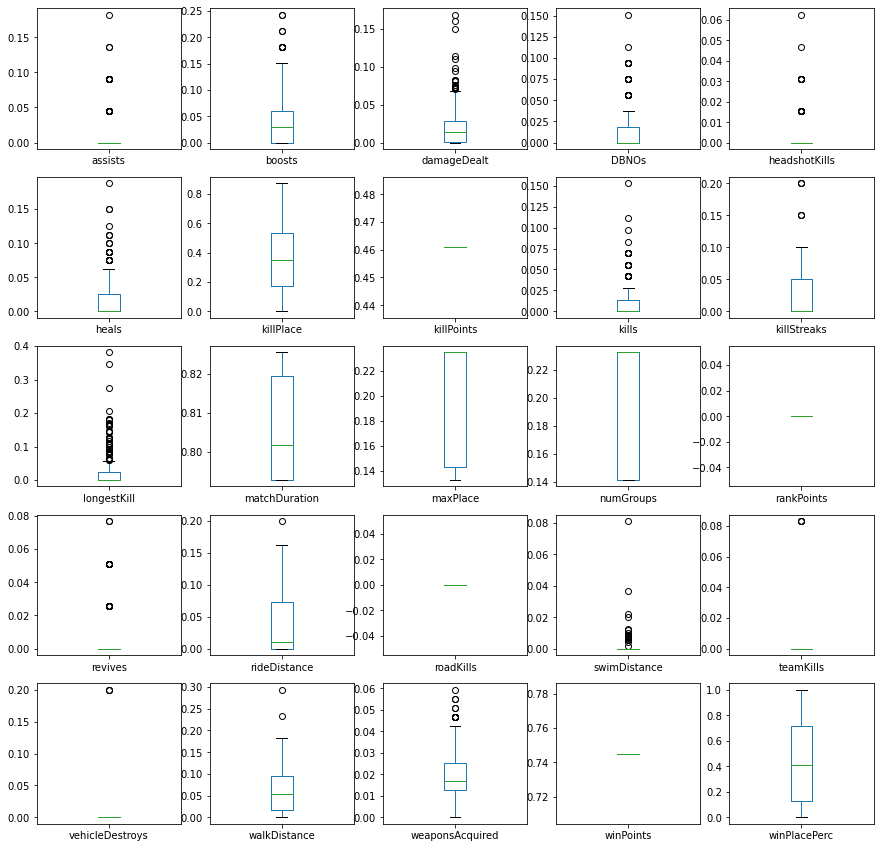

normal_duo:
Cluster 1, average wpp = 0.5123731343283582


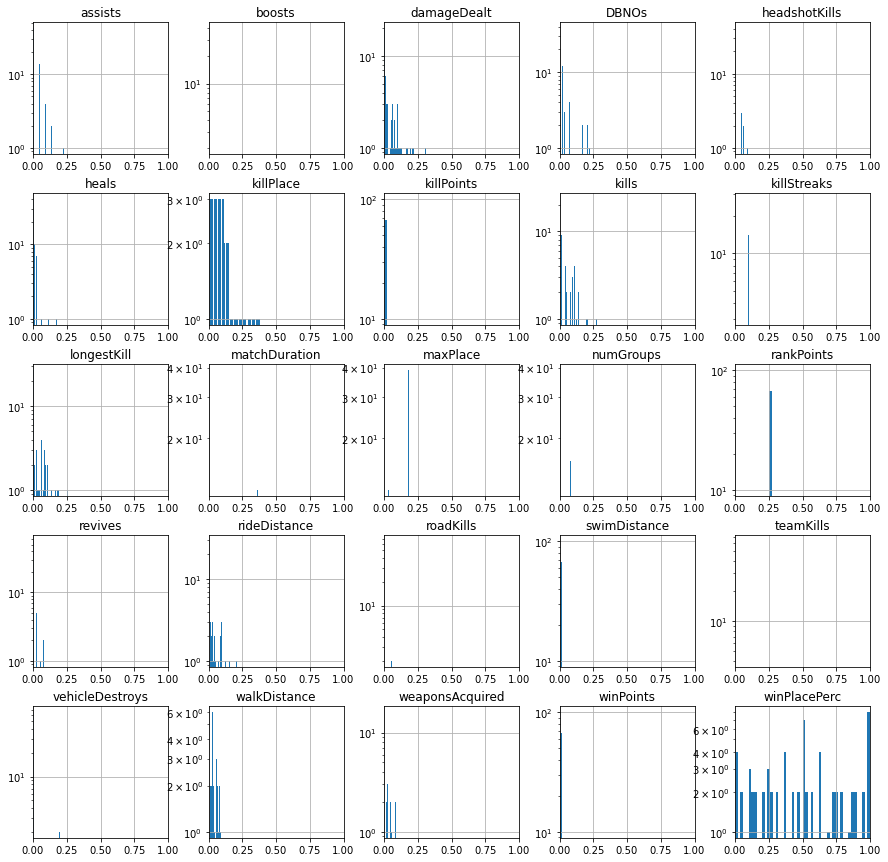

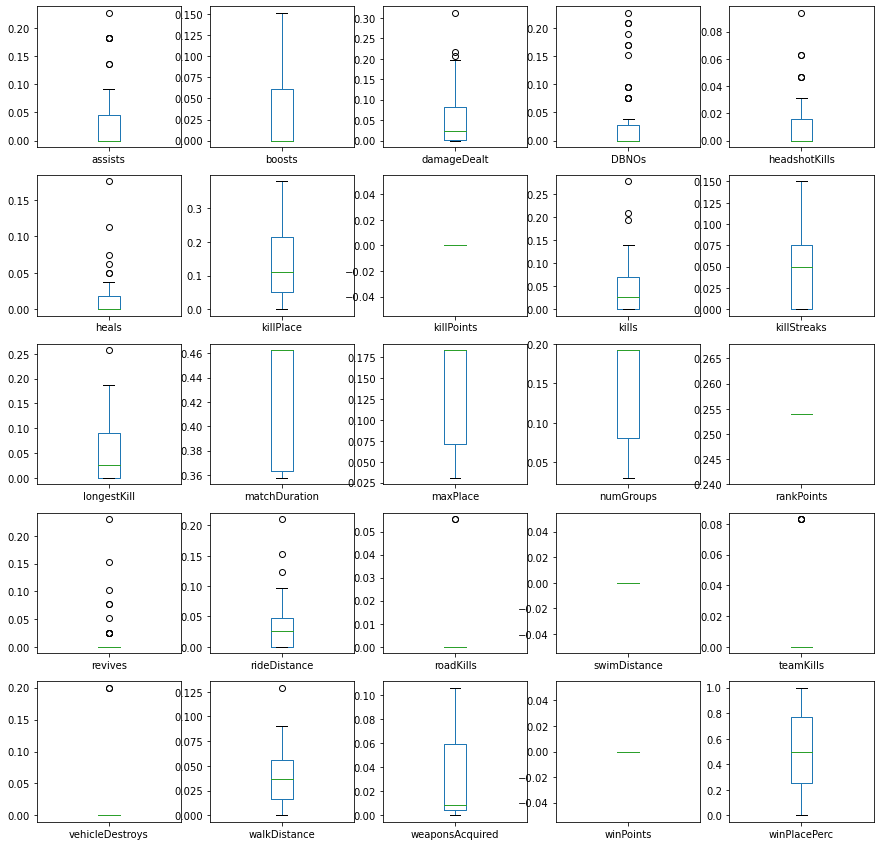

Cluster 2, average wpp = 0.515814393939394


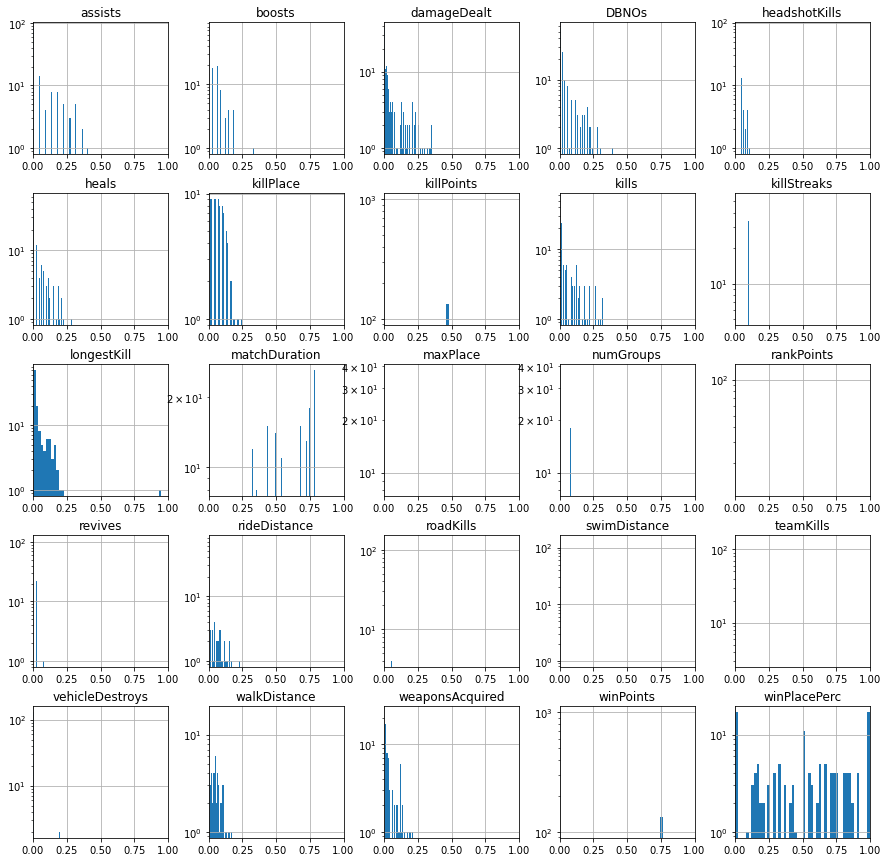

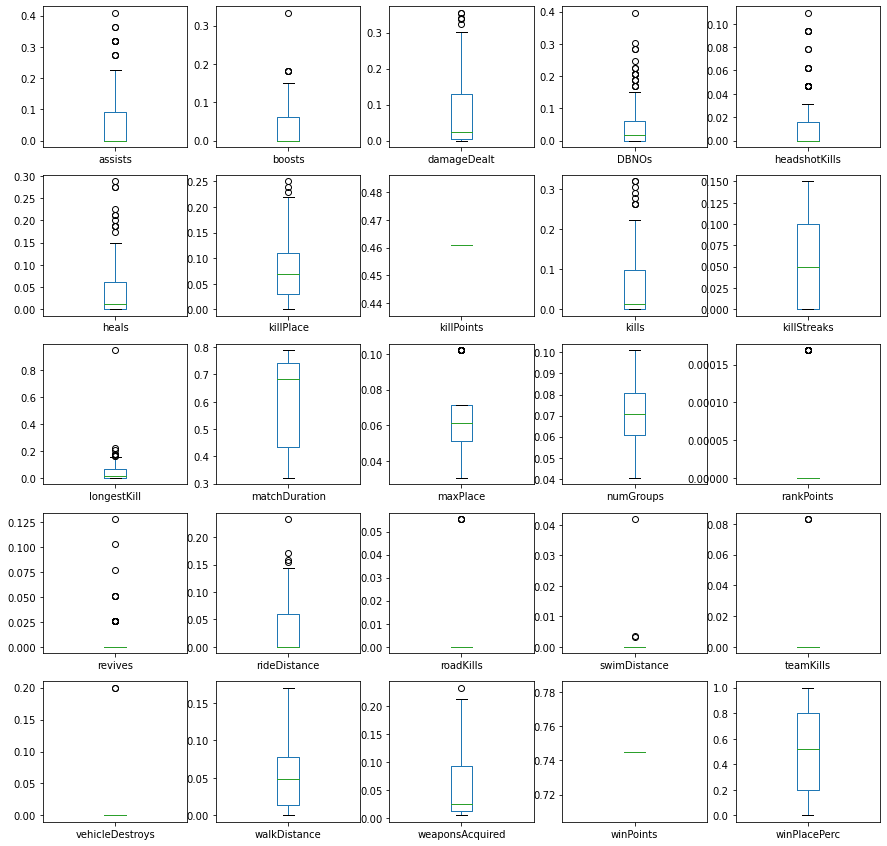

normal_duo_fpp:
Cluster 1, average wpp = 0.5043781655844156


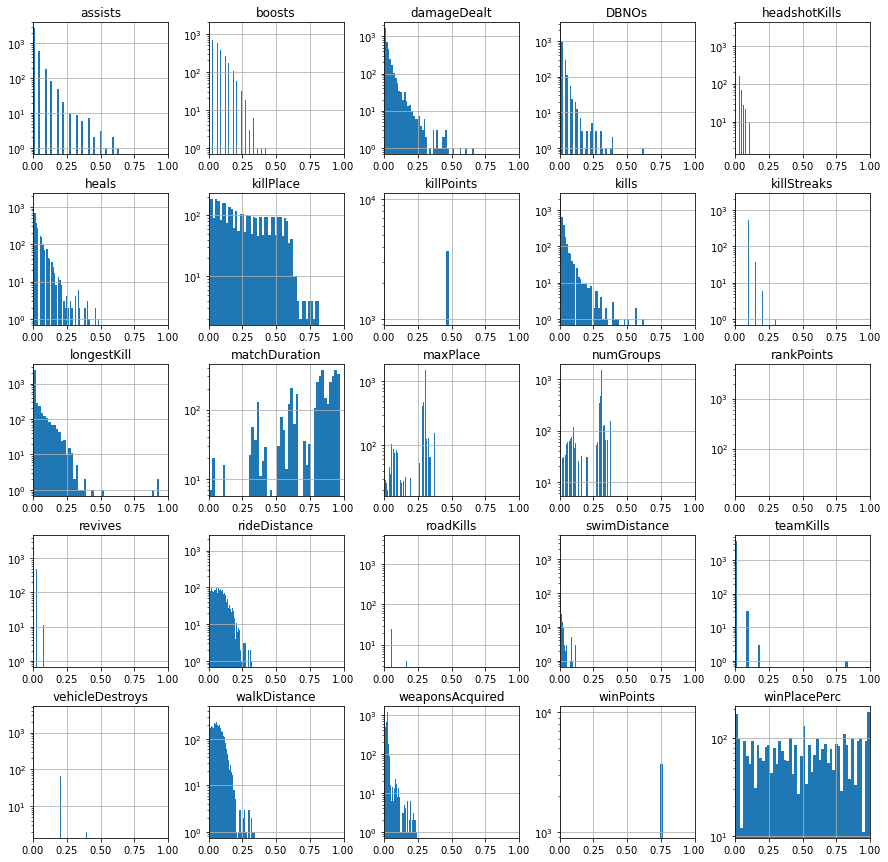

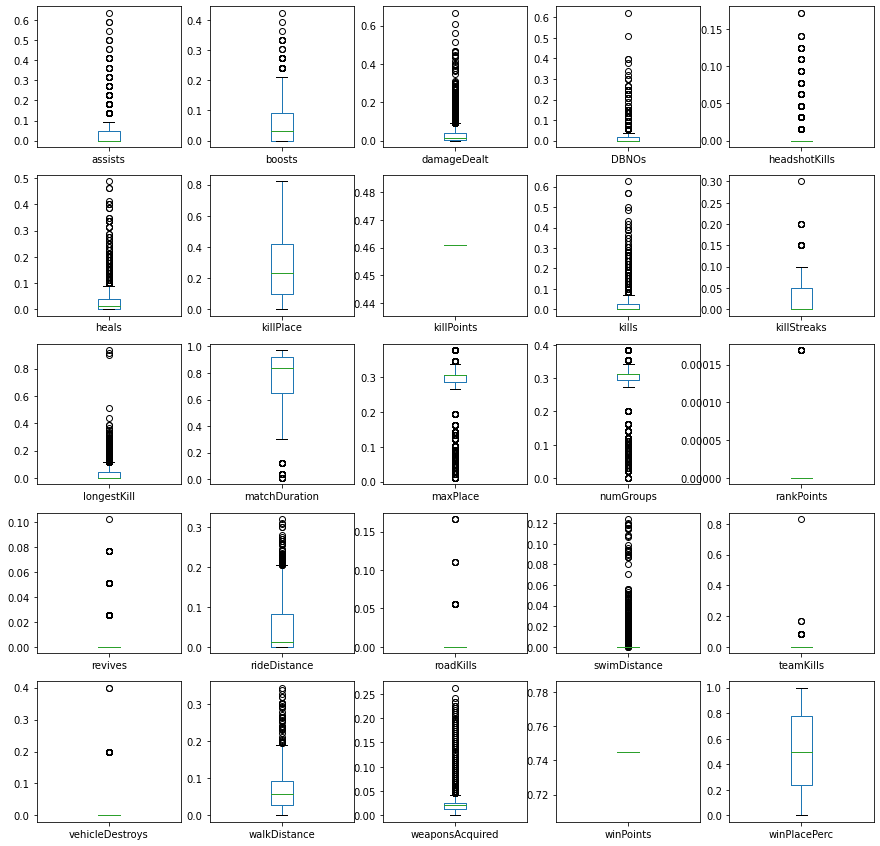

Cluster 2, average wpp = 0.5160018404907976


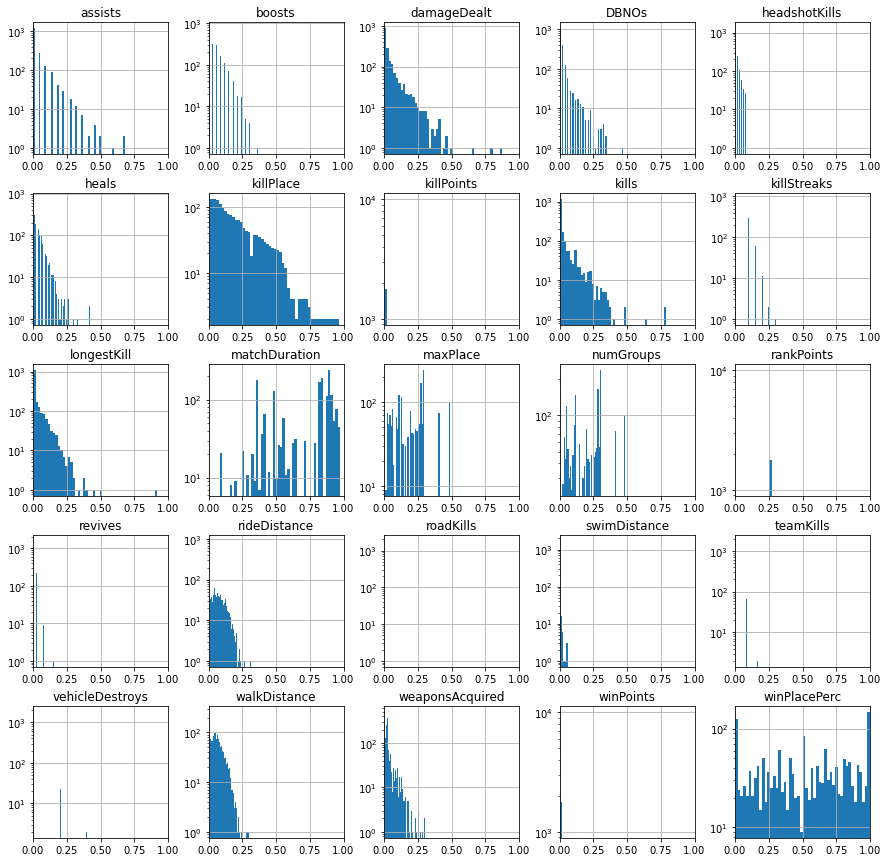

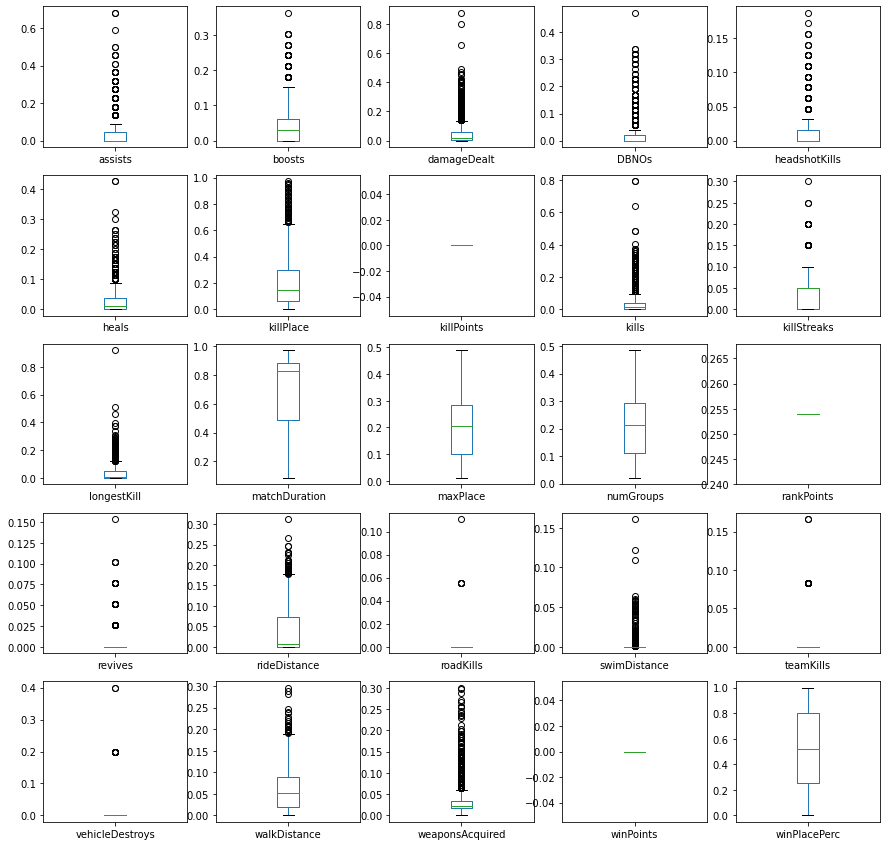

normal_solo:
Cluster 1, average wpp = 0.5842393665158371


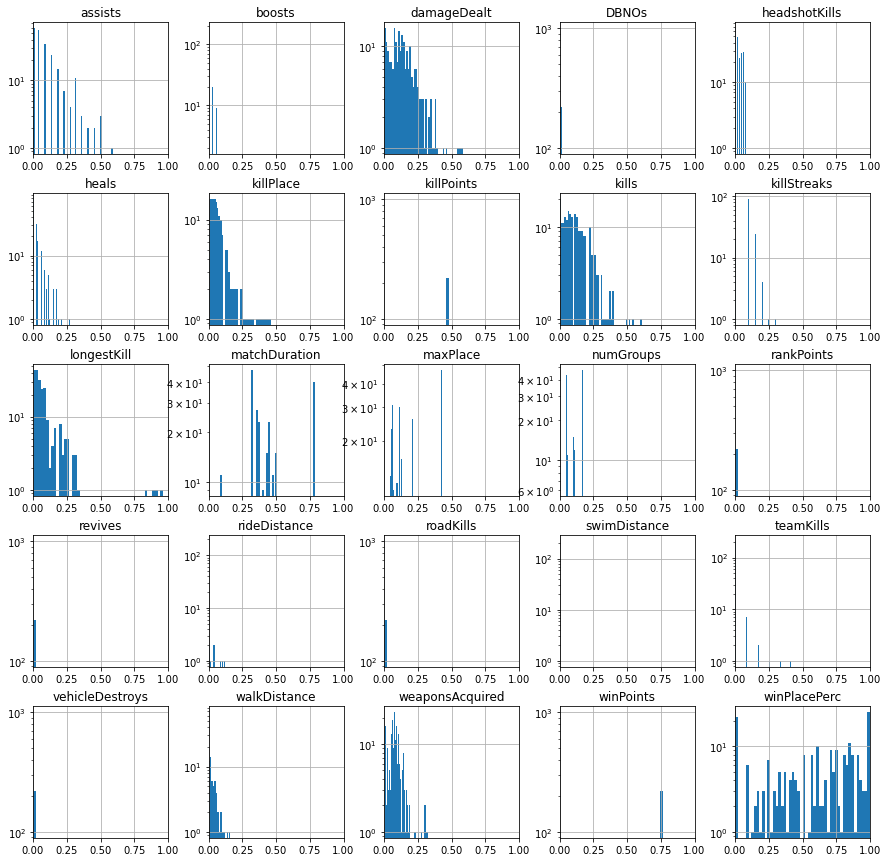

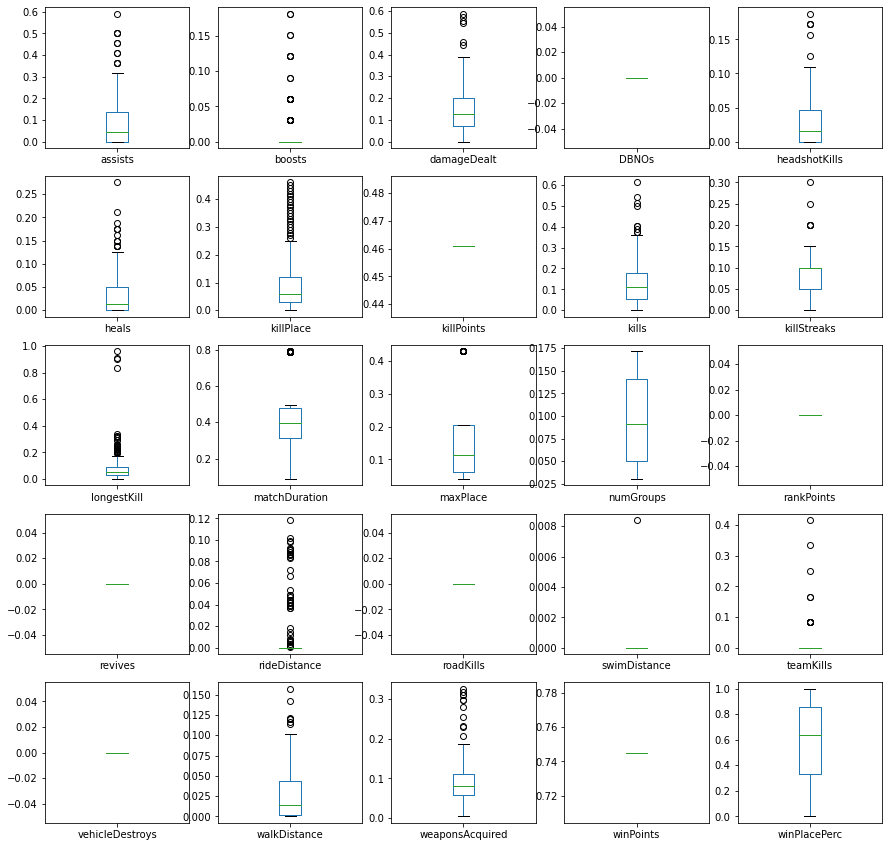

Cluster 2, average wpp = 0.5149180952380953


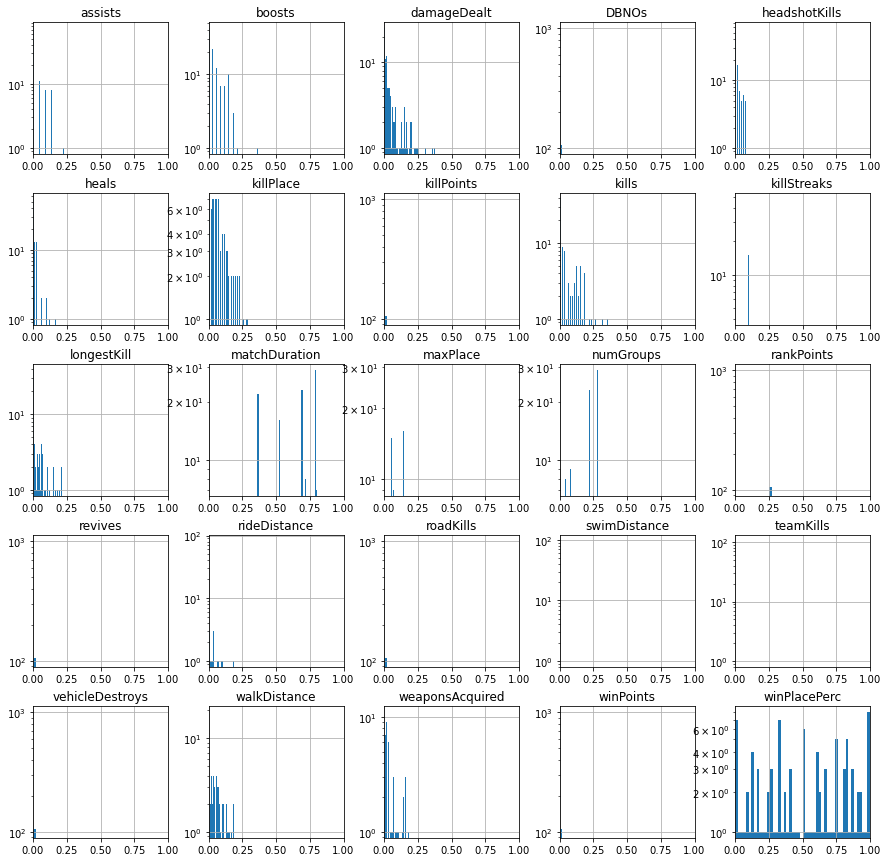

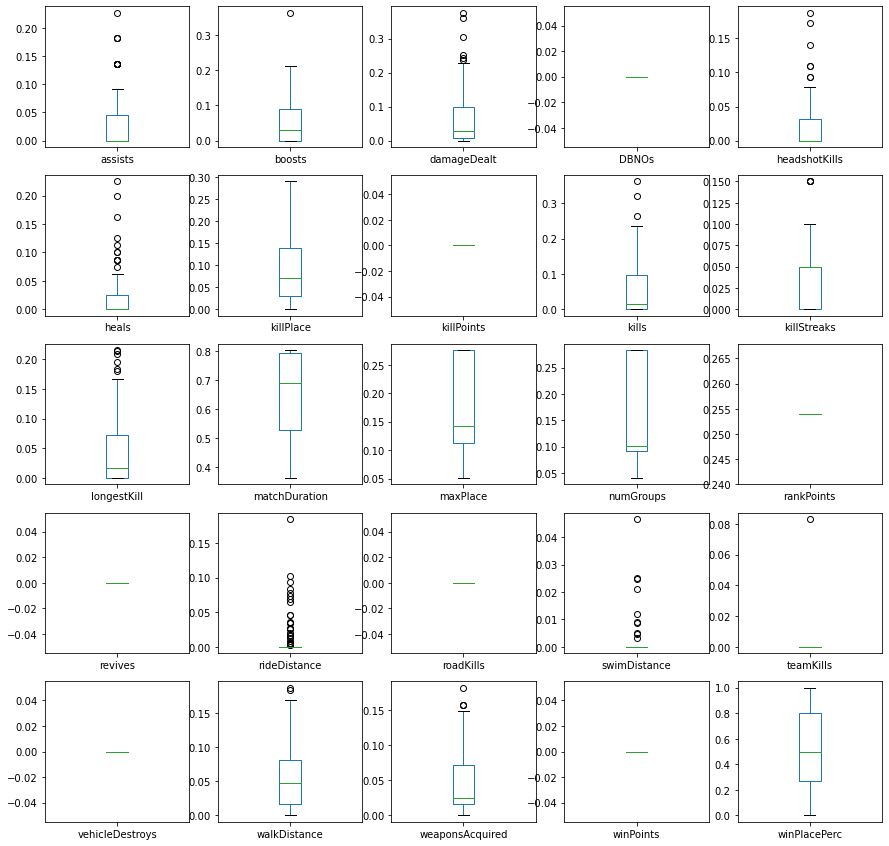

normal_solo_fpp:
Cluster 1, average wpp = 0.5501387964148527


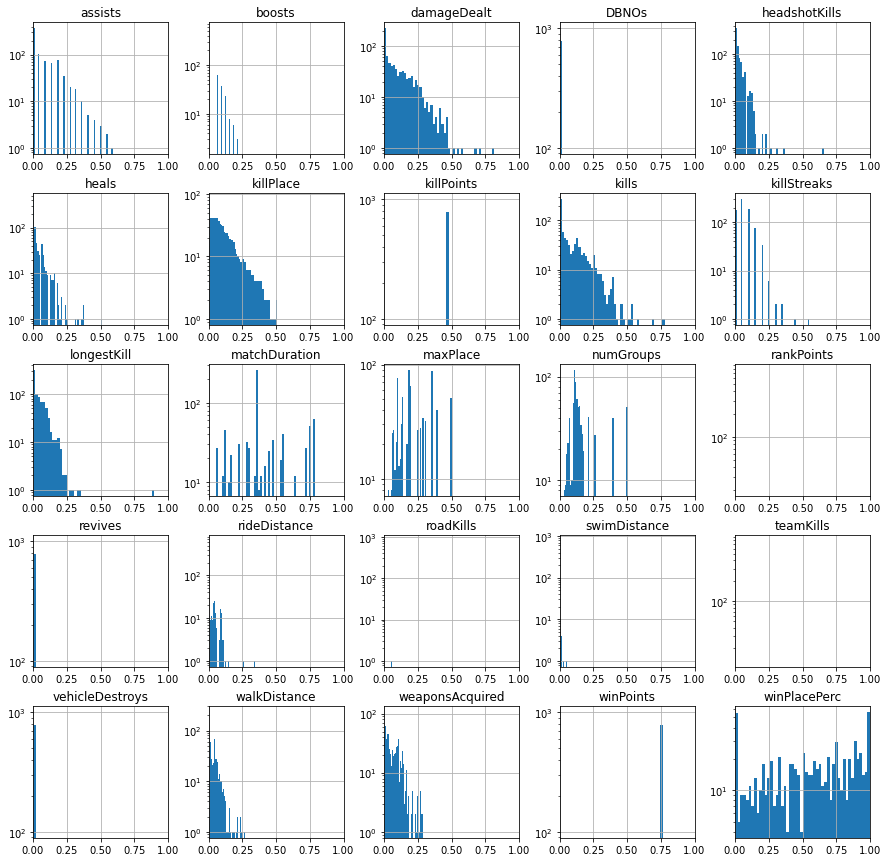

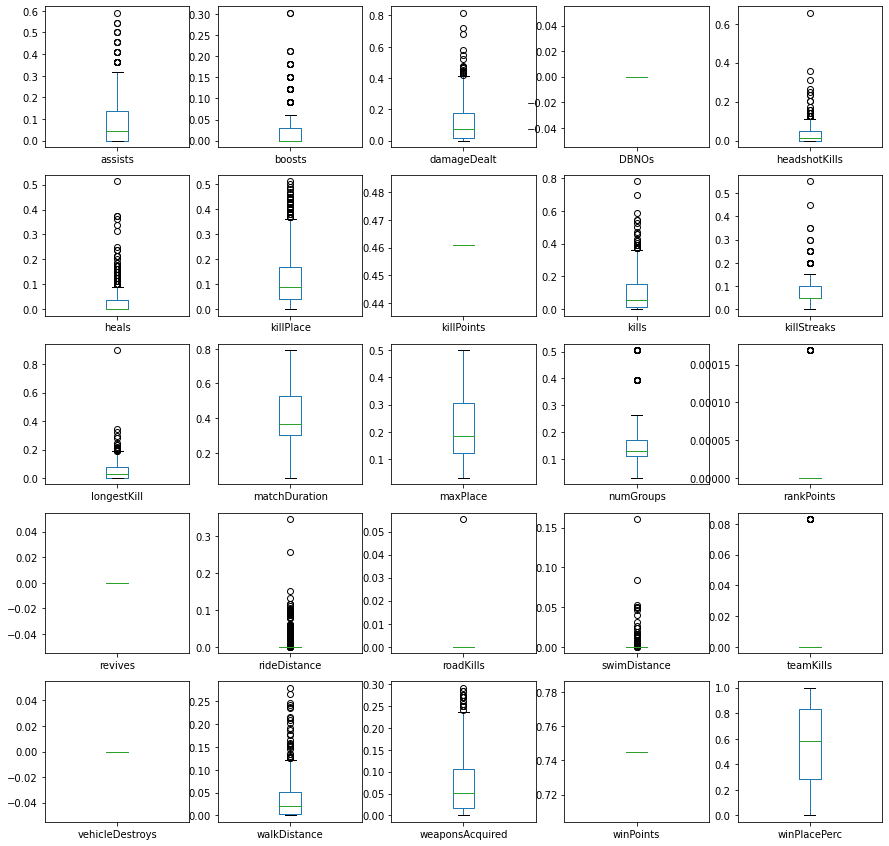

Cluster 2, average wpp = 0.5579577136514984


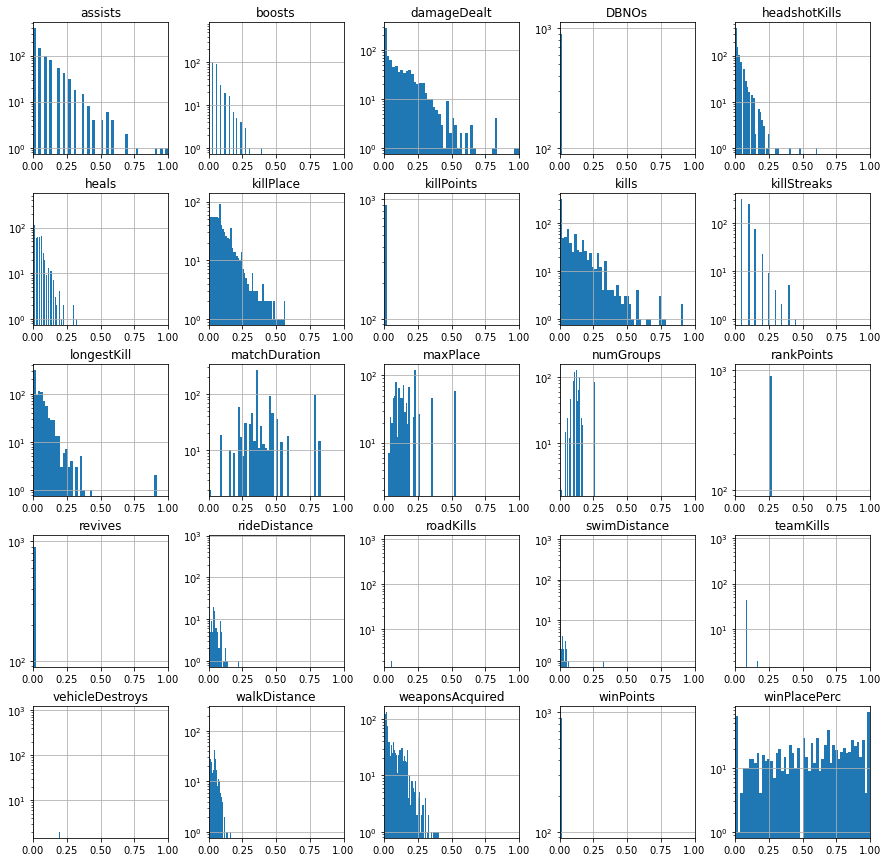

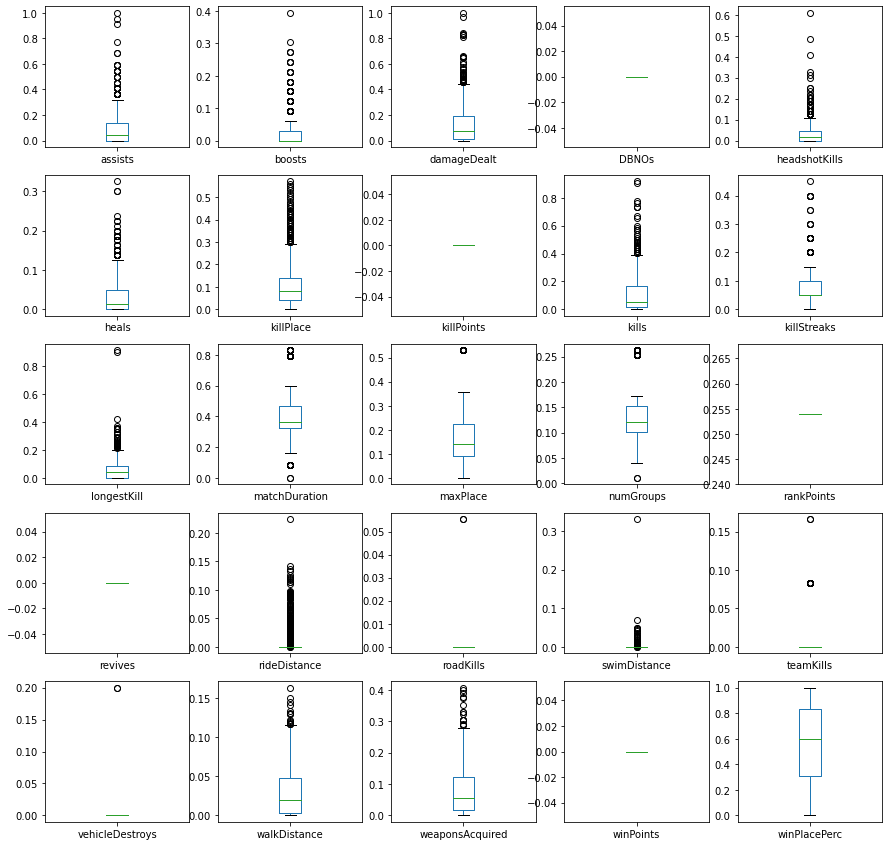

normal_squad:
Cluster 1, average wpp = 0.519322911051213


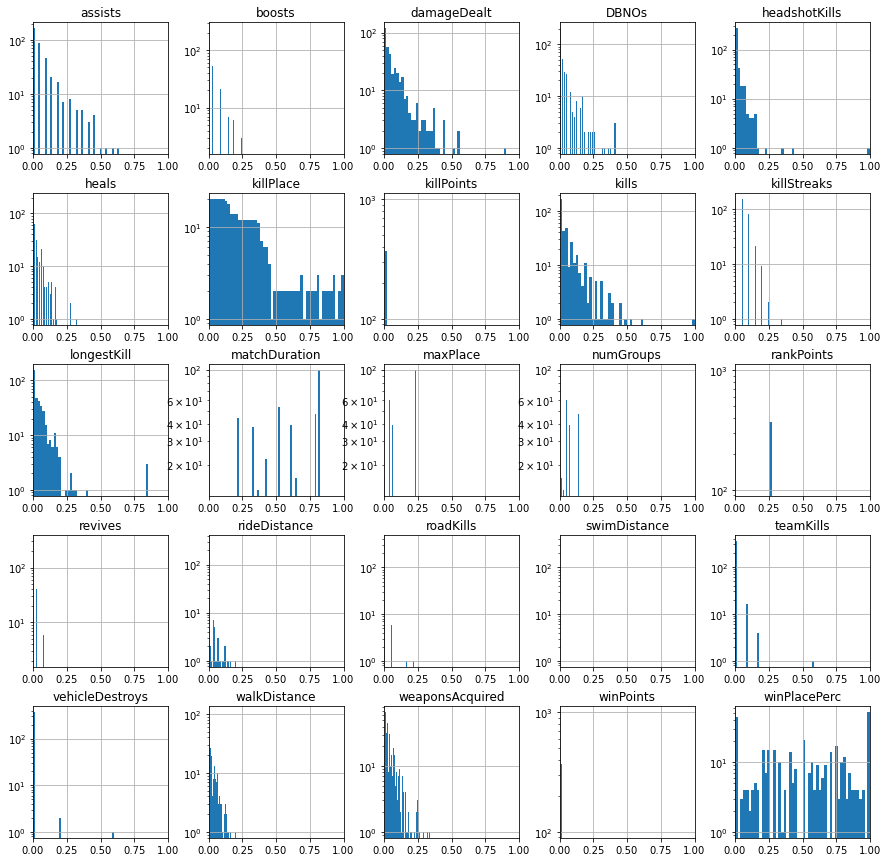

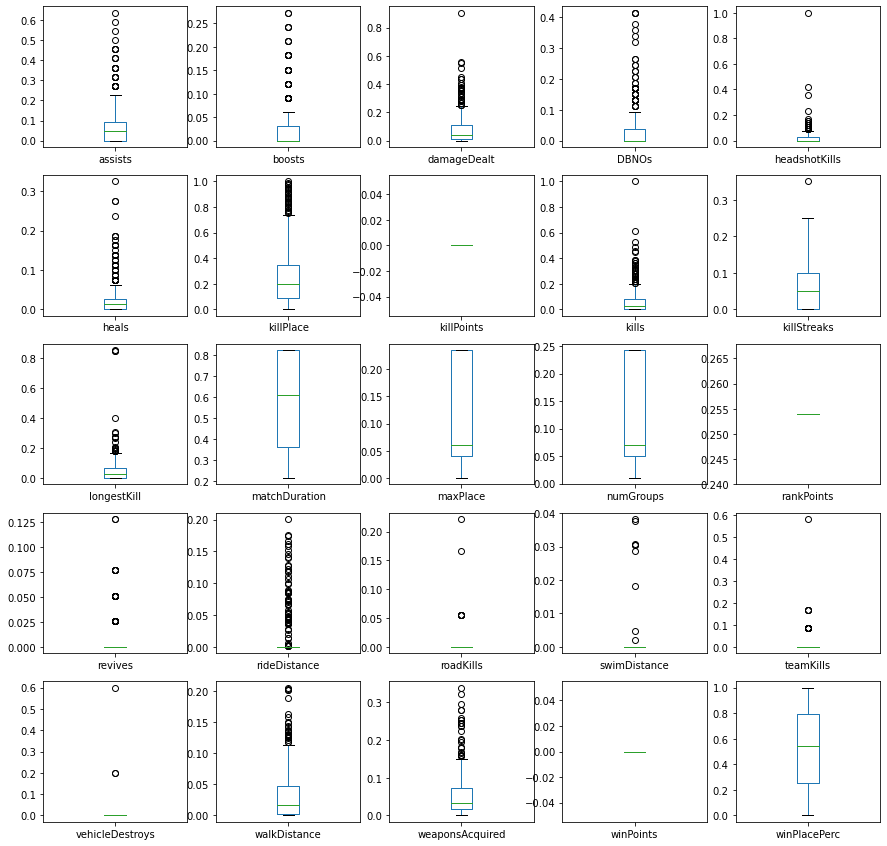

Cluster 2, average wpp = 0.5379620689655172


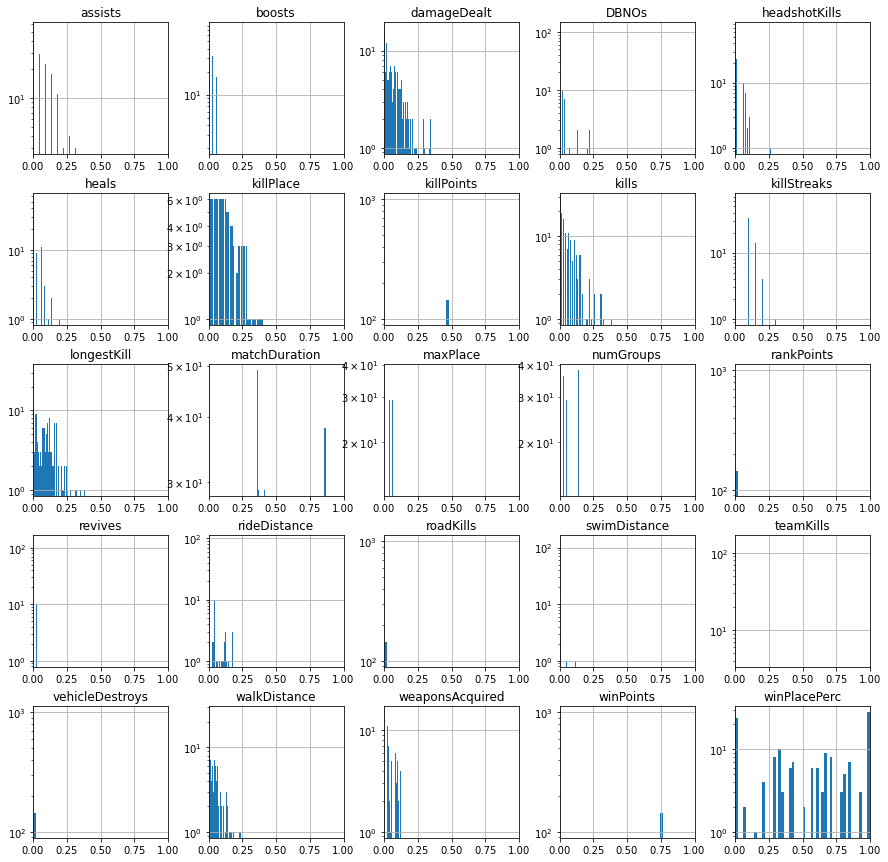

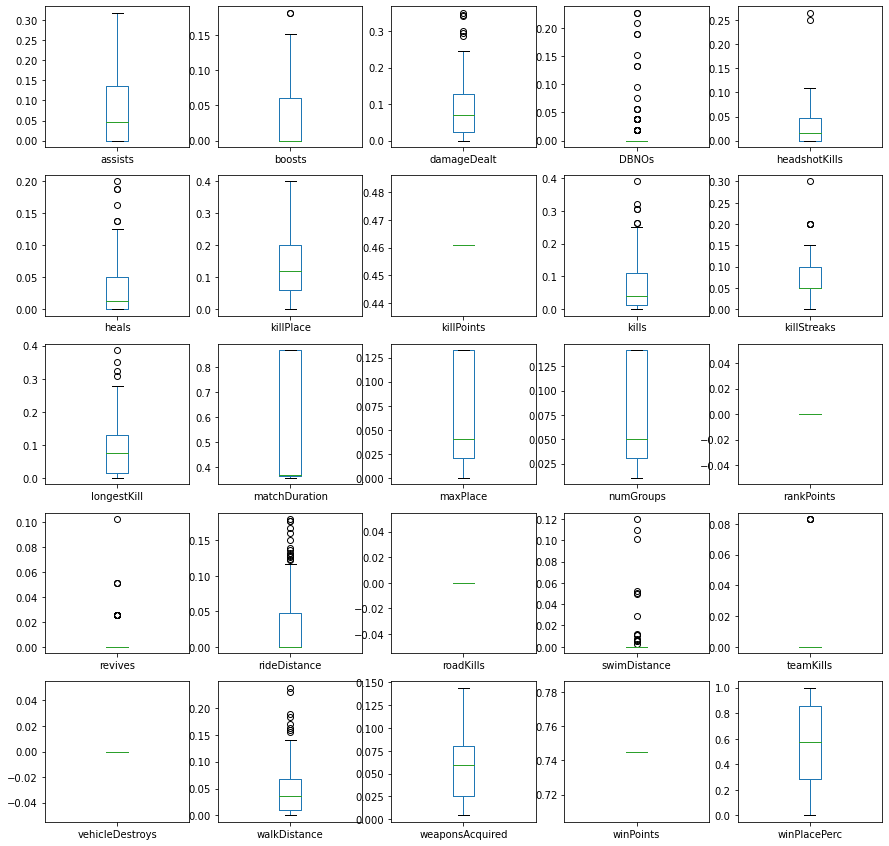

normal_squad_fpp:
Cluster 1, average wpp = 0.5039730987055017


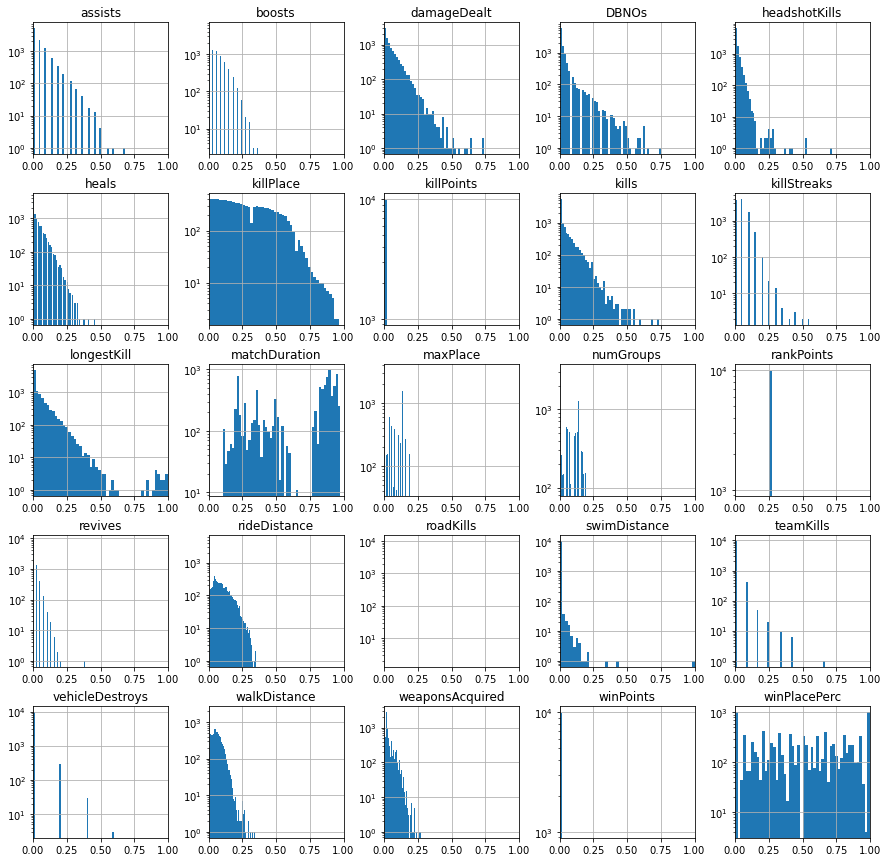

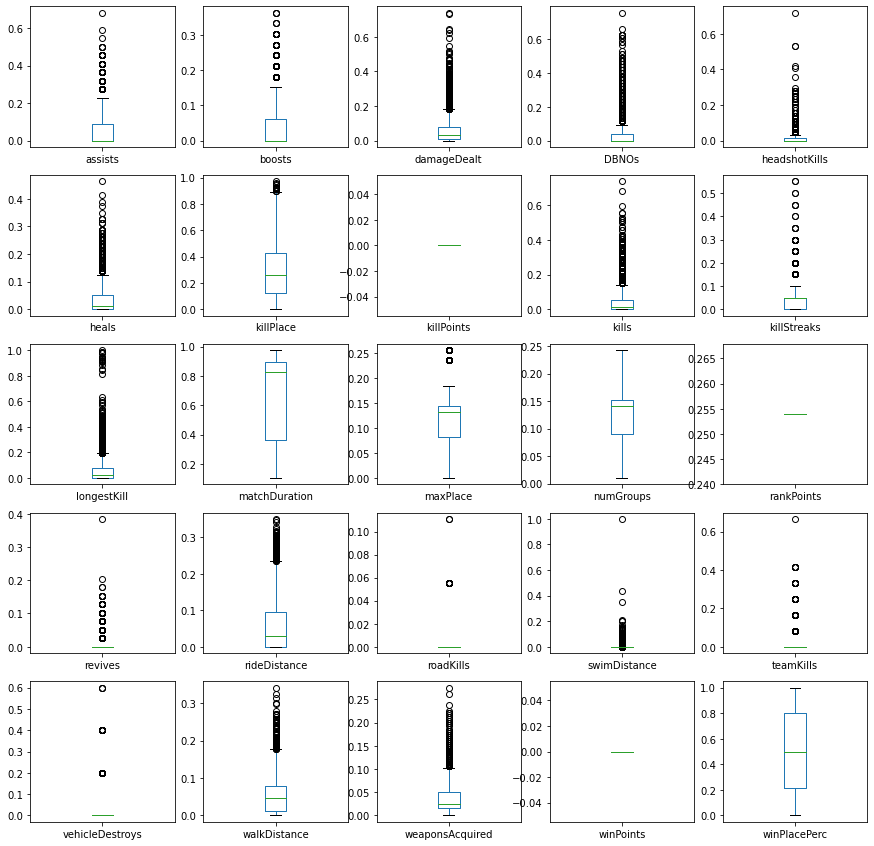

Cluster 2, average wpp = 0.5002899807850673


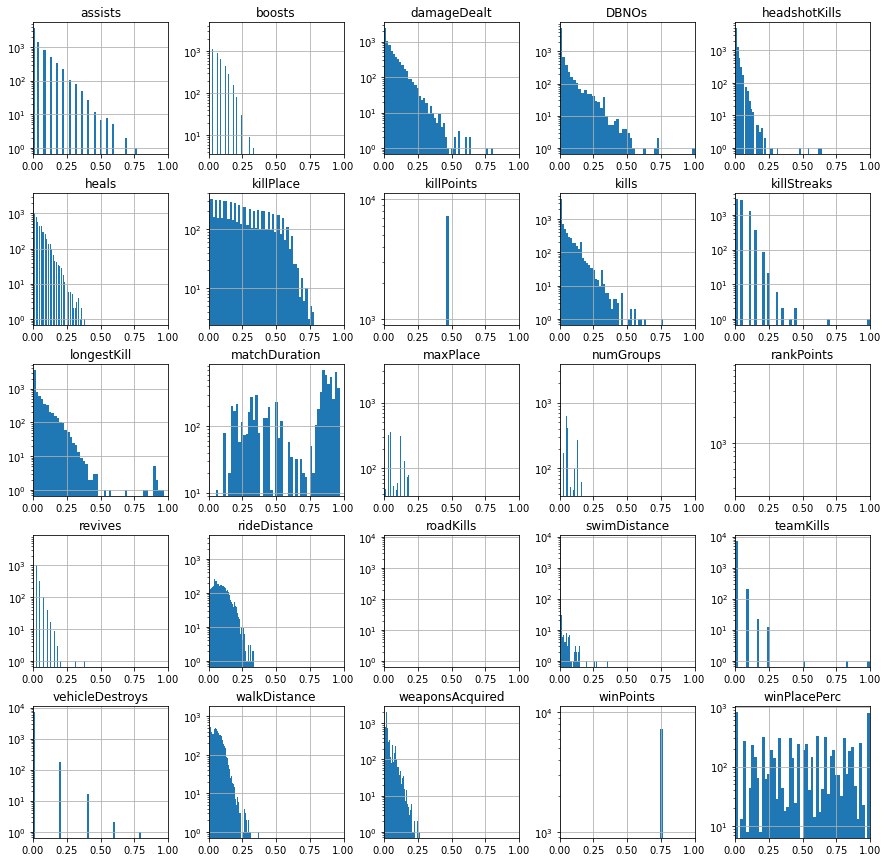

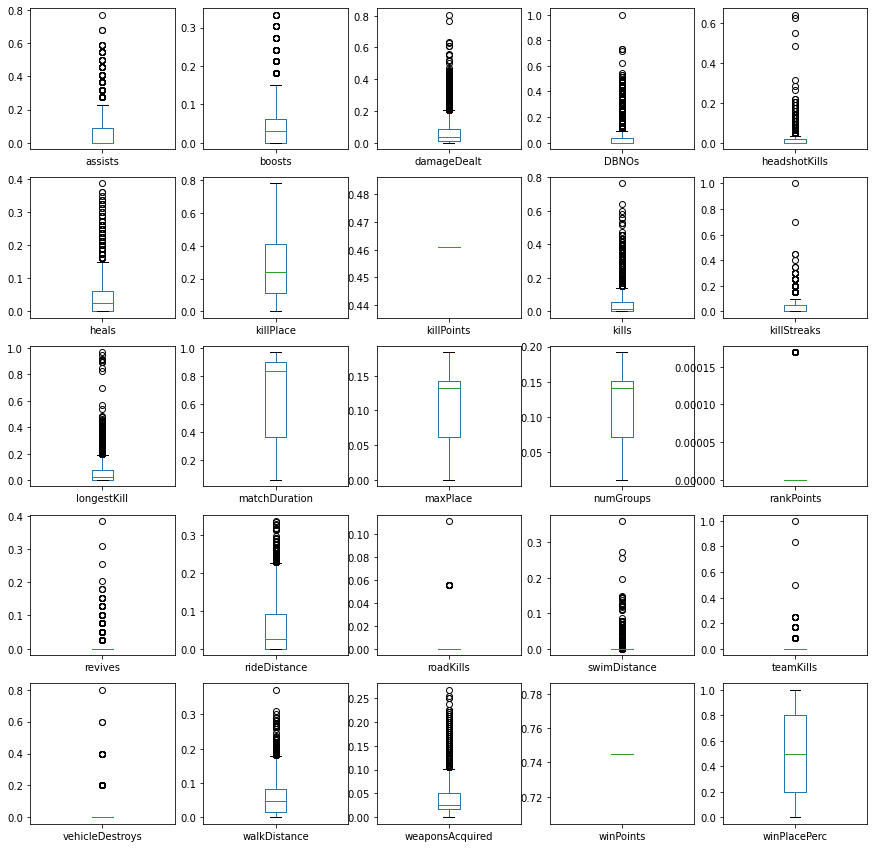

solo:
Cluster 1, average wpp = 0.3026864785781374


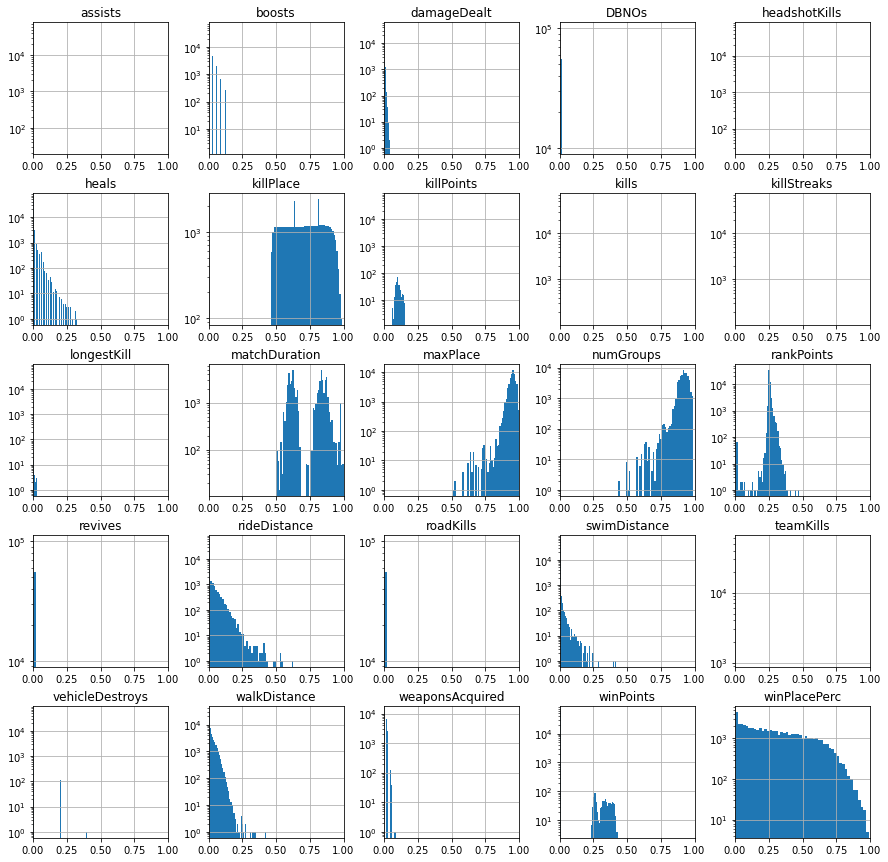

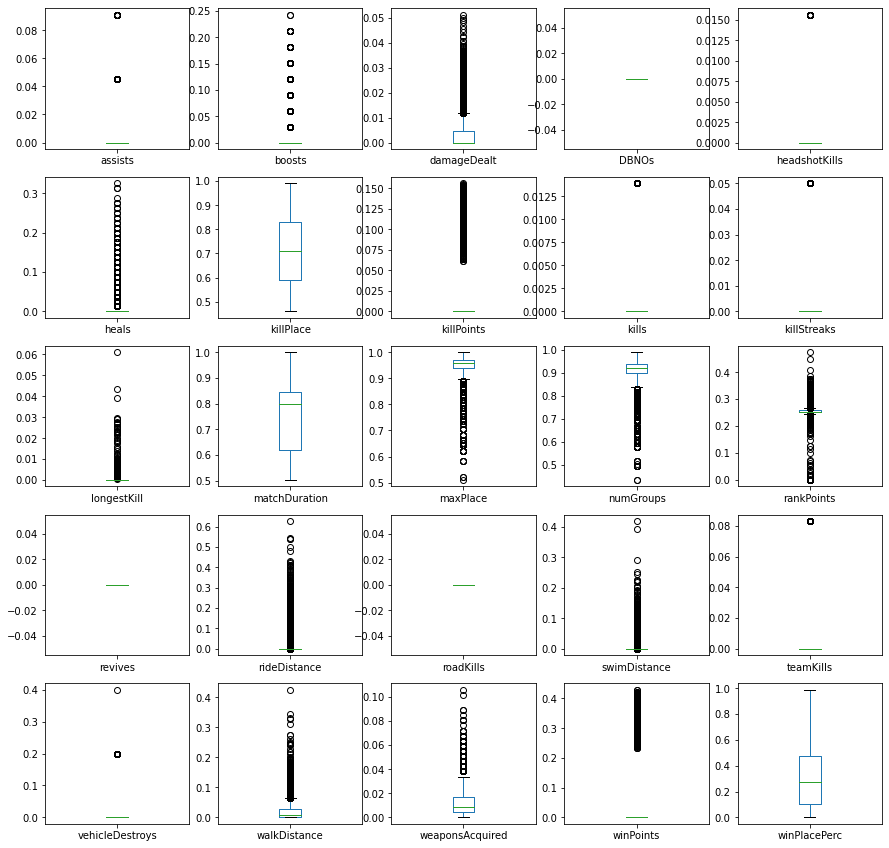

Cluster 2, average wpp = 0.30919632783563894


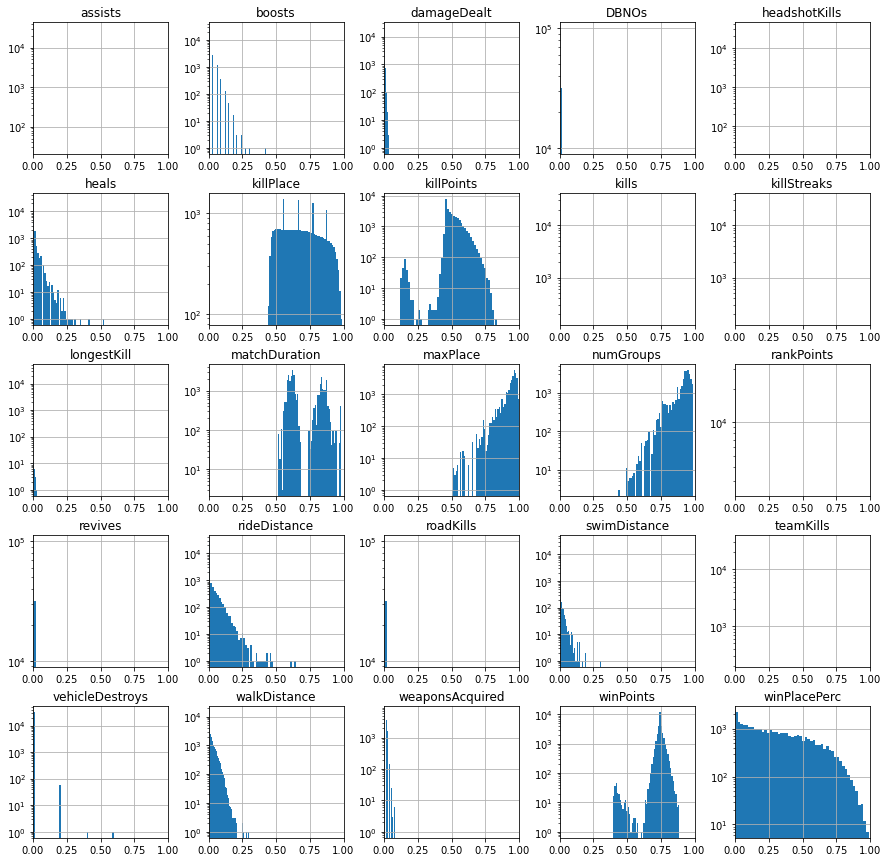

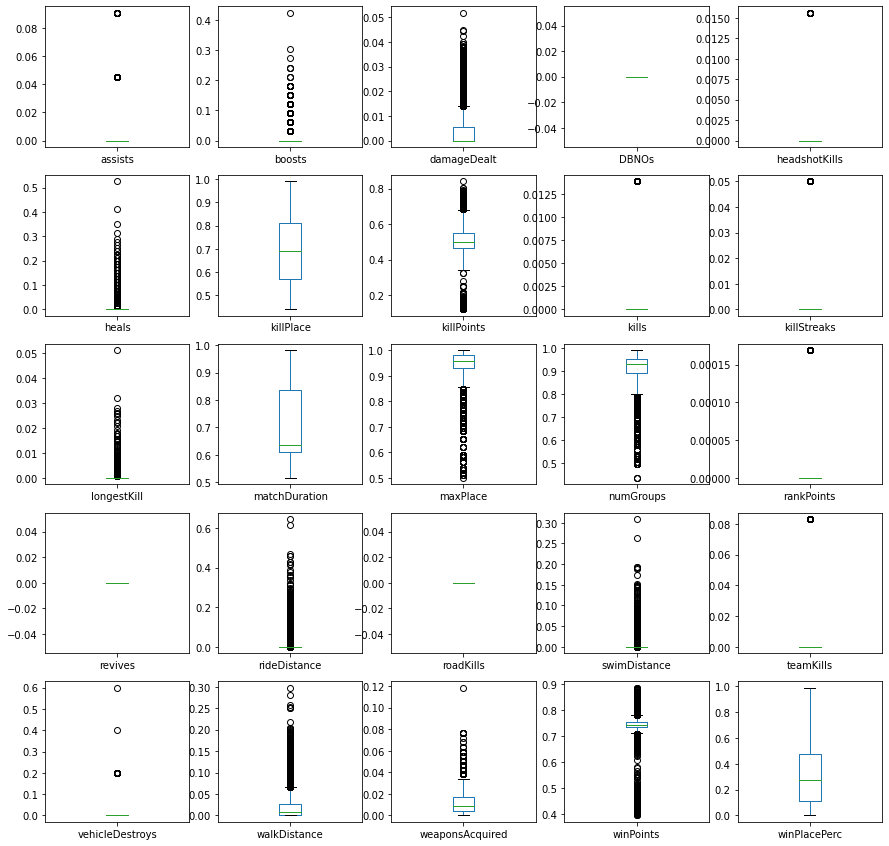

Cluster 3, average wpp = 0.6731285735218696


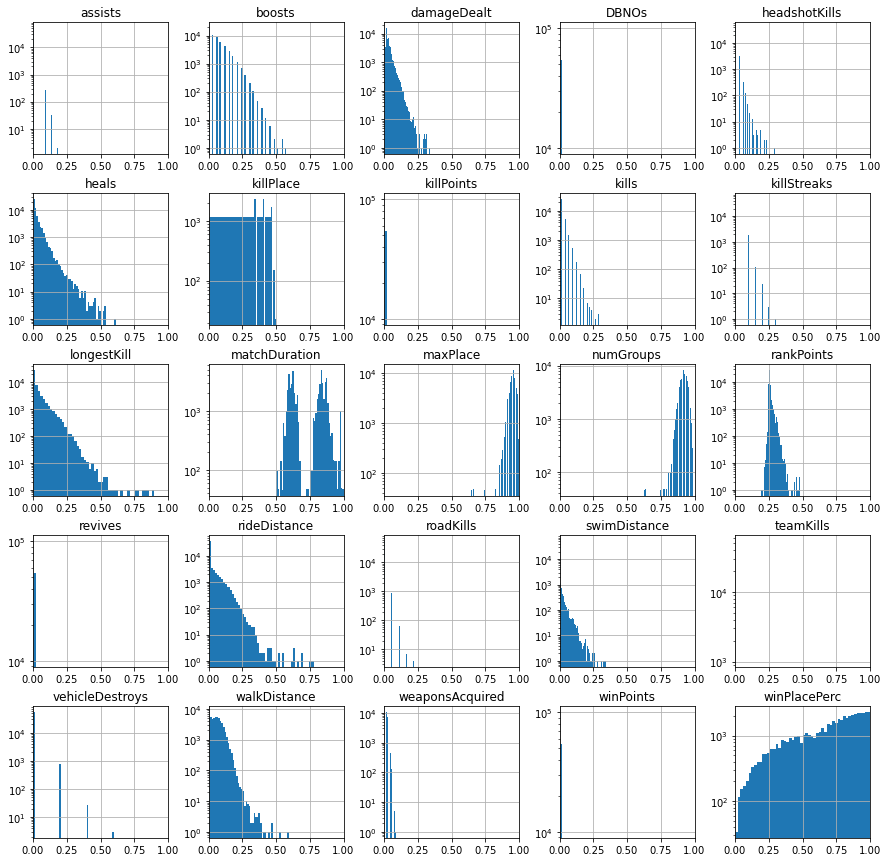

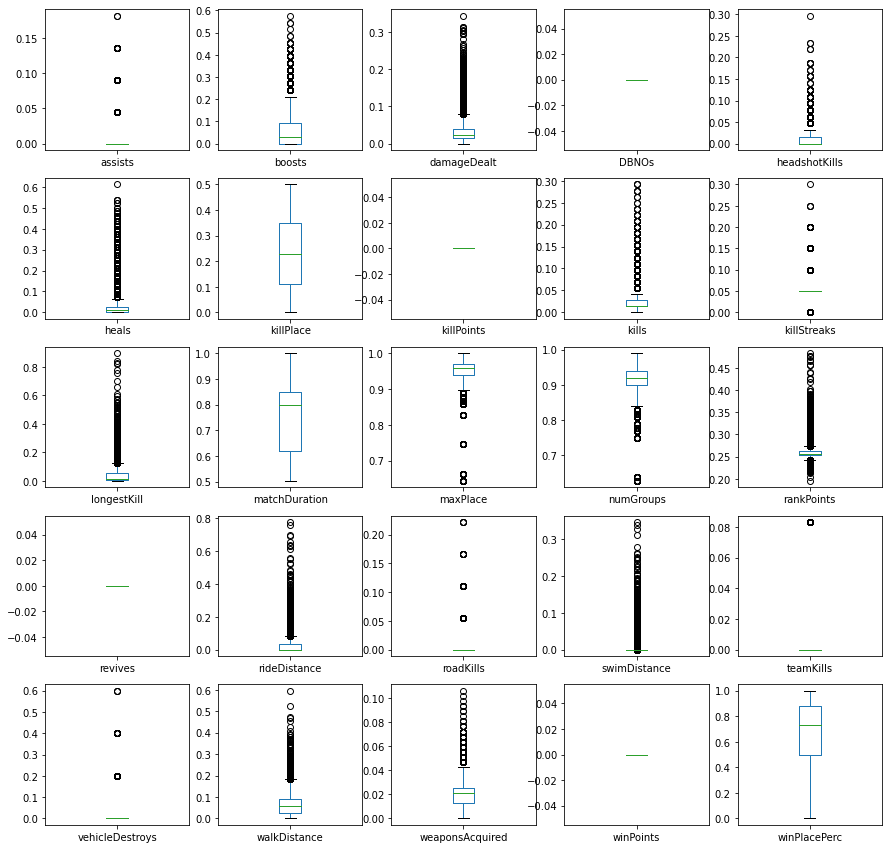

Cluster 4, average wpp = 0.13073680355741565


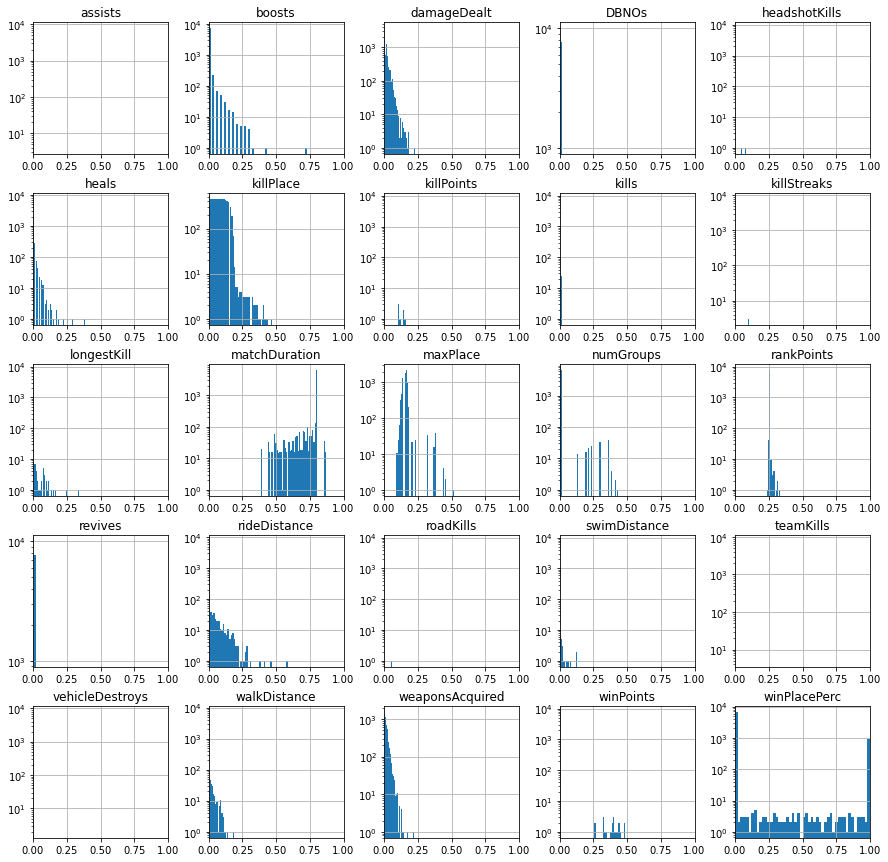

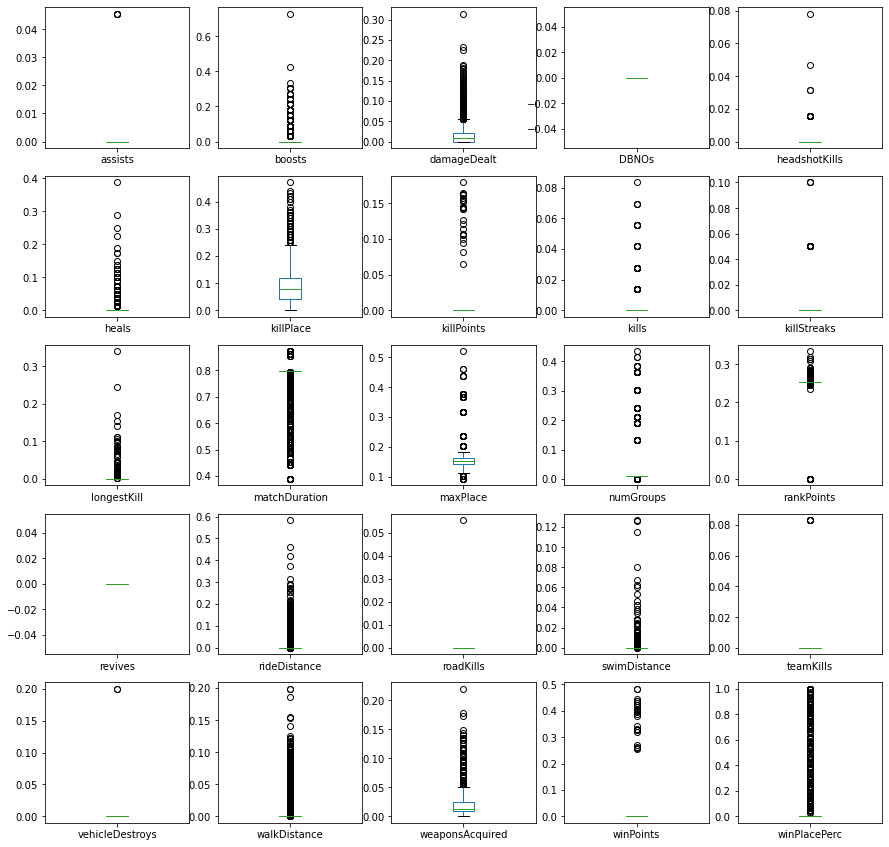

Cluster 5, average wpp = 0.6697295590570418


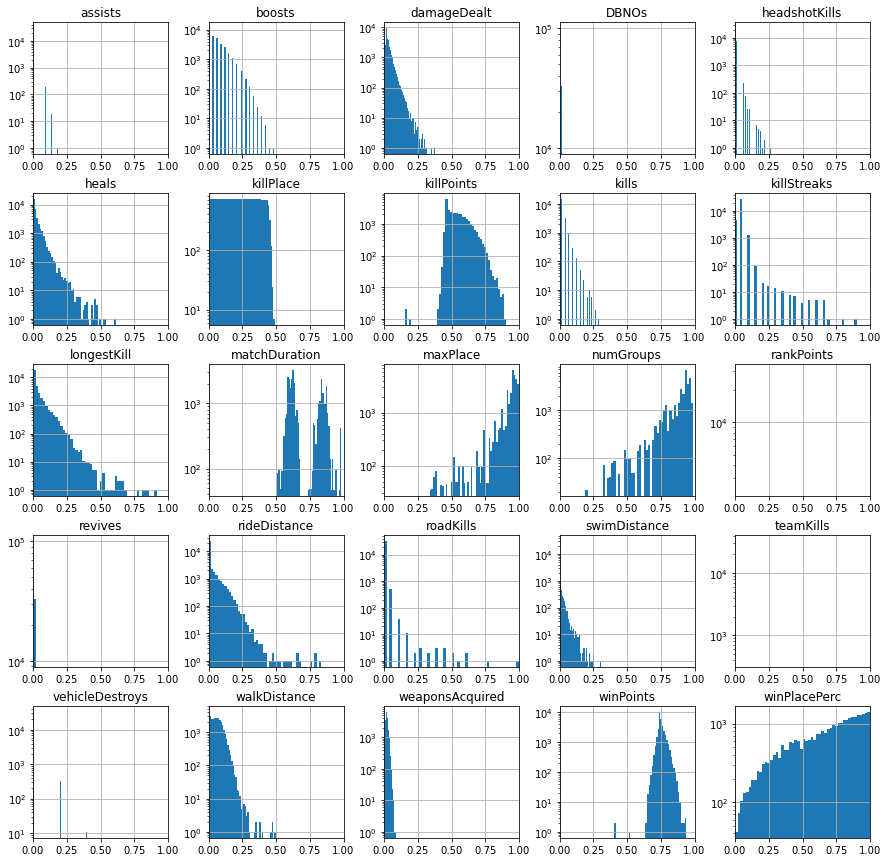

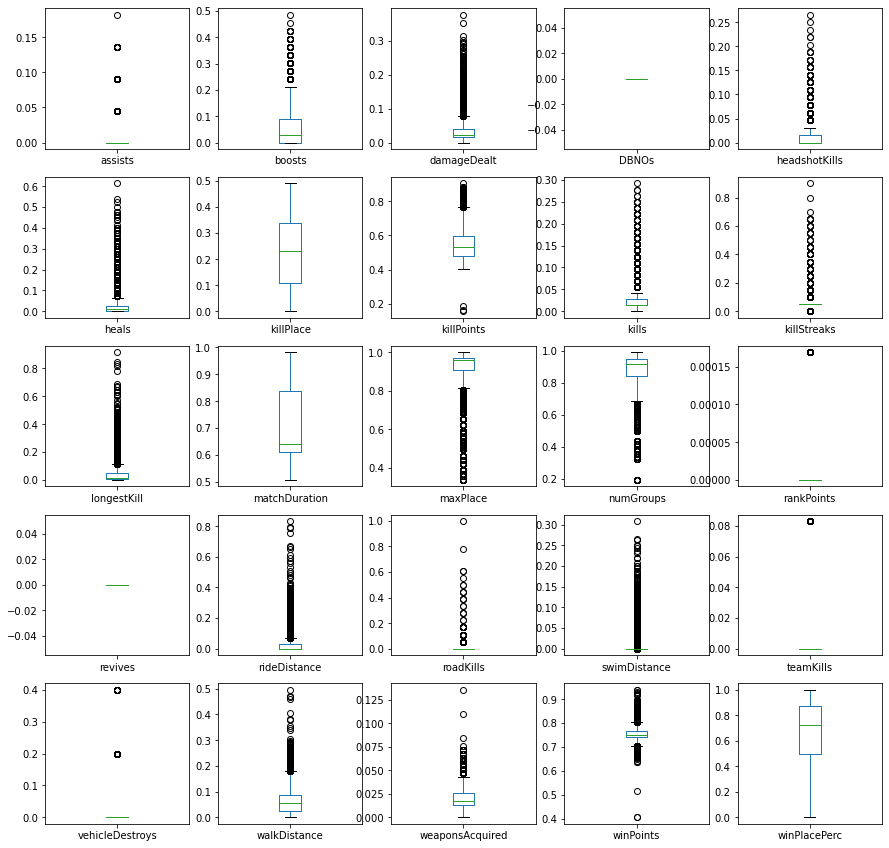

solo_fpp:
Cluster 1, average wpp = 0.49211723771620086


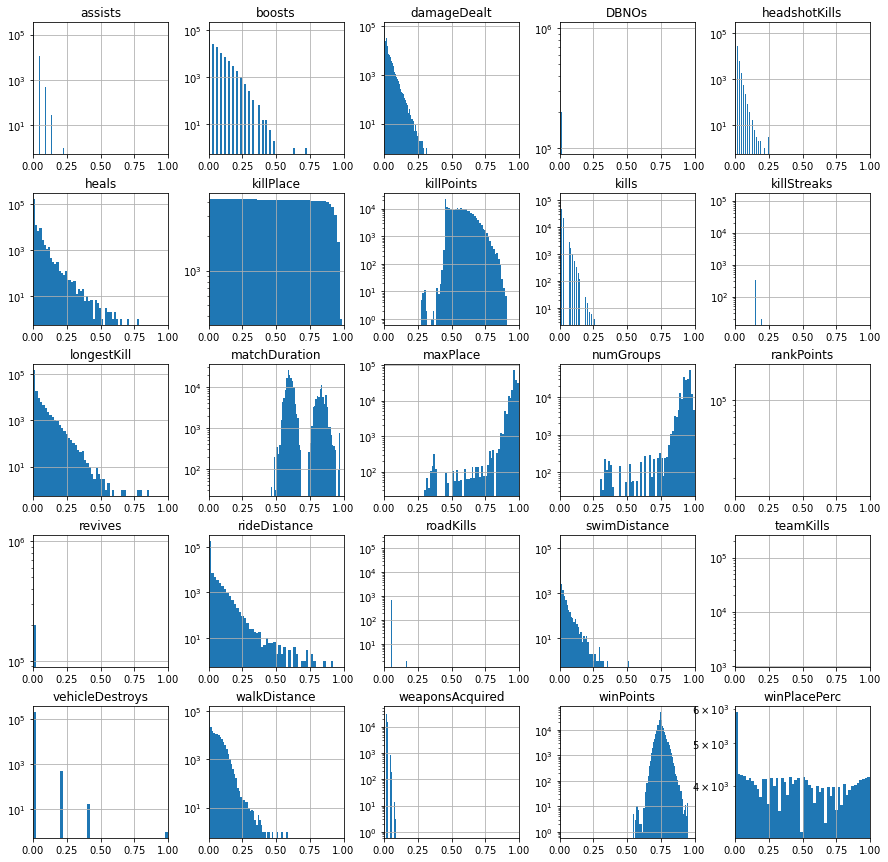

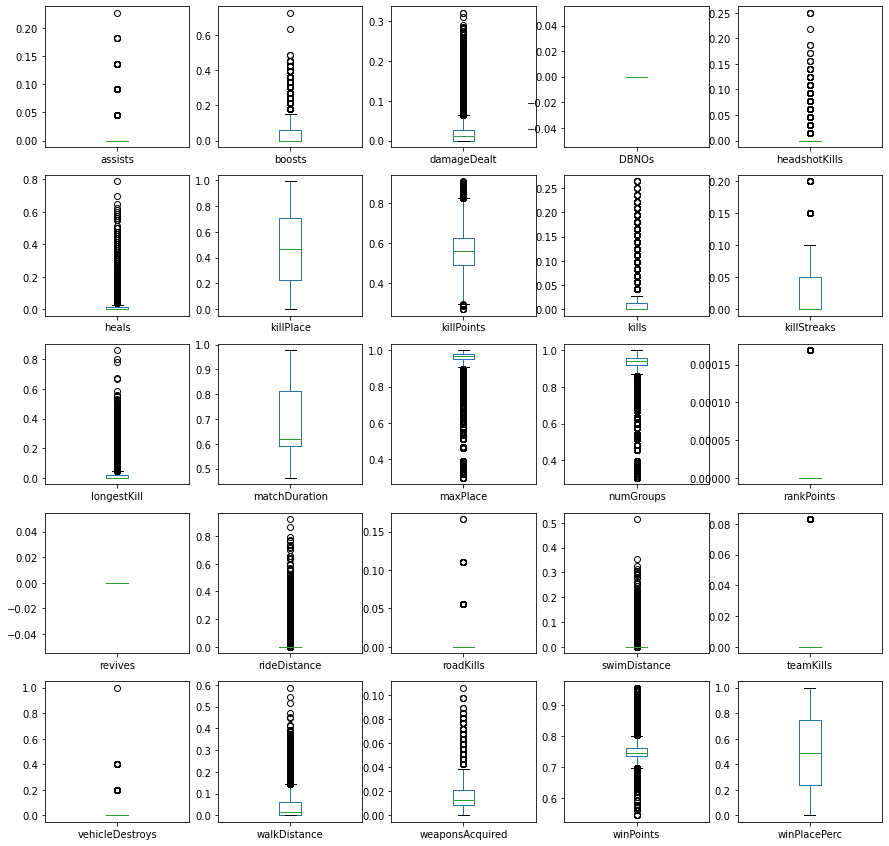

Cluster 2, average wpp = 0.4916672862398253


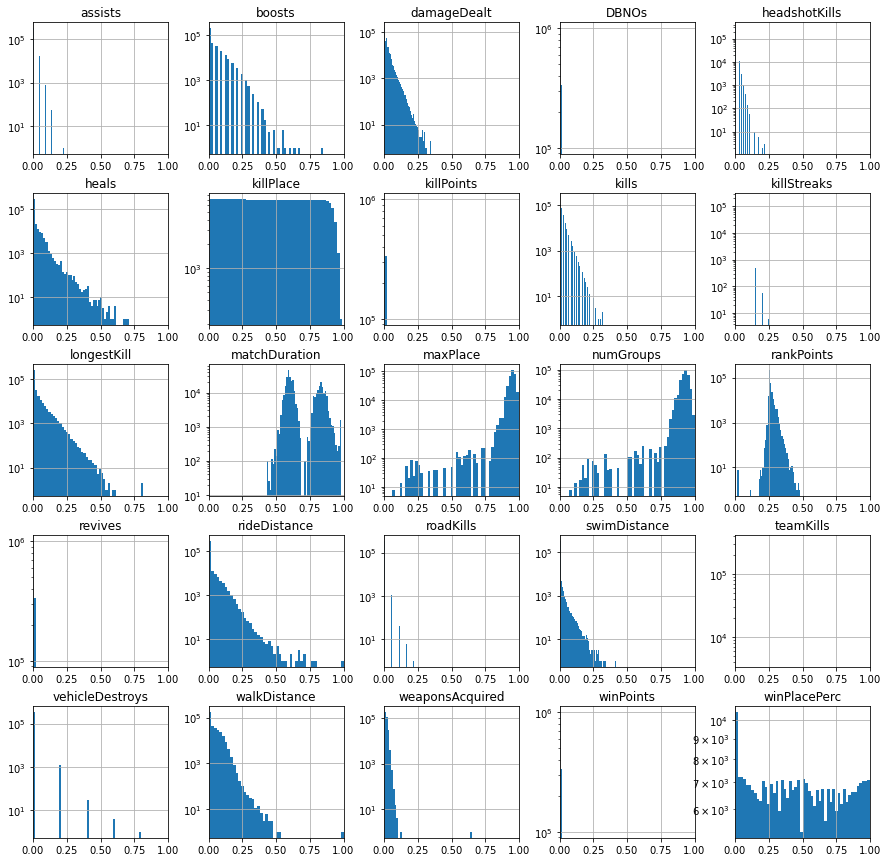

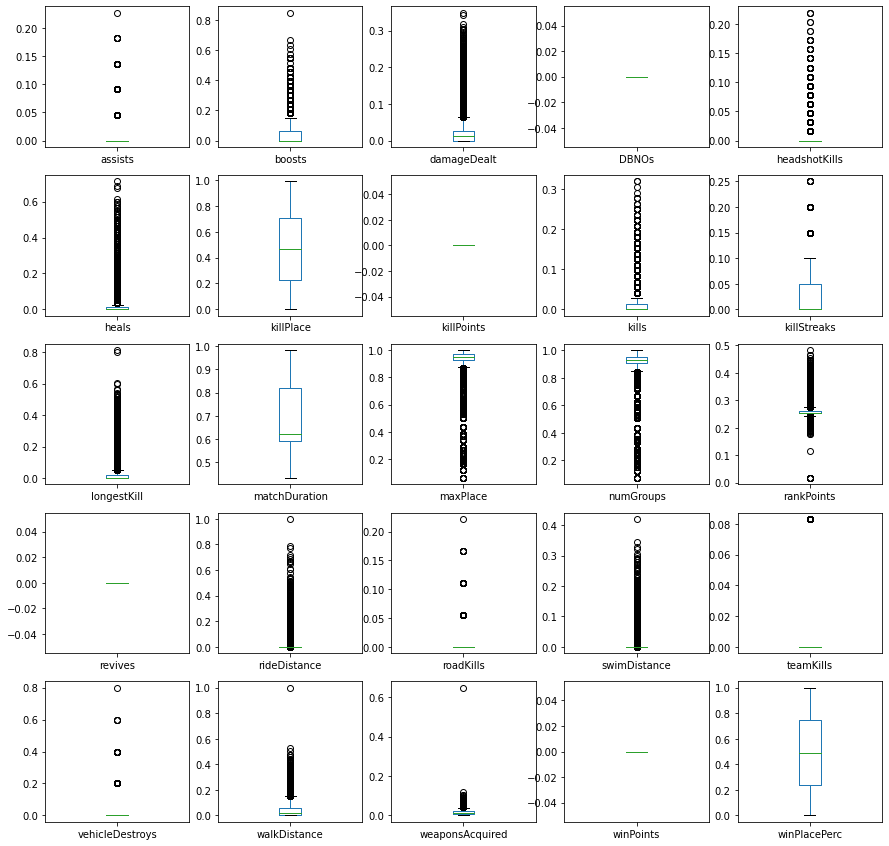

squad:
Cluster 1, average wpp = 0.4529095417843363


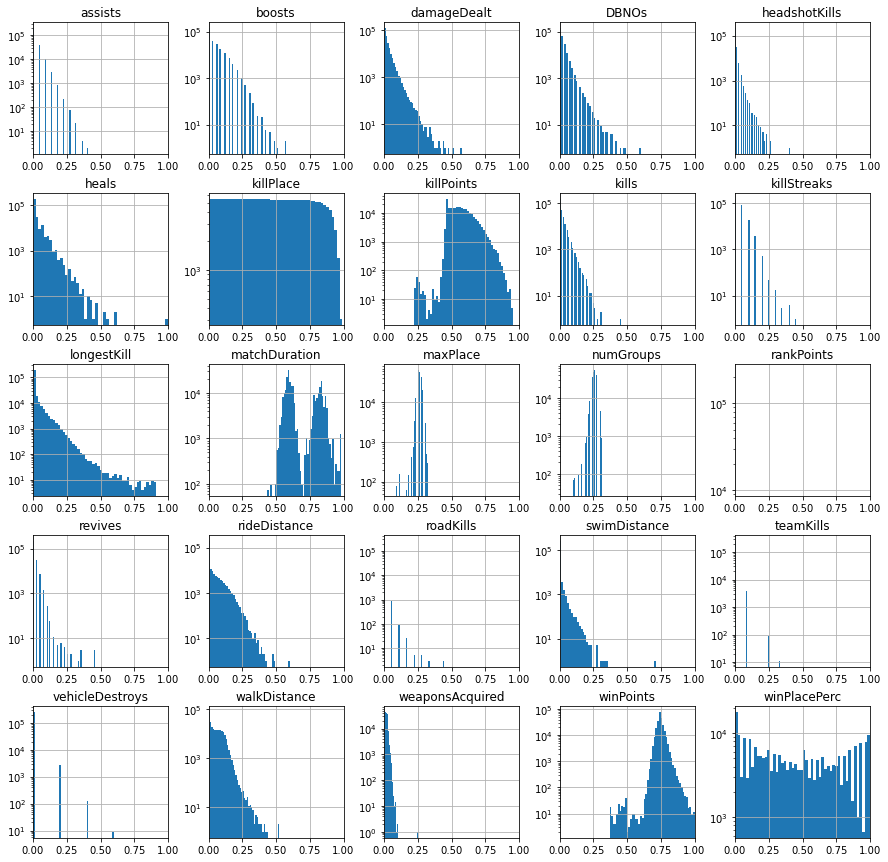

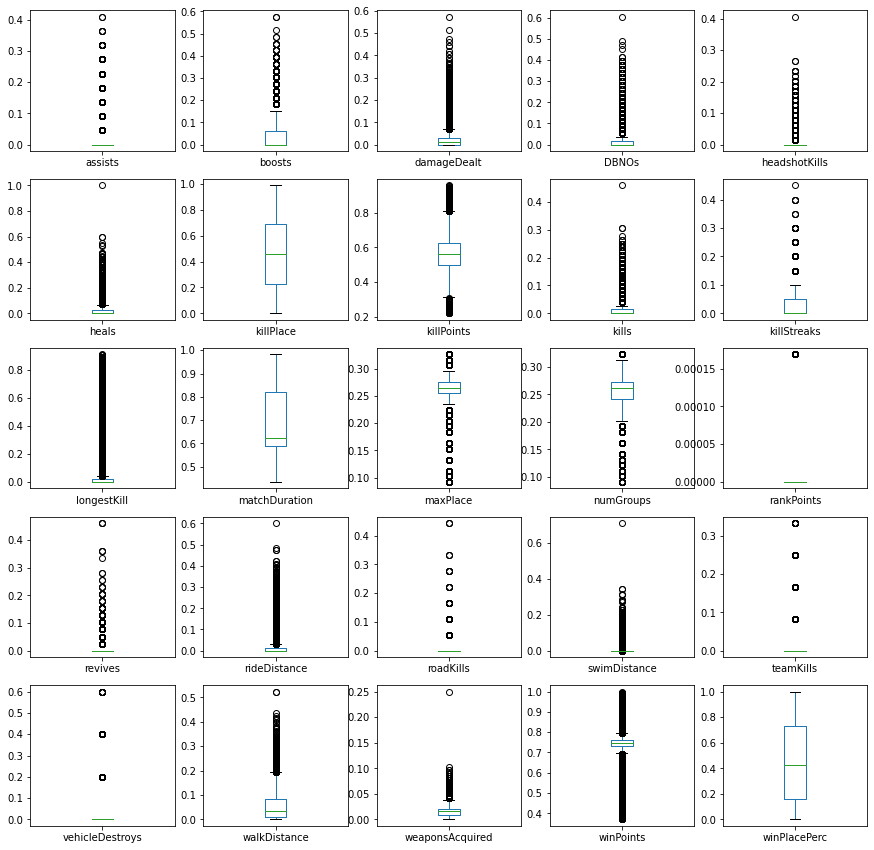

Cluster 2, average wpp = 0.45123709279262936


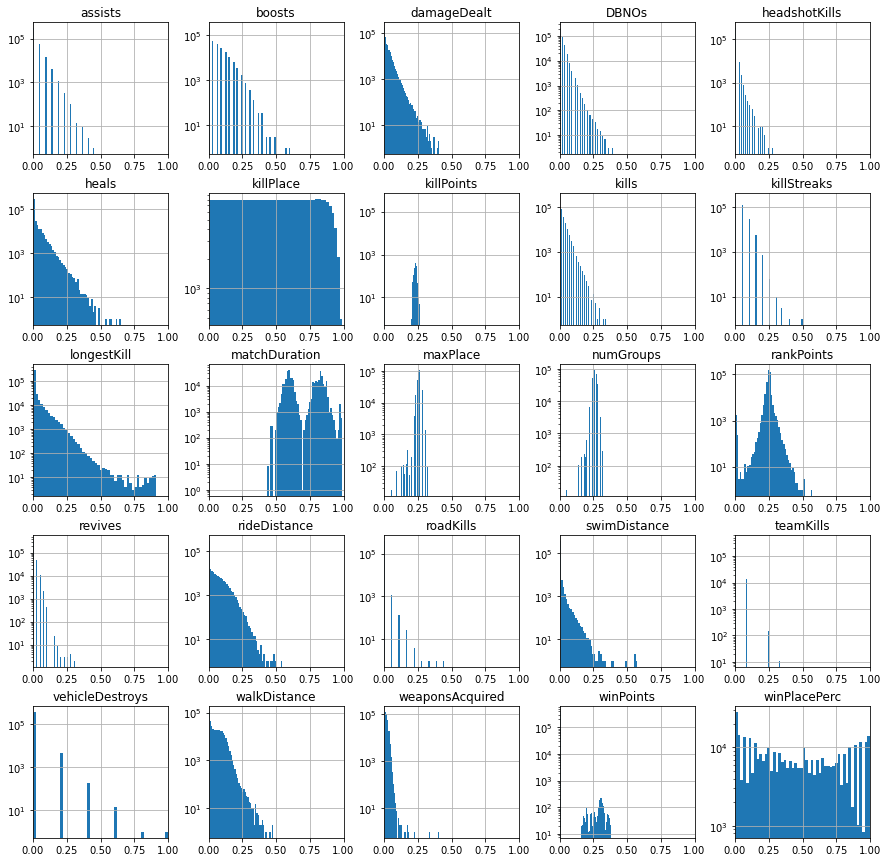

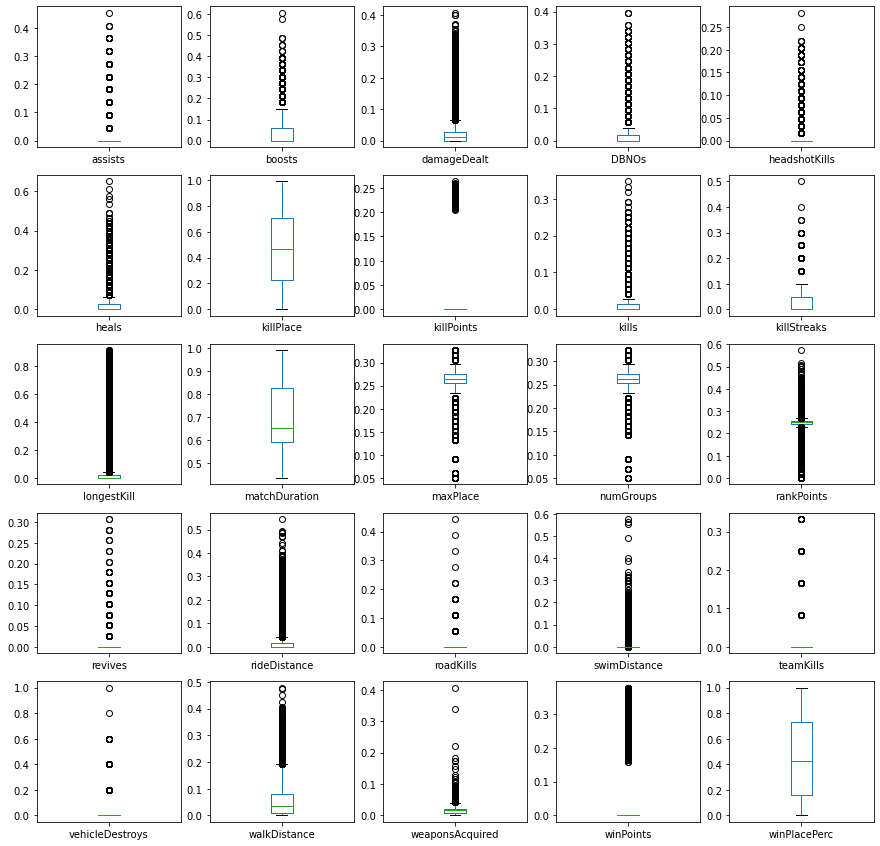

squad_fpp:
Cluster 1, average wpp = 0.4654673331482458


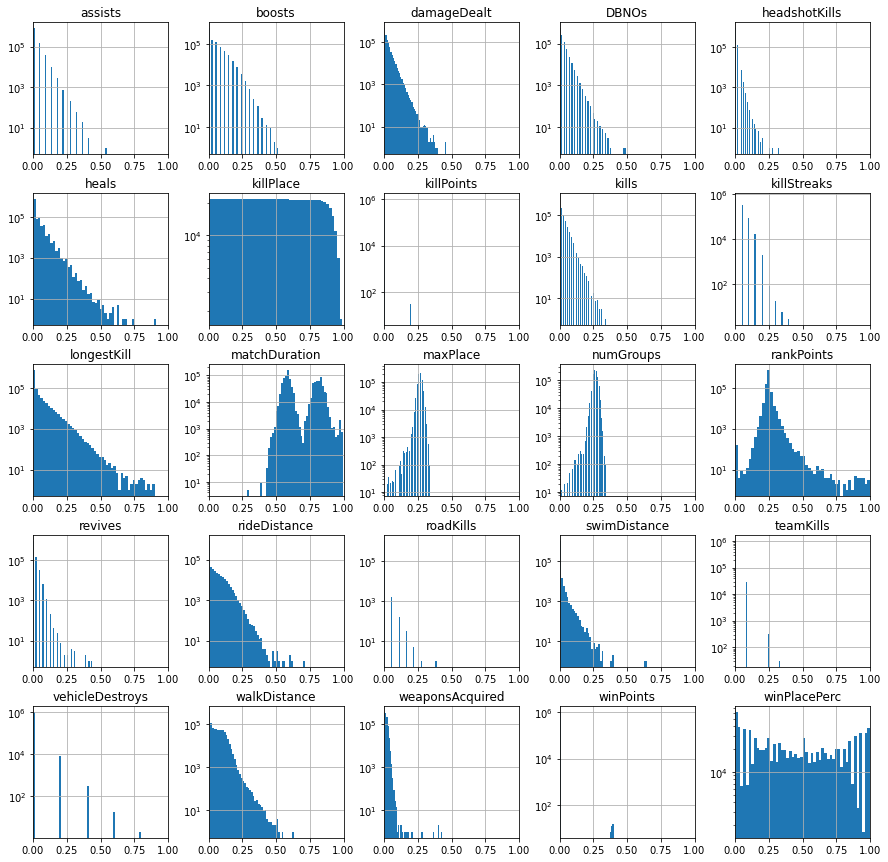

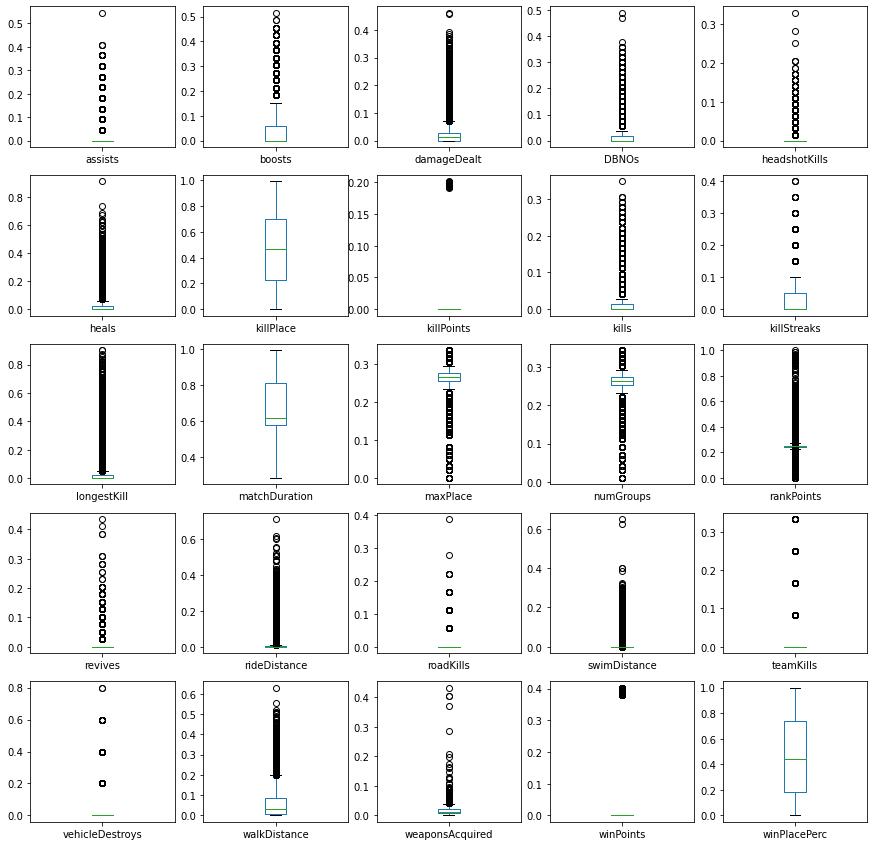

Cluster 2, average wpp = 0.46381464269664135


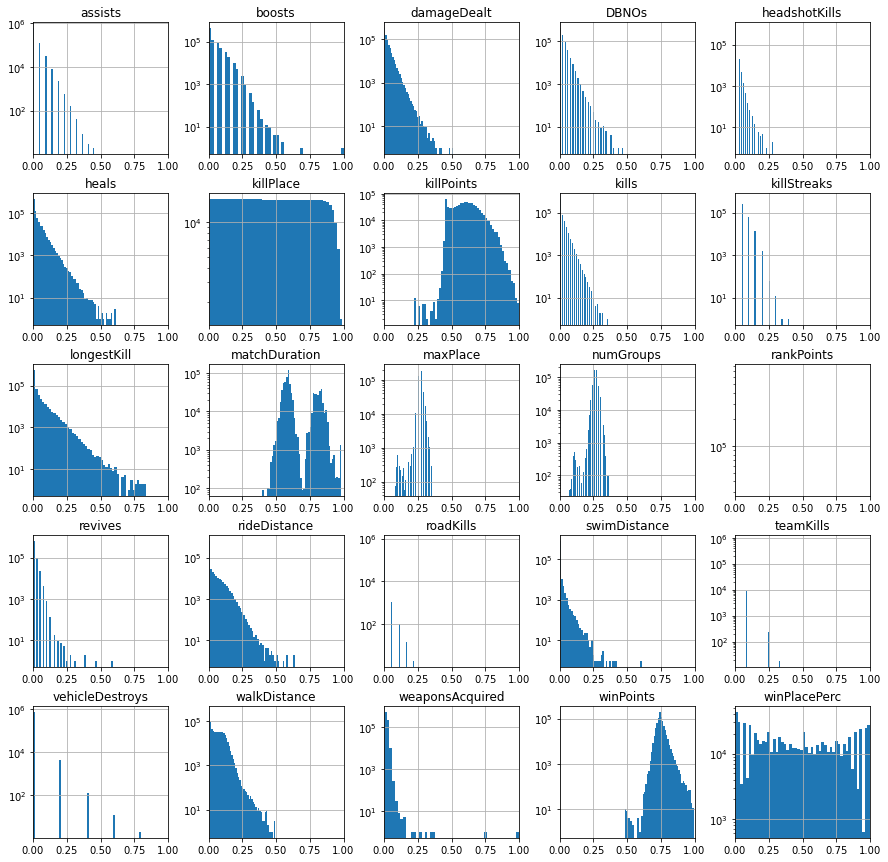

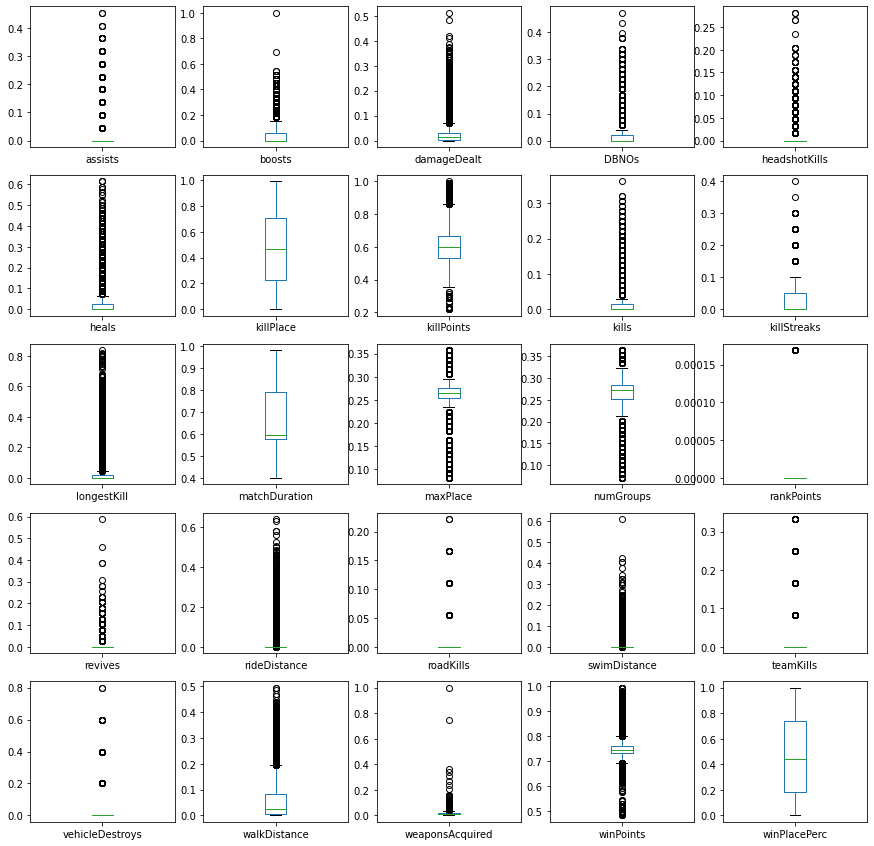

In [29]:
for index in range(len(allTypes)):
    
    #Get the name
    name = names[index]
    
    #Get the best number of clusters of the current match type
    n_clusters = n_clusters_collection[index]
    
    #Get the dataframe of the current match type
    single_type = allTypes[index].copy()
    
    #Extract y and X
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    
    #Delete matchType
    single_X_temp = single_X.drop(["matchType"],axis=1)
    
    #Convert numpy array into pandas dataframe
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y}) 
    
    #Train kmeans with according n_clusters
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    
    print(name+":")
    plot_distributions(single_X_temp,single_y_temp,kmeans,n_clusters)

#### View the nearest points

In [31]:
for index in range(len(allTypes)):
    
    name = names[index]
    n_clusters = n_clusters_collection[index]
    single_type = allTypes[index].copy()

    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y}) 
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    print(name)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        display(get_closest(single_X_temp,kmeans,single_y_temp,n_clusters))

crashfpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  killPlace  \
3136      0.0  0.060606     0.000672    0.0            0.0  0.0125       0.22   
1656      0.0  0.000000     0.009027    0.0            0.0  0.0000       0.69   

      killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
3136         0.0  0.013889         0.05      0.00343       0.360741  0.459184   
1656         0.0  0.000000         0.00      0.00000       0.363118  0.469388   

      numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
3136   0.444444    0.253933      0.0      0.061803   0.055556           0.0   
1656   0.454545    0.253933      0.0      0.008020   0.000000           0.0   

      teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
3136        0.0              0.0      0.038262         0.008475        0.0   
1656        0.0              0.0      0.024042         0.004237        0.0   

      winPlacePerc  averageWpp  
3136        0.8478    0.650907  
1656        0.2340    0.281412

crashtpp


assists    boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
241      0.0  0.000000     0.000000    0.0            0.0  0.000       0.56   
268      0.0  0.060606     0.015115    0.0            0.0  0.025       0.20   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
241         0.0  0.000000         0.00     0.000000       0.375951  0.357143   
268         0.0  0.013889         0.05     0.003988       0.375951  0.357143   

     numGroups  rankPoints   revives  rideDistance  roadKills  swimDistance  \
241   0.323232    0.253933  0.000000      0.009349   0.000000           0.0   
268   0.323232    0.253933  0.025641      0.045247   0.055556           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
241        0.0              0.0      0.020244         0.004237        0.0   
268        0.0              0.0      0.074709         0.016949        0.0   

     winPlacePerc  averageWpp  
241        0.3056    0.317374  
268        0.8611    0.642030

duo


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
41152       0.0  0.030303     0.002786    0.0            0.0  0.0125   
269351      0.0  0.060606     0.005387    0.0            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
41152        0.46     0.00000    0.0          0.0          0.0       0.761882   
269351       0.47     0.53871    0.0          0.0          0.0       0.667300   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
41152   0.459184   0.434343    0.252918      0.0      0.000000        0.0   
269351  0.469388   0.444444    0.000000      0.0      0.014606        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
41152            0.0        0.0              0.0      0.043134   
269351           0.0        0.0              0.0      0.050543   

        weaponsAcquired  winPoints  winPlacePerc  averageWpp  
41152          0.016949   0.000000        0.6304    0.479922  
269351         0.029661   0.725286        0.5957    0.487404

duo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
975228      0.0  0.030303     0.003073    0.0            0.0  0.0125   
935115      0.0  0.030303     0.002096    0.0            0.0  0.0375   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
975228       0.47    0.000000    0.0          0.0          0.0       0.664924   
935115       0.45    0.560369    0.0          0.0          0.0       0.673479   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
975228  0.469388   0.454545    0.255625      0.0      0.000000        0.0   
935115  0.459184   0.454545    0.000000      0.0      0.028617        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
975228      0.000000        0.0              0.0      0.059697   
935115      0.013455        0.0              0.0      0.045345   

        weaponsAcquired  winPoints  winPlacePerc  averageWpp  
975228         0.021186   0.000000        0.6809    0.485393  
935115         0.012712   0.743666        0.6522    0.486434

flarefpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
652      0.0  0.000000     0.002541  0.000000            0.0  0.0000   
99       0.0  0.030303     0.008789  0.018868            0.0  0.0375   

     killPlace  killPoints     kills  killStreaks  longestKill  matchDuration  \
652       0.65         0.0  0.000000         0.00     0.000000       0.824144   
99        0.23         0.0  0.013889         0.05     0.024269       0.824144   

     maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
652   0.22449   0.222222    0.253933      0.0      0.000000        0.0   
99    0.22449   0.222222    0.253933      0.0      0.032277        0.0   

     swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
652           0.0        0.0              0.0      0.046315         0.012712   
99            0.0        0.0              0.0      0.091815         0.012712   

     winPoints  winPlacePerc  averageWpp  
652        0.0        0.3043    0.258539  
99         0.0        0.8696    0.616455

flaretpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
205   0.000000  0.000000     0.000000  0.000000            0.0  0.0125   
2018  0.000000  0.060606     0.015115  0.018868            0.0  0.0625   
339   0.045455  0.060606     0.015810  0.000000            0.0  0.0375   

      killPlace  killPoints     kills  killStreaks  longestKill  \
205        0.68    0.000000  0.000000         0.00     0.000000   
2018       0.23    0.000000  0.013889         0.05     0.042998   
339        0.37    0.460829  0.000000         0.00     0.000000   

      matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
205        0.829373  0.234694   0.242424    0.253933  0.000000      0.017777   
2018       0.834601  0.224490   0.222222    0.253933  0.025641      0.035544   
339        0.792776  0.234694   0.232323    0.000000  0.000000      0.049226   

      roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
205         0.0      0.000000        0.0              0.0      0.036932   
2018        0.0      0.000000        0.0              0.0      0.076649   
339         0.0      0.004306        0.0              0.0      0.108262   

      weaponsAcquired  winPoints  winPlacePerc  averageWpp  
205          0.004237   0.000000        0.2083    0.240825  
2018         0.025424   0.000000        0.4348    0.625316  
339          0.042373   0.745156        1.0000    0.434976

normal_duo


assists    boosts  damageDealt     DBNOs  headshotKills  heals  \
31   0.045455  0.030303     0.022294  0.000000        0.00000    0.0   
172  0.045455  0.000000     0.075771  0.056604        0.03125    0.0   

     killPlace  killPoints     kills  killStreaks  longestKill  matchDuration  \
31        0.15    0.000000  0.013889         0.05     0.004806       0.462452   
172       0.09    0.460829  0.055556         0.10     0.015174       0.537072   

     maxPlace  numGroups  rankPoints   revives  rideDistance  roadKills  \
31   0.183673   0.191919    0.253933  0.025641      0.033235        0.0   
172  0.051020   0.060606    0.000000  0.000000      0.000000        0.0   

     swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
31            0.0        0.0              0.0      0.036241         0.004237   
172           0.0        0.0              0.0      0.057137         0.097458   

     winPoints  winPlacePerc  averageWpp  
31    0.000000        0.3684    0.512373  
172   0.745156        0.0000    0.515814

normal_duo_fpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
3583      0.0  0.060606     0.018606  0.000000            0.0  0.0125   
4098      0.0  0.090909     0.015068  0.018868            0.0  0.0250   

      killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
3583       0.26    0.460829    0.0          0.0          0.0       0.825570   
4098       0.20    0.000000    0.0          0.0          0.0       0.710076   

      maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
3583  0.265306   0.272727    0.000000      0.0      0.016979        0.0   
4098  0.163265   0.171717    0.253933      0.0      0.028519        0.0   

      swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
3583      0.007073        0.0              0.0      0.086230         0.016949   
4098      0.000000        0.0              0.0      0.081808         0.021186   

      winPoints  winPlacePerc  averageWpp  
3583   0.745156        0.5185    0.504378  
4098   0.000000        0.4706    0.516002

normal_solo


assists    boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
321  0.136364  0.000000     0.109175    0.0       0.000000    0.0       0.11   
150  0.000000  0.060606     0.014403    0.0       0.015625    0.0       0.06   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
321    0.460829  0.125000         0.10     0.031261       0.425380  0.112245   
150    0.000000  0.013889         0.05     0.062230       0.691065  0.214286   

     numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
321   0.101010    0.000000      0.0           0.0        0.0           0.0   
150   0.222222    0.253933      0.0           0.0        0.0           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
321        0.0              0.0      0.000000         0.084746   0.745156   
150        0.0              0.0      0.085493         0.025424   0.000000   

     winPlacePerc  averageWpp  
321        0.0833    0.584239  
150        0.6364    0.514918

normal_solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  killPlace  \
162  0.090909  0.000000     0.120919    0.0       0.015625  0.0000       0.17   
889  0.136364  0.030303     0.134114    0.0       0.015625  0.0375       0.12   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
162    0.460829  0.069444         0.05     0.052815       0.363593  0.183673   
889    0.000000  0.111111         0.05     0.099177       0.363593  0.183673   

     numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
162   0.141414    0.000000      0.0           0.0        0.0           0.0   
889   0.141414    0.253933      0.0           0.0        0.0           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
162        0.0              0.0      0.012808         0.118644   0.745156   
889        0.0              0.0      0.008417         0.080508   0.000000   

     winPlacePerc  averageWpp  
162        0.1579    0.550139  
889        0.3684    0.557958

normal_squad


assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
455  0.045455     0.0     0.047672    0.0       0.015625    0.0       0.24   
435  0.090909     0.0     0.119377    0.0       0.015625    0.0       0.13   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
455    0.000000  0.041667         0.05     0.066645       0.609316  0.061224   
435    0.460829  0.125000         0.10     0.086581       0.410171  0.040816   

     numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
455   0.070707    0.253933      0.0           0.0        0.0           0.0   
435   0.050505    0.000000      0.0           0.0        0.0           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
455        0.0              0.0      0.051241         0.055085   0.000000   
435        0.0              0.0      0.032331         0.131356   0.745156   

     winPlacePerc  averageWpp  
455        0.2857    0.519323  
435        0.8000    0.537962

normal_squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
16113      0.0  0.060606     0.023821  0.018868            0.0  0.0375   
2942       0.0  0.030303     0.015342  0.018868            0.0  0.0250   

       killPlace  killPoints     kills  killStreaks  longestKill  \
16113       0.30    0.000000  0.000000         0.00      0.00000   
2942        0.25    0.460829  0.013889         0.05      0.05298   

       matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
16113       0.608840  0.112245   0.121212    0.253933      0.0      0.000000   
2942        0.768536  0.112245   0.121212    0.000000      0.0      0.057332   

       roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
16113        0.0           0.0        0.0              0.0      0.039527   
2942         0.0           0.0        0.0              0.0      0.021536   

       weaponsAcquired  winPoints  winPlacePerc  averageWpp  
16113         0.016949   0.000000        0.3333    0.503973  
2942          0.016949   0.745156        0.0000    0.500290

solo


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
143723      0.0  0.000000     0.000000    0.0            0.0  0.0000   
110633      0.0  0.000000     0.000000    0.0            0.0  0.0000   
151838      0.0  0.060606     0.015115    0.0            0.0  0.0375   
171289      0.0  0.000000     0.013452    0.0            0.0  0.0000   
146098      0.0  0.060606     0.025030    0.0            0.0  0.0125   

        killPlace  killPoints     kills  killStreaks  longestKill  \
143723       0.73    0.000000  0.000000         0.00     0.000000   
110633       0.71    0.495853  0.000000         0.00     0.000000   
151838       0.24    0.000000  0.013889         0.05     0.014488   
171289       0.08    0.000000  0.000000         0.00     0.000000   
146098       0.22    0.558986  0.013889         0.05     0.003742   

        matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
143723       0.734316  0.959184   0.919192    0.252918      0.0           0.0   
110633       0.748099  0.959184   0.888889    0.000000      0.0           0.0   
151838       0.734316  0.959184   0.919192    0.252918      0.0           0.0   
171289       0.765209  0.163265   0.000000    0.253933      0.0           0.0   
146098       0.660171  0.928571   0.919192    0.000000      0.0           0.0   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
143723        0.0           0.0        0.0              0.0      0.010093   
110633        0.0           0.0        0.0              0.0      0.021521   
151838        0.0           0.0        0.0              0.0      0.060861   
171289        0.0           0.0        0.0              0.0      0.000000   
146098        0.0           0.0        0.0              0.0      0.076610   

        weaponsAcquired  winPoints  winPlacePerc  averageWpp  
143723         0.016949   0.000000        0.2526    0.302686  
110633         0.016949   0.757576        0.3684    0.309196  
151838         0.012712   0.000000        0.7579    0.673129  
171289         0.012712   0.000000        0.0000    0.130737  
146098         0.021186   0.771485        0.7826    0.669730

solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
487424      0.0  0.030303     0.000000    0.0            0.0  0.0000   
526290      0.0  0.030303     0.014034    0.0            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
487424       0.47    0.587558    0.0          0.0          0.0       0.670627   
526290       0.49    0.000000    0.0          0.0          0.0       0.668251   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
487424  0.969388   0.949495    0.000000      0.0           0.0        0.0   
526290  0.948980   0.929293    0.252918      0.0           0.0        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
487424           0.0        0.0              0.0      0.040652   
526290           0.0        0.0              0.0      0.026257   

        weaponsAcquired  winPoints  winPlacePerc  averageWpp  
487424         0.012712   0.753602        0.7917    0.492117  
526290         0.021186   0.000000        0.6915    0.491667

squad


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
115430      0.0  0.060606     0.005703  0.000000            0.0  0.0000   
528282      0.0  0.030303     0.007618  0.018868            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
115430       0.46    0.548848    0.0          0.0          0.0       0.672053   
528282       0.48    0.000000    0.0          0.0          0.0       0.681559   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
115430  0.265306   0.272727    0.000000      0.0           0.0        0.0   
528282  0.244898   0.252525    0.255794      0.0           0.0        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
115430           0.0        0.0              0.0      0.071451   
528282           0.0        0.0              0.0      0.039527   

        weaponsAcquired  winPoints  winPlacePerc  averageWpp  
115430         0.016949   0.741182        0.8889    0.452910  
528282         0.021186   0.000000        0.6400    0.451237

squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
243328      0.0  0.030303     0.024909  0.018868            0.0  0.0250   
194385      0.0  0.030303     0.004098  0.000000            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
243328       0.46    0.000000    0.0          0.0          0.0       0.679658   
194385       0.49    0.604608    0.0          0.0          0.0       0.658745   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
243328  0.285714   0.262626    0.252918      0.0           0.0        0.0   
194385  0.265306   0.272727    0.000000      0.0           0.0        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
243328           0.0        0.0              0.0      0.061443   
194385           0.0        0.0              0.0      0.055663   

        weaponsAcquired  winPoints  winPlacePerc  averageWpp  
243328         0.021186   0.000000        0.7586    0.465467  
194385         0.008475   0.735221        0.6296    0.463815

#### View the centroids 

In [32]:
for index in range(len(allTypes)):
    
    name = names[index]
    n_clusters = n_clusters_collection[index]
    single_type = allTypes[index].copy()
    
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"winPlacePerc": single_y}) 
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    print(name)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        display(get_average(single_X_temp,kmeans,n_clusters,single_y_temp))

crashfpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
6287  0.013520  0.050625     0.022407  0.014593   2.257261e-03  0.022312   
6288  0.003456  0.016359     0.003960  0.001913  -3.252607e-18  0.007173   

      killPlace  killPoints         kills   killStreaks   longestKill  \
6287   0.221411         0.0  2.068971e-02  4.940693e-02  7.813479e-03   
6288   0.678520         0.0  2.255141e-17  4.857226e-17  1.994932e-17   

      matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
6287       0.361194  0.447273   0.425769    0.253933  0.002355      0.070442   
6288       0.361085  0.471460   0.447627    0.253933  0.000556      0.020125   

         roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
6287  3.323533e-02      0.000305   0.005981         0.027129      0.029140   
6288  3.816392e-17      0.000512   0.006224         0.003001      0.022463   

      weaponsAcquired  winPoints  averageWpp  
6287         0.007417        0.0    0.650907  
6288         0.005358        0.0    0.281412

crashtpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
371  0.006313  0.017508     0.004685  0.001572       0.000087  0.007569   
372  0.015469  0.048548     0.025512  0.016102       0.001636  0.015707   

     killPlace  killPoints     kills  killStreaks  longestKill  matchDuration  \
371   0.573778         0.0  0.000231     0.000833     0.000111       0.365339   
372   0.186073         0.0  0.023560     0.055236     0.009732       0.361831   

     maxPlace  numGroups  rankPoints   revives  rideDistance     roadKills  \
371  0.386621   0.371661    0.253933  0.000427      0.015627  2.775558e-17   
372  0.366278   0.352583    0.253933  0.001074      0.047435  3.955788e-02   

     swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
371      0.000117   0.003241         0.001111      0.022984         0.005932   
372      0.000039   0.003054         0.025131      0.032906         0.008120   

     winPoints  averageWpp  
371        0.0    0.317374  
372        0.0    0.642030

duo


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
313591  0.009278  0.034605     0.018765  0.011544       0.003278  0.016999   
313592  0.010417  0.033931     0.019625  0.011481       0.003392  0.016314   

        killPlace  killPoints     kills  killStreaks  longestKill  \
313591   0.469445    0.000939  0.012535     0.027103     0.020435   
313592   0.455402    0.533653  0.012733     0.027521     0.020085   

        matchDuration  maxPlace  numGroups  rankPoints   revives  \
313591       0.728074  0.468702   0.453503    0.253211  0.003933   
313592       0.705335  0.462069   0.444995    0.000010  0.003831   

        rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
313591      0.019212   0.000226      0.001241   0.002676         0.002286   
313592      0.017297   0.000254      0.001286   0.001382         0.001762   

        walkDistance  weaponsAcquired  winPoints  averageWpp  
313591      0.043451         0.015707   0.002107    0.479922  
313592      0.043804         0.015844   0.749190    0.487404

duo_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
996691  0.009497  0.033361     0.019814  0.011910       0.003512  0.017078   
996692  0.010292  0.031593     0.020260  0.011784       0.003521  0.015887   

        killPlace    killPoints     kills  killStreaks  longestKill  \
996691   0.465323 -1.165179e-13  0.012842     0.028275     0.020831   
996692   0.468037  5.700422e-01  0.012894     0.028433     0.019869   

        matchDuration  maxPlace  numGroups  rankPoints   revives  \
996691       0.696170  0.465883   0.453184    0.256219  0.004200   
996692       0.673049  0.467522   0.457131    0.000008  0.004073   

        rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
996691      0.014343   0.000116      0.001114   0.001995         0.001320   
996692      0.011995   0.000107      0.001060   0.001025         0.000939   

        walkDistance  weaponsAcquired     winPoints  averageWpp  
996691      0.043414         0.015186 -3.029799e-13    0.485393  
996692      0.041947         0.014975  7.493163e-01    0.486434

flarefpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
718  0.003433  0.009155     0.005882  0.003135   8.239937e-18  0.007062   
719  0.020554  0.066166     0.033791  0.028521   5.935078e-03  0.036531   

     killPlace  killPoints         kills   killStreaks   longestKill  \
718   0.634230         0.0 -5.204170e-18 -3.469447e-17 -1.387779e-17   
719   0.210129         0.0  2.282515e-02  5.038760e-02  4.258805e-02   

     matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
718       0.830417  0.231118   0.230706    0.253933  0.002479      0.016955   
719       0.835486  0.215841   0.214731    0.253933  0.008945      0.045815   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
718  7.047314e-19      0.000470   0.003525         0.001208      0.028050   
719  8.613264e-04      0.001065   0.003876         0.007235      0.083783   

     weaponsAcquired  winPoints  averageWpp  
718         0.013403        0.0    0.258539  
719         0.023705        0.0    0.616455

flaretpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
2505  0.004128  0.012110     0.005362  0.003342  -6.071532e-18  0.008163   
2506  0.021266  0.070671     0.032783  0.028976   5.943080e-03  0.038638   
2507  0.014085  0.039052     0.021061  0.015413   3.025968e-03  0.018926   

      killPlace    killPoints         kills   killStreaks   longestKill  \
2505   0.665050  1.110223e-16 -1.734723e-18  1.734723e-17 -6.938894e-18   
2506   0.219116  1.179612e-16  2.363591e-02  4.968750e-02  4.822058e-02   
2507   0.363275  4.608295e-01  1.183490e-02  2.711268e-02  2.425237e-02   

      matchDuration  maxPlace  numGroups    rankPoints   revives  \
2505       0.829018  0.242609   0.240002  2.539333e-01  0.002399   
2506       0.828869  0.242055   0.239241  2.539333e-01  0.009638   
2507       0.807592  0.195458   0.195511  5.551115e-17  0.005869   

      rideDistance     roadKills  swimDistance  teamKills  vehicleDestroys  \
2505      0.019817 -1.301043e-18      0.000646   0.004390         0.001453   
2506      0.059196  1.339286e-03      0.003103   0.005580         0.011964   
2507      0.038692 -1.084202e-19      0.000880   0.001174         0.002113   

      walkDistance  weaponsAcquired     winPoints  averageWpp  
2505      0.030794         0.013493  2.775558e-17    0.240825  
2506      0.079306         0.022866  1.387779e-17    0.625316  
2507      0.061404         0.019948  7.451565e-01    0.434976

normal_duo


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
199  0.033243  0.030303     0.053915  0.033512       0.012360  0.014552   
200  0.062328  0.033747     0.073351  0.052887       0.015507  0.044602   

     killPlace    killPoints     kills  killStreaks  longestKill  \
199   0.138358 -2.775558e-16  0.043947     0.047761     0.053718   
200   0.076212  4.608295e-01  0.057870     0.046970     0.046217   

     matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
199       0.419577  0.129455   0.136439    0.253933  0.012246      0.032690   
200       0.603522  0.064007   0.071472    0.000015  0.008159      0.033443   

     roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
199   0.001658 -1.626303e-19   0.004975          0.00597      0.038434   
200   0.001684  3.695535e-04   0.001894          0.00303      0.051375   

     weaponsAcquired     winPoints  averageWpp  
199         0.031811  2.775558e-16    0.512373  
200         0.051778  7.451565e-01    0.515814

normal_duo_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
5489  0.023084  0.053071     0.033067  0.014534       0.006121  0.028937   
5490  0.037241  0.047271     0.049363  0.020709       0.010004  0.028569   

      killPlace    killPoints     kills  killStreaks  longestKill  \
5489   0.265517  4.608295e-01  0.021994     0.031534     0.035103   
5490   0.202783 -7.771561e-16  0.037832     0.039459     0.035754   

      matchDuration  maxPlace  numGroups    rankPoints   revives  \
5489       0.772725  0.263572   0.269910  6.865914e-07  0.004537   
5490       0.693585  0.202095   0.206859  2.539333e-01  0.004576   

      rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
5489      0.044541   0.000691      0.002187   0.001060         0.003788   
5490      0.040346   0.000217      0.001498   0.003207         0.003012   

      walkDistance  weaponsAcquired     winPoints  averageWpp  
5489      0.064350         0.025537  7.451565e-01    0.504378  
5490      0.059492         0.033910 -4.440892e-16    0.516002

normal_solo


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
326  0.103044  0.011244     0.146779    0.0       0.033442  0.033993   
327  0.029437  0.052525     0.066416    0.0       0.022768  0.024167   

     killPlace    killPoints     kills  killStreaks  longestKill  \
326   0.098733  4.608295e-01  0.127891     0.081222     0.091319   
327   0.092857  4.440892e-16  0.054630     0.042857     0.045811   

     matchDuration  maxPlace  numGroups    rankPoints  revives  rideDistance  \
326       0.446282  0.170376   0.100827  1.804112e-16      0.0      0.009398   
327       0.634986  0.172109   0.167484  2.539333e-01      0.0      0.010663   

     roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
326        0.0      0.000038   0.008673              0.0      0.027096   
327        0.0      0.001528   0.000794              0.0      0.056097   

     weaponsAcquired     winPoints  averageWpp  
326         0.091456  7.451565e-01    0.584239  
327         0.047982 -2.220446e-16    0.514918

normal_solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
1682  0.081772  0.020331     0.109955    0.0       0.028509  0.029257   
1683  0.091918  0.023139     0.123239    0.0       0.032291  0.030119   

      killPlace    killPoints     kills  killStreaks  longestKill  \
1682   0.121088  4.608295e-01  0.096867     0.071255     0.048964   
1683   0.106648 -4.718448e-16  0.109816     0.070311     0.060603   

      matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
1682       0.414337  0.219172   0.167423    0.000004      0.0      0.010842   
1683       0.417664  0.178520   0.134912    0.253933      0.0      0.009768   

      roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
1682   0.000071       0.00104   0.001387    -3.523657e-19      0.035159   
1683   0.000123       0.00105   0.004440     4.439512e-04      0.029308   

      weaponsAcquired     winPoints  averageWpp  
1682         0.068003  7.451565e-01    0.550139  
1683         0.078463 -5.551115e-17    0.557958

normal_squad


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
516  0.071674  0.027771     0.081035  0.037685       0.024132  0.026449   
517  0.073041  0.031348     0.086786  0.015485       0.025539  0.033017   

     killPlace    killPoints     kills  killStreaks  longestKill  \
516   0.259919  5.551115e-16  0.068995     0.057682     0.053481   
517   0.135172  4.608295e-01  0.071552     0.067586     0.087207   

     matchDuration  maxPlace  numGroups    rankPoints   revives  rideDistance  \
516       0.584068  0.106276   0.115304  2.539333e-01  0.007810      0.013580   
517       0.505245  0.060239   0.067712 -1.665335e-16  0.003537      0.030996   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
516  1.946691e-03      0.000597   0.006963     2.695418e-03      0.033081   
517 -1.301043e-18      0.003934   0.002299    -2.602085e-18      0.048217   

     weaponsAcquired     winPoints  averageWpp  
516         0.054228 -2.775558e-17    0.519323  
517         0.057013  7.451565e-01    0.537962

normal_squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
17174  0.049642  0.043490     0.056259  0.027731       0.011637  0.036328   
17175  0.058231  0.042776     0.061536  0.034053       0.012076  0.038080   

       killPlace    killPoints     kills  killStreaks  longestKill  \
17174   0.284398  1.443290e-15  0.042255     0.047871     0.054884   
17175   0.265467  4.608295e-01  0.044881     0.047632     0.053029   

       matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
17174       0.653342  0.114969   0.121575    0.253933  0.007344      0.054517   
17175       0.664455  0.106141   0.113257    0.000007  0.008256      0.050917   

       roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
17174   0.000180      0.001021   0.005554         0.007464      0.051130   
17175   0.000183      0.001010   0.003591         0.005957      0.053685   

       weaponsAcquired     winPoints  averageWpp  
17174         0.037524  3.108624e-15    0.503973  
17175         0.039479  7.451565e-01    0.500290

solo


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
181943  0.001048  0.006816     0.002962    0.0       0.000008  0.003224   
181944  0.001548  0.006784     0.003282    0.0       0.000013  0.003198   
181945  0.003804  0.060762     0.031035    0.0       0.007243  0.023685   
181946  0.000024  0.004086     0.015073    0.0       0.000072  0.001790   
181947  0.004427  0.059035     0.031072    0.0       0.007294  0.021807   

        killPlace    killPoints     kills  killStreaks  longestKill  \
181943   0.711663  1.524592e-03  0.000035     0.000125     0.000023   
181944   0.696371  5.142135e-01  0.000069     0.000248     0.000038   
181945   0.233267  5.773160e-15  0.025192     0.045938     0.040190   
181946   0.082594  3.956166e-04  0.000198     0.000366     0.000407   
181947   0.227761  5.454191e-01  0.024977     0.045808     0.037859   

        matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
181943       0.741546  0.951958   0.918125    0.252974      0.0      0.007286   
181944       0.712929  0.944126   0.906311    0.000013      0.0      0.006712   
181945       0.742809  0.951626   0.919080    0.260229      0.0      0.026301   
181946       0.773779  0.157564   0.013964    0.253282      0.0      0.003304   
181947       0.715062  0.921804   0.880505    0.000012      0.0      0.024025   

           roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
181943  2.211772e-17      0.000749   0.001593         0.000423      0.018900   
181944 -1.940722e-17      0.000790   0.000653         0.000413      0.019100   
181945  1.063366e-03      0.002442   0.001569         0.003026      0.061141   
181946  7.265963e-06      0.000197   0.000054         0.000052      0.002250   
181947  1.293052e-03      0.002393   0.000990         0.002193      0.059609   

        weaponsAcquired     winPoints  averageWpp  
181943         0.011287  4.724641e-03    0.302686  
181944         0.011557  7.452598e-01    0.309196  
181945         0.020311  2.664535e-15    0.673129  
181946         0.018283  1.126278e-03    0.130737  
181947         0.020074  7.547585e-01    0.669730

solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
536761  0.002899  0.031095     0.018108    0.0       0.003865  0.012168   
536762  0.002454  0.032684     0.017895    0.0       0.003970  0.012891   

        killPlace    killPoints     kills  killStreaks  longestKill  \
536761   0.473041  5.682800e-01  0.012990     0.024178     0.019411   
536762   0.468595  4.379830e-14  0.012978     0.024090     0.020090   

        matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
536761       0.679390  0.955187   0.932762    0.000013      0.0      0.009531   
536762       0.690502  0.946112   0.922328    0.260418      0.0      0.010127   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
536761   0.000196      0.001214   0.000516         0.000547      0.036273   
536762   0.000192      0.001291   0.001047         0.000791      0.036904   

        weaponsAcquired     winPoints  averageWpp  
536761         0.014737  7.496299e-01    0.492117  
536762         0.014795  6.195044e-14    0.491667

squad


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
626526  0.013767  0.035417     0.019923  0.016076       0.003415  0.018435   
626527  0.012782  0.035755     0.018860  0.016140       0.003246  0.019138   

        killPlace  killPoints     kills  killStreaks  longestKill  \
626526   0.462617    0.568752  0.012480     0.026773     0.022013   
626527   0.469777    0.001070  0.012315     0.026572     0.021914   

        matchDuration  maxPlace  numGroups  rankPoints   revives  \
626526       0.690362  0.261791   0.258752    0.000007  0.005269   
626527       0.706893  0.261479   0.259544    0.247763  0.005345   

        rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
626526      0.018398   0.000271      0.001337   0.001804         0.002304   
626527      0.020076   0.000232      0.001310   0.003522         0.002678   

        walkDistance  weaponsAcquired  winPoints  averageWpp  
626526      0.048591         0.016041   0.747531    0.452910  
626527      0.048586         0.016078   0.001300    0.451237

squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
1756186  0.012709  0.034371     0.019943  0.016547       0.003436  0.019144   
1756187  0.013525  0.032502     0.020527  0.016362       0.003464  0.017537   

         killPlace  killPoints     kills  killStreaks  longestKill  \
1756186   0.467378    0.000009  0.012590     0.027796     0.021943   
1756187   0.471690    0.602526  0.012652     0.028087     0.020554   

         matchDuration  maxPlace  numGroups  rankPoints   revives  \
1756186       0.685562  0.266609   0.264346    0.249049  0.005724   
1756187       0.659580  0.269886   0.268000    0.000007  0.005515   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
1756186      0.015724   0.000116      0.001147   0.002815         0.001776   
1756187      0.012348   0.000100      0.001045   0.001472         0.001252   

         walkDistance  weaponsAcquired  winPoints  averageWpp  
1756186      0.048610          0.01552   0.000019    0.465467  
1756187      0.046725          0.01516   0.748802    0.463815

### View matchType statistics 

In [22]:
#Original dataset
matchTypes = pd.DataFrame({'counts': train_data.groupby(('matchType')).size(),
                             'Percentage': train_data.groupby(('matchType')).size() / len(train_data)})

<AxesSubplot:>

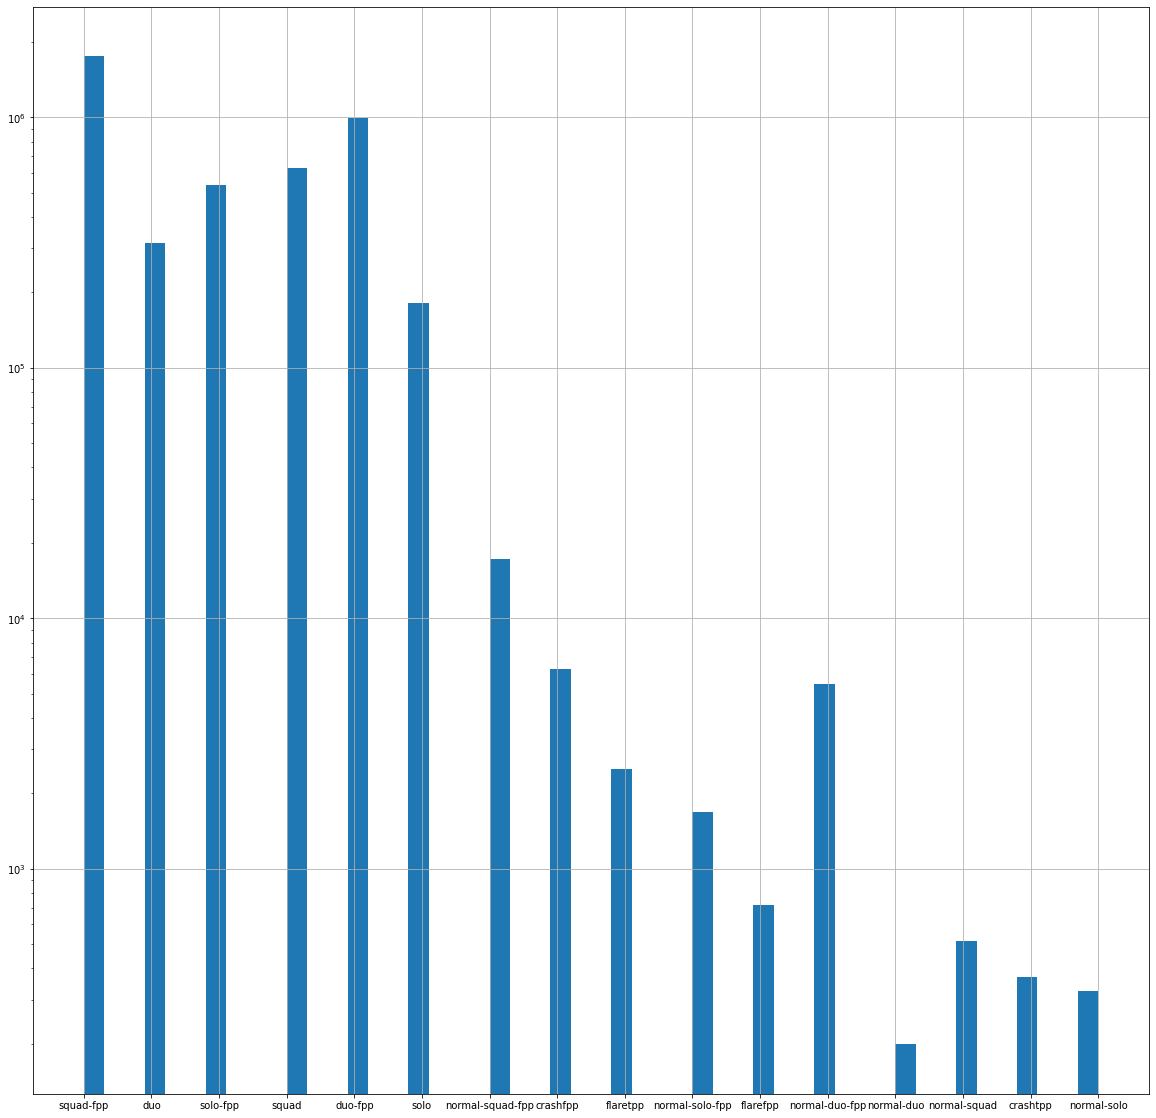

In [10]:
train['matchType'].astype('category').hist(bins=50,figsize=(20,20),log=True)

In [23]:
matchTypes

counts  Percentage
matchType                            
crashfpp             6287    0.001414
crashtpp              371    0.000083
duo                313591    0.070518
duo-fpp            996691    0.224128
flarefpp              718    0.000161
flaretpp             2505    0.000563
normal-duo            199    0.000045
normal-duo-fpp       5489    0.001234
normal-solo           326    0.000073
normal-solo-fpp      1682    0.000378
normal-squad          516    0.000116
normal-squad-fpp    17174    0.003862
solo               181943    0.040914
solo-fpp           536762    0.120703
squad              626526    0.140888
squad-fpp         1756186    0.394918

### View the Average  WinPlacePerc for ranked and unranked

In [10]:
#Split ranked and unranked
search_values = ["normal","crash","flare"]
train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
train_normal = train[train.matchType.str.contains('|'.join(search_values))]

In [13]:
#Original dataset
Means = pd.DataFrame({'Mean': [train_rank["winPlacePerc"].mean(),train_normal["winPlacePerc"].mean()]})
Means

Mean
0  0.472638
1  0.495746

### Plot Correlation Heat Map 
killPoints, matchDuration, maxPlace, numGroups, rankPoints, roadKills, teamKills, winPoints has no linear correlation to maxPlacePerc.

In [23]:
def plot_heat_map(X,y):
    dataset_ = pd.concat([X,y],axis=1)
    corr = dataset_.corr()
    plt.subplots(figsize=(30,20))
    sns.heatmap( corr, square=True, annot=True, fmt=".01f" )  
    plt.show()

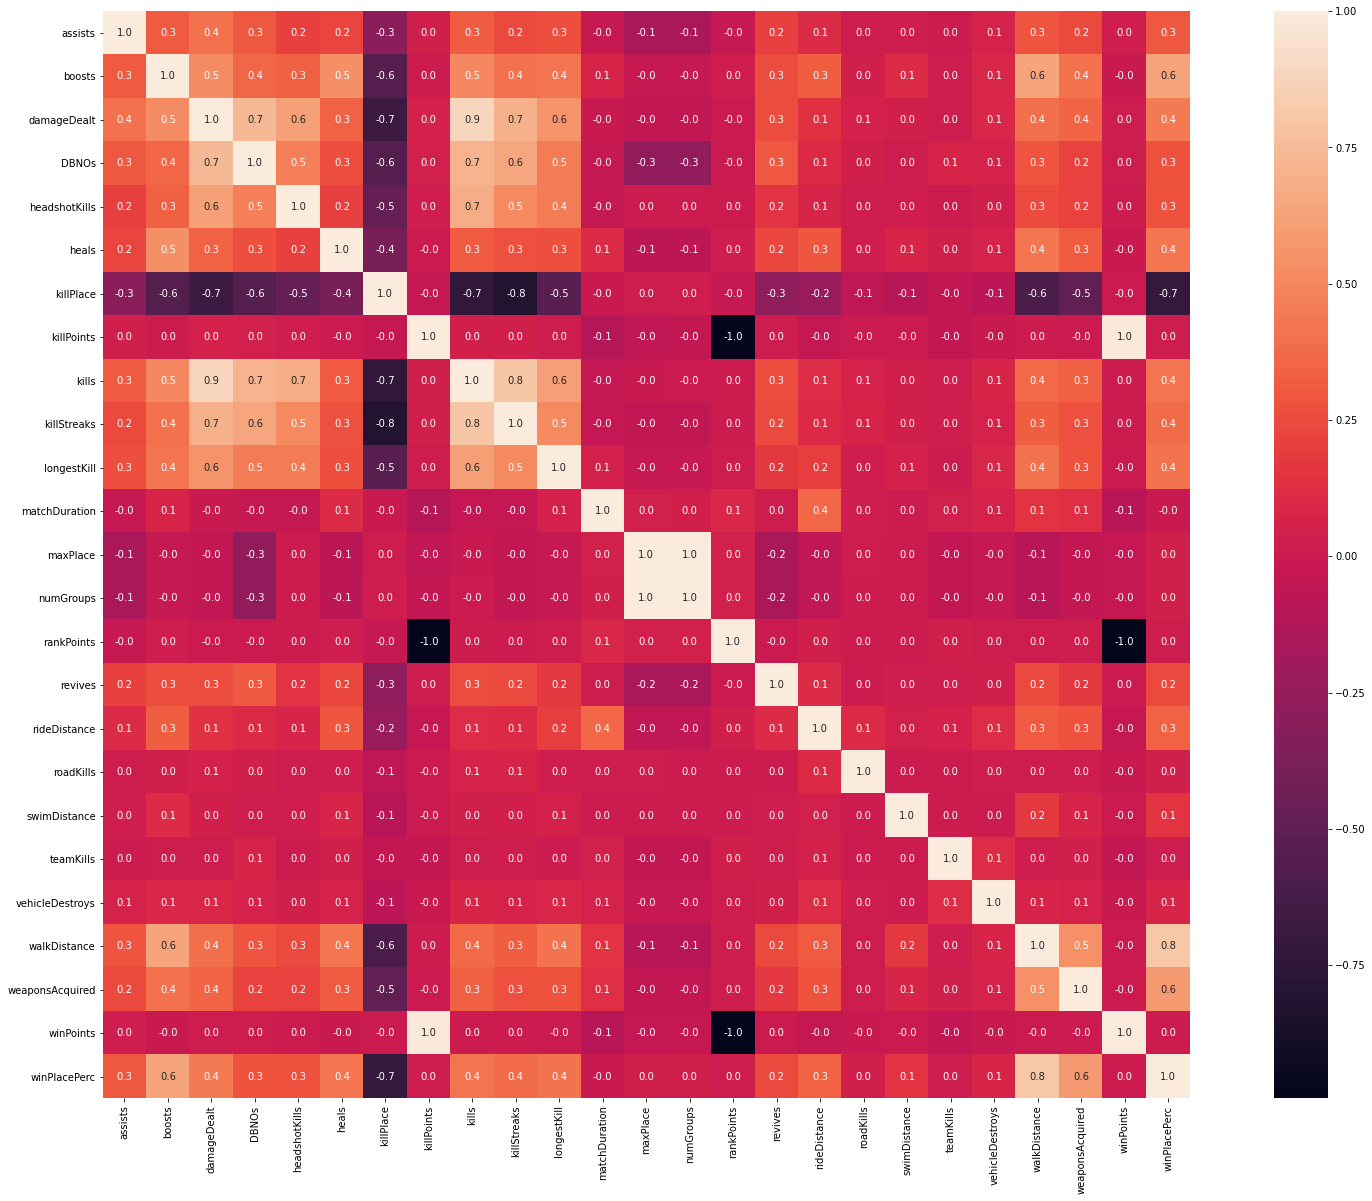

In [24]:
plot_heat_map(X_train,y_train)

### Split X and y value before preprocessing to make sure the consistency

In [25]:
#Randomly pick 80% samples as training set, 20% samples as test set
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.2,random_state = 200)

### Approach 1: 

1. Do One-Hot Encoding for "matchType"

In [26]:
def filter_1(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    return X_train_,X_test_

In [27]:
X_train_1,X_test_1 = filter_1(X_train,X_test)

### Approach 2: 

1.Delete inconsistent values such as rankPoints

2.Do One-Hot Encoding for "matchType"

In [28]:
def filter_2(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [29]:
X_train_2,X_test_2 = filter_2(X_train,X_test)

### Approach 3: 
1.Delete inconsistent values such as rankPoints

2.Combine ranked data with unranked data

3.Do One-Hot Encoding for "matchType"

In [30]:
def filter_3(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    X_ = X_.replace(["solo", "duo","squad","solo-fpp","duo-fpp", "squad-fpp"],
                    ["normal-solo","normal-duo", "normal-squad","normal-solo-fpp","normal-duo-fpp","normal-squad-fpp",])
    
    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [31]:
X_train_3,X_test_3 = filter_3(X_train,X_test)

### Approach 4:
1.Delete inconsistent values such as rankPoints

2.Split ranked data and unranked data (crash and flare are considered as unranked data)

3.Do One-Hot Encoding for "matchType"

In [23]:
def filter_4(X_train,X_test,y_train,y_test):
    
    train = pd.concat([X_train.copy(),y_train.copy()],axis=1)
    test = pd.concat([X_test.copy(),y_test.copy()],axis=1)
    
    #Split ranked and unranked
    search_values = ["normal","crash","flare"]
    train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
    train_normal = train[train.matchType.str.contains('|'.join(search_values))]
    test_rank = test[~test.matchType.str.contains('|'.join(search_values))]
    test_normal = test[test.matchType.str.contains('|'.join(search_values))]

    #Split X and y
    y_train_rank = train_rank["winPlacePerc"]
    X_train_rank = train_rank.drop(["winPlacePerc"],axis=1)
    
    y_train_normal = train_normal["winPlacePerc"]
    X_train_normal = train_normal.drop(["winPlacePerc"],axis=1)
    
    y_test_rank = test_rank["winPlacePerc"]
    X_test_rank = test_rank.drop(["winPlacePerc"],axis=1)
    
    y_test_normal = test_normal["winPlacePerc"]
    X_test_normal = test_normal.drop(["winPlacePerc"],axis=1)
    
    #Concatenate
    X_rank = pd.concat([X_train_rank,X_test_rank])
    X_normal = pd.concat([X_train_normal,X_test_normal])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_rank = X_rank.drop(["rankPoints","killPoints","winPoints"],axis=1)
    X_normal = X_normal.drop(["rankPoints","killPoints","winPoints"],axis=1)
    
    #Do One-Hot Encoding for "matchType"
    X_rank = pd.get_dummies(data = X_rank, columns = ["matchType"])
    X_normal = pd.get_dummies(data = X_normal, columns = ["matchType"])
    
    #Split into train and test again
    X_rank_train_ = X_rank.head(X_train_rank.shape[0])
    X_rank_test_ = X_rank.tail(X_test_rank.shape[0])
    
    X_normal_train_ = X_rank.head(X_train_normal.shape[0])
    X_normal_test_ = X_rank.tail(X_test_normal.shape[0])    
    
    return X_rank_train_,y_train_rank,X_rank_test_,y_test_rank,X_normal_train_,y_train_normal,X_normal_test_,y_test_normal

In [24]:
X_train_rank,y_train_rank,X_test_rank,y_test_rank,X_train_normal,y_train_normal,X_test_normal,y_test_normal = filter_4(X_train,X_test,y_train,y_test)

# Initialize models

### Single Set
Use a list to store all models

In [35]:
n_approaches = 3

In [37]:
X_train_list = [X_train_1,X_train_2,X_train_3]
X_test_list = [X_test_1,X_test_2,X_test_3]

#### 1. SGDRegressor 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [41]:
sgds = [SGDRegressor()]*n_approaches

In [36]:
xgboosts = [XGBRegressor()]*n_approaches

### Multiple Sets

In [35]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

# Training & Validation

### Single set 

In [29]:
losses = ["squared_loss",'huber','epsilon_insensitive','squared_spsilon_insensitive']
penalties = ['l2','l1','elasticnet']
max_iters = [1000,2000,3000]
learning_rates = ["invscaling",'constant','optimal','adaptive']

In [ ]:
for i in range(len(sgds)):
    sgd = sgds[i]
    best_loss = None
    best_penalty = None
    best_max_iter = None
    best_learning_rate = None
    best_score = 0
    for loss in losses:
        sgd.loss = loss
        for penalty in penalties:
            sgd.penalty = penalty
            for max_iter in max_iters:
                sgd.max_iter = max_iter
                for learning_rate in learning_rates:
                    sgd.learning_rate = learning_rate
                    scores = cross_val_score(sgd, X_train_list[i], y_train, cv=5,scoring = "neg_mean_absolute_error")
                    avg_score = sum(-scores)/5
                    if(avg_score>best_score):
                        best_score = avg_score
                        best_loss = loss
                        best_penalty = penalty
                        best_max_iter = max_iter
                        best_learning_rate = learning_rate
                    print("model: ",sgd, "score: ",avg_score)
    sgds[i].loss = best_loss
    sgds[i].penalty = best_penalty
    sgds[i].max_iter = best_max_iter
    sgds[i].learning_rate = best_learning_rate

### Multiple Sets

In [ ]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

# Results

### Approach 1

#### XGBOOST 

In [38]:
xgboosts[0].fit(X_train_list[0],y_train)

[20:06:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [40]:
mean_absolute_error(xgboosts[0].predict(X_test_list[0]),y_test)

0.0690389156139343

#### SGD 

In [42]:
sgds[0].fit(X_train_list[0],y_train)

SGDRegressor()

In [43]:
mean_absolute_error(sgds[0].predict(X_test_list[0]),y_test)

0.09270425762564108

### Approach 2

#### XGBOOST 

In [44]:
xgboosts[1].fit(X_train_list[1],y_train)

[20:16:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [45]:
mean_absolute_error(xgboosts[1].predict(X_test_list[1]),y_test)

0.06916933913012845

#### SGD 

In [46]:
sgds[1].fit(X_train_list[1],y_train)

SGDRegressor()

In [47]:
mean_absolute_error(sgds[1].predict(X_test_list[1]),y_test)

0.09293350190927077

### Approach 3

#### XGBOOST 

In [48]:
xgboosts[2].fit(X_train_list[2],y_train)

[20:24:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [49]:
mean_absolute_error(xgboosts[2].predict(X_test_list[2]),y_test)

0.06914203148679031

#### SGD 

In [50]:
sgds[2].fit(X_train_list[2],y_train)

SGDRegressor()

In [51]:
mean_absolute_error(sgds[2].predict(X_test_list[2]),y_test)

0.09309614652884773

### Approach 4

#### XGBOOST 

#### SGD 

In [69]:
sgd_rank.fit(X_train_rank,y_train_rank)
sgd_normal.fit(X_train_normal,y_train_normal)

SGDRegressor()

In [70]:
(mean_absolute_error(sgd_rank.predict(X_test_rank),y_test_rank)*X_test_rank.shape[0]+mean_absolute_error(sgd_normal.predict(X_test_normal),y_test_normal)*X_test_normal.shape[0])/(X_test_rank.shape[0]+X_test_normal.shape[0])

0.09320165415469985